# Characterize Mercer, Novel, All BPs

For each group plot:
- Phastcons
- PhyloP
- Distance from 3'ss
- PWM

both seperately and all on one plot.

In [1]:
import numpy as np
import RNA
from sklearn import metrics
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        gene = gene.split('.')[0]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

37110
169182
('chr9', 137650088, '+', 'ENSG00000130635')


In [6]:
L = 70

def bpp(seq):
    r = RNA.fold_compound(seq)
    r.pf()
    return np.array(r.bpp())[1:, 1:]

def marginal_bpp(seq):
    M = bpp(seq)
    return (np.sum(M, axis = 1) + np.sum(M, axis = 0)).reshape(-1, 1)

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2, marginal_bpp(seq)]).reshape(1, L, 7)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known, phastcons, phylop)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing, phastcons, phylop)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 56808.0
(169182, 70, 7) (37110, 70, 7)


In [7]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [8]:
y_novel = model.predict(X_novel[:, :, :4]).reshape(-1, L)
p_known = model.predict(X_known[:, :, :4]).reshape(-1, L)

X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])

In [9]:
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

## Conservation Meta

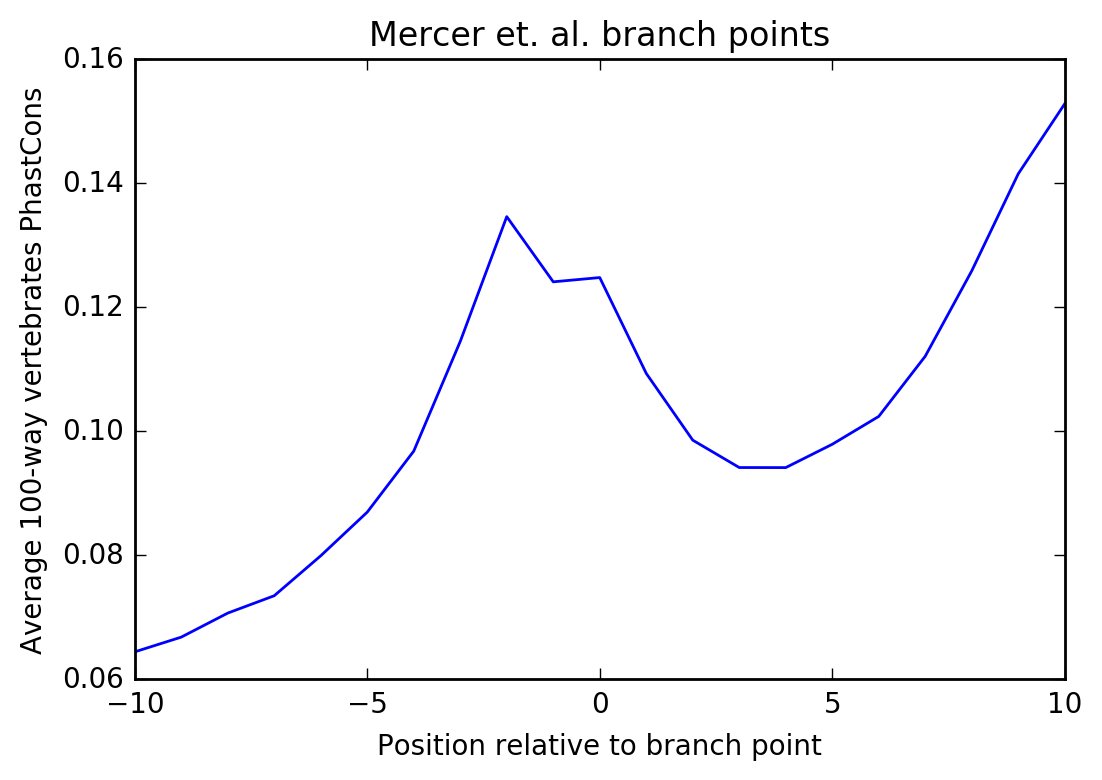

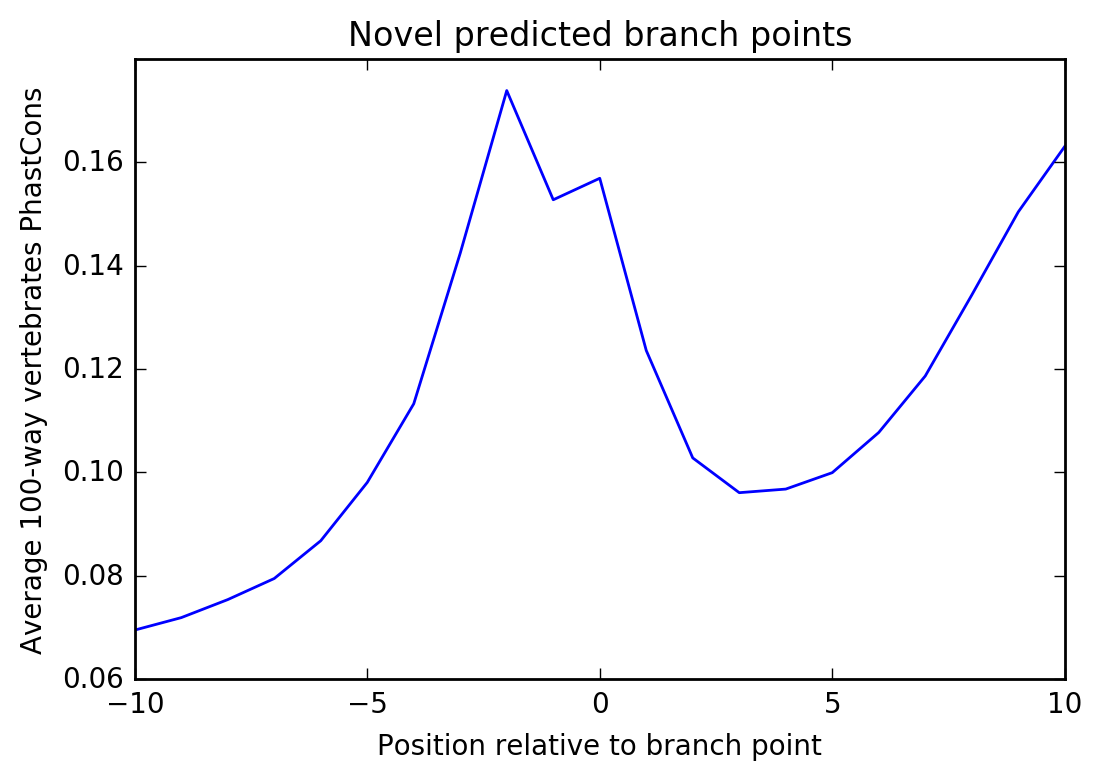

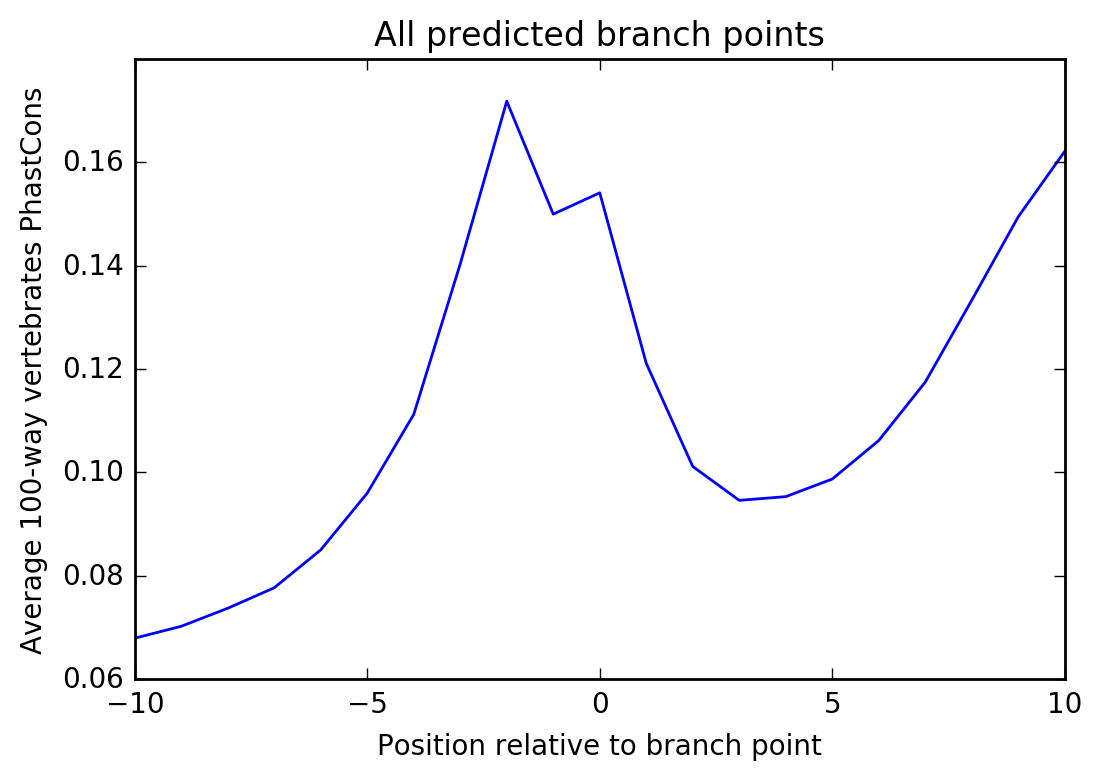

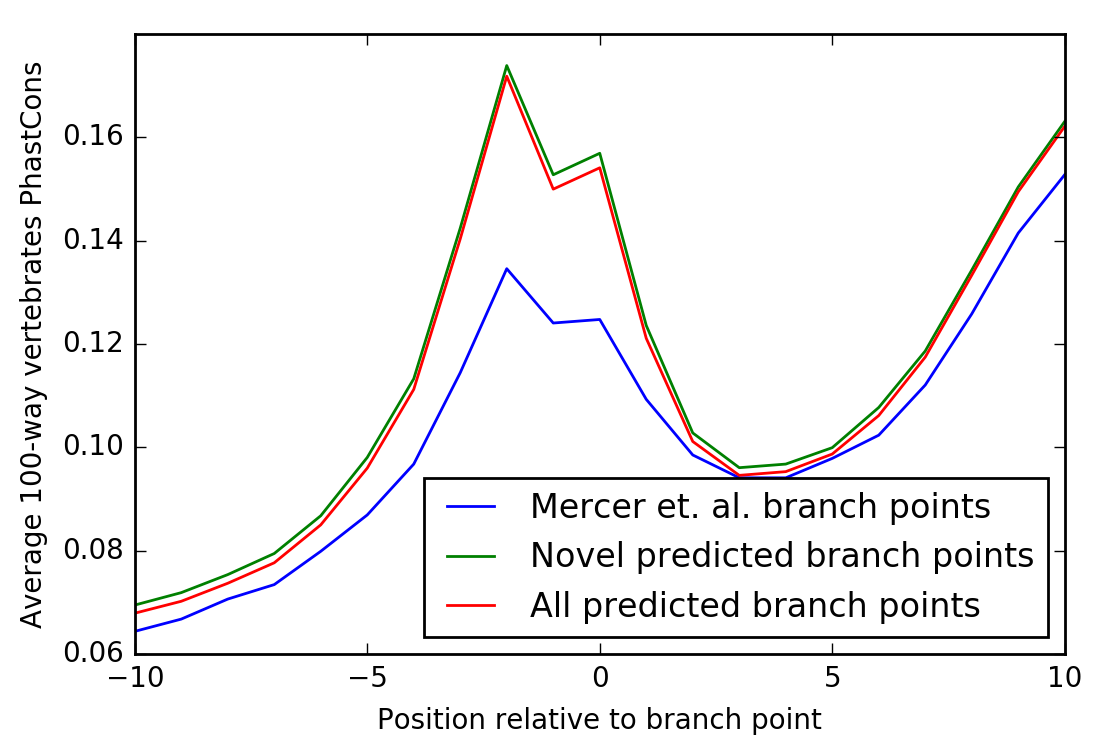

In [10]:
K = 10

def cons_known(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, idx]
            total += 1
    return counts / total

def cons_novel(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, idx]
        total += 1
    return counts / total

known = cons_known(X_known, y_known, 4)
novel = cons_novel(X_novel, y_novel, 4)
allbp = cons_novel(X_all,   y_all,   4)

names = ['Mercer et. al. branch points',
         'Novel predicted branch points',
         'All predicted branch points']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
plt.legend(loc = 'best')
plt.show()

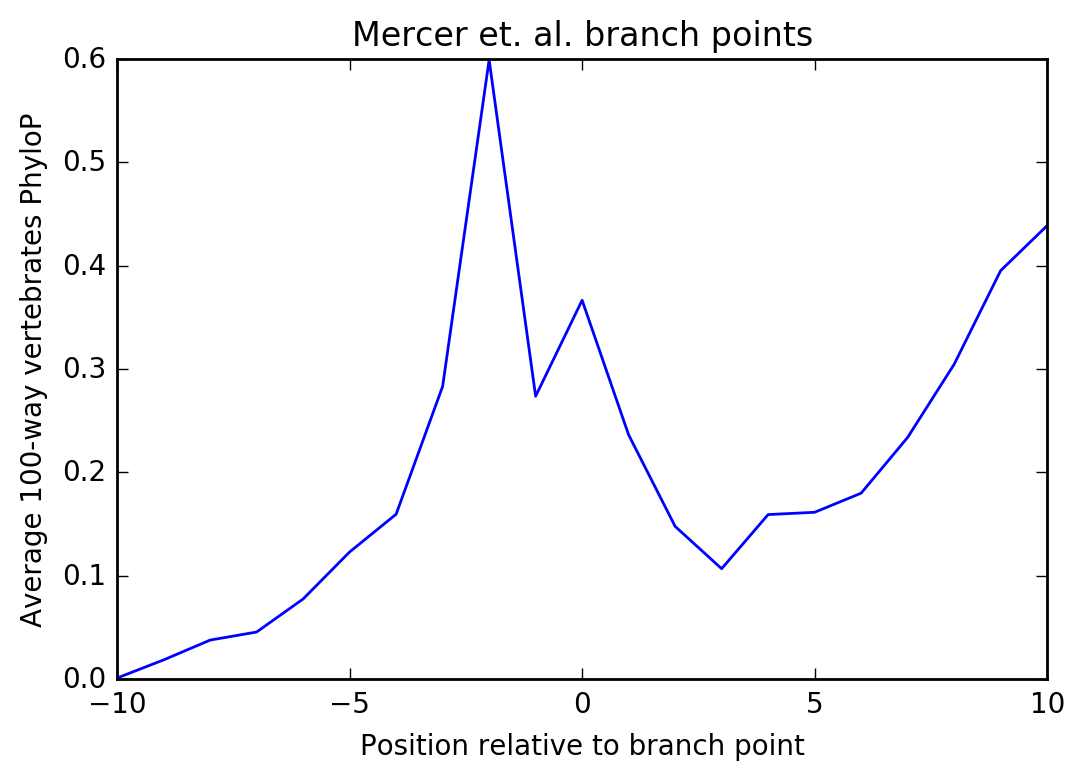

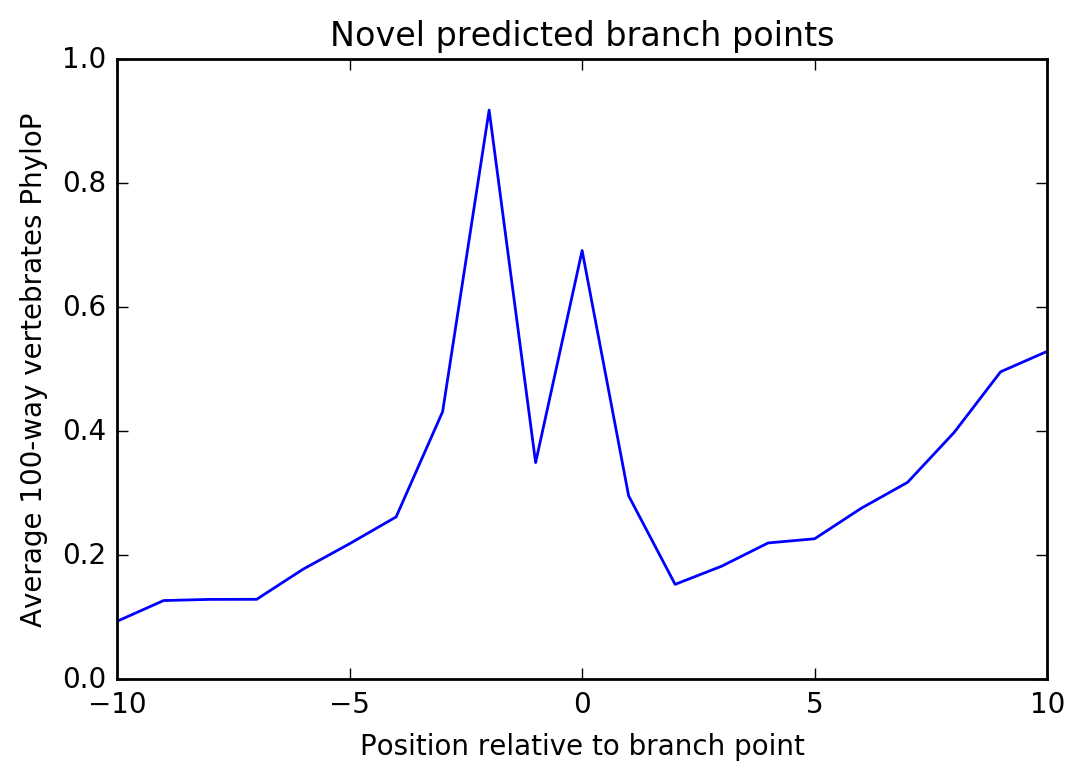

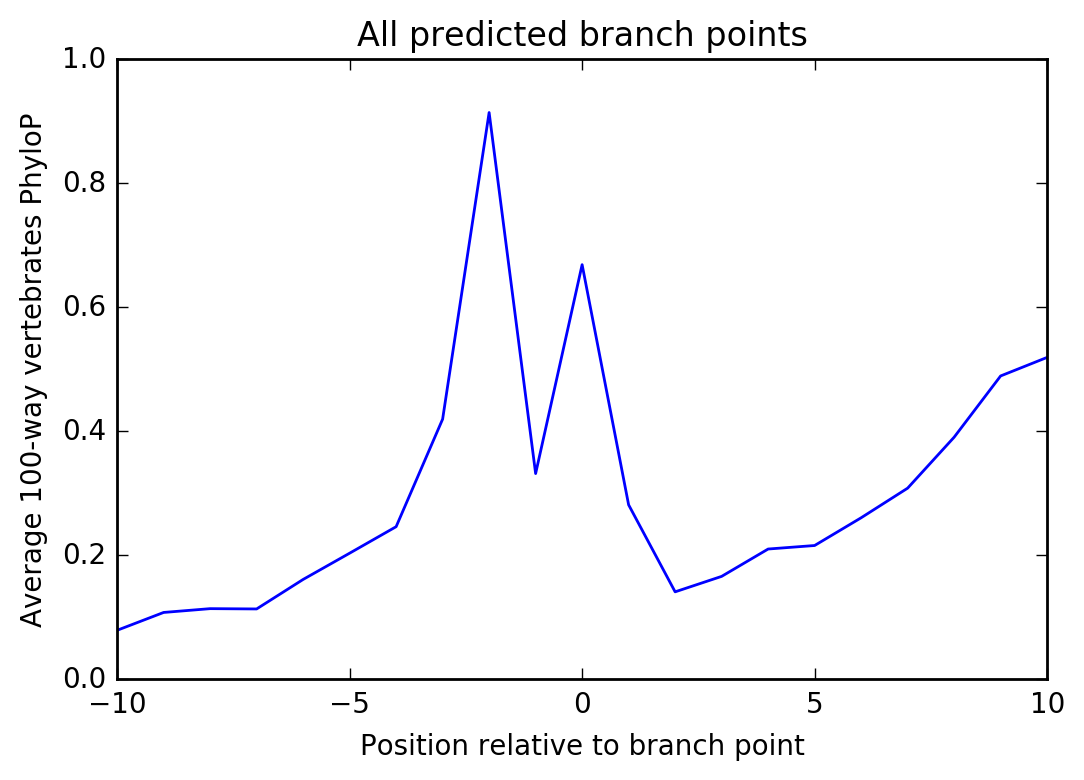

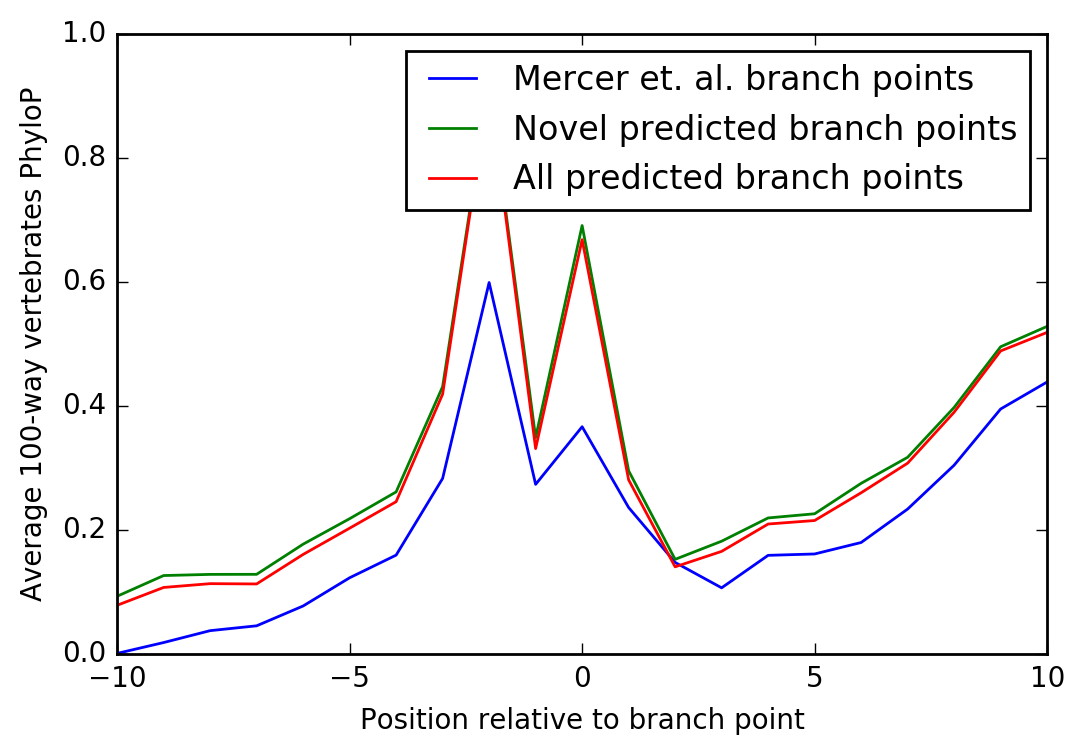

In [11]:
known = cons_known(X_known, y_known, 5)
novel = cons_novel(X_novel, y_novel, 5)
allbp = cons_novel(X_all,   y_all,   5)

names = ['Mercer et. al. branch points',
         'Novel predicted branch points',
         'All predicted branch points']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 'best')
plt.show()

202549


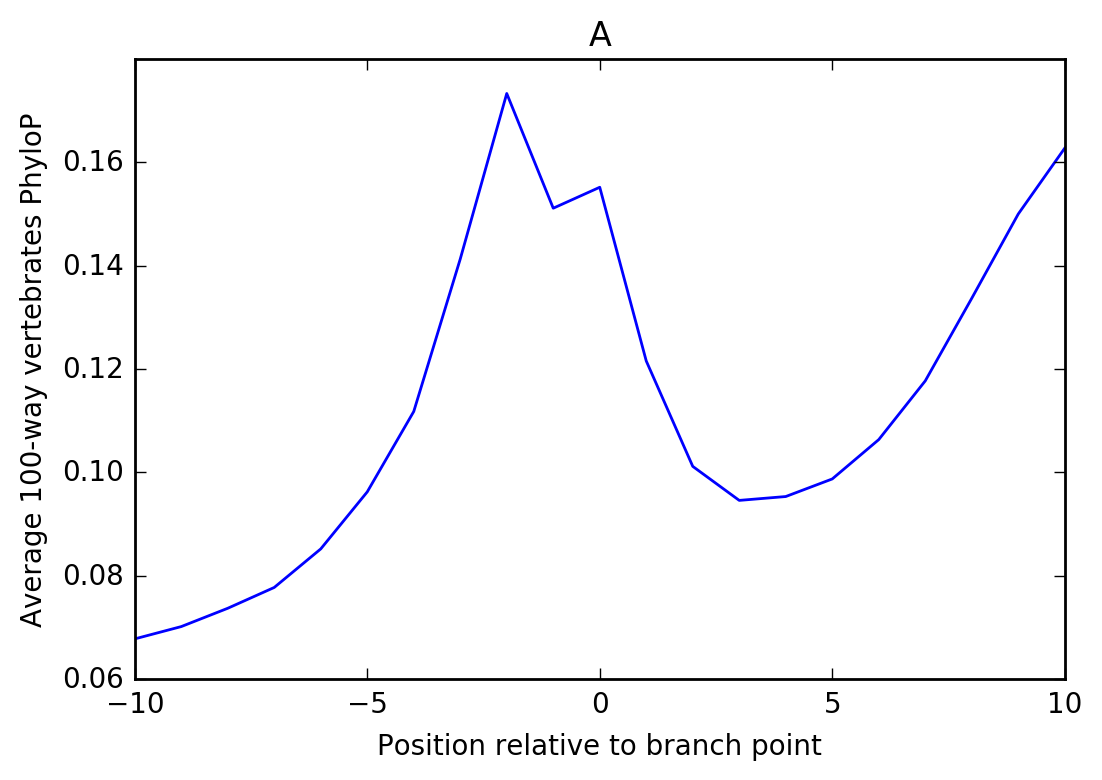

3347


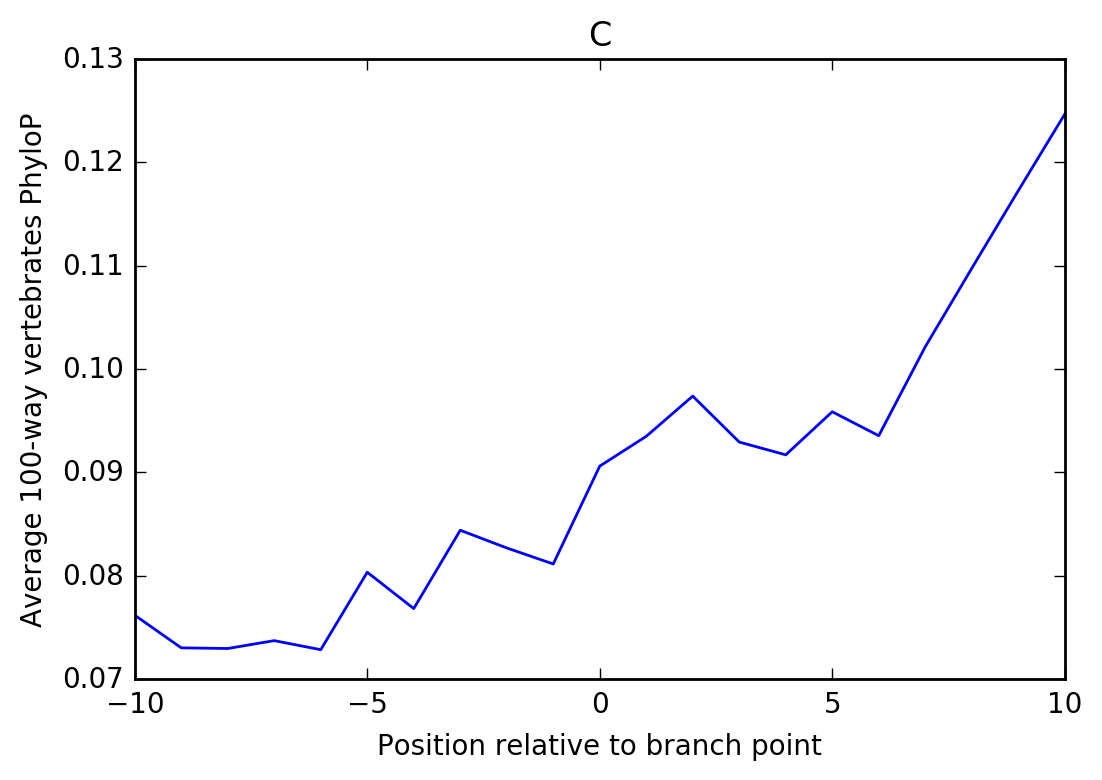

57


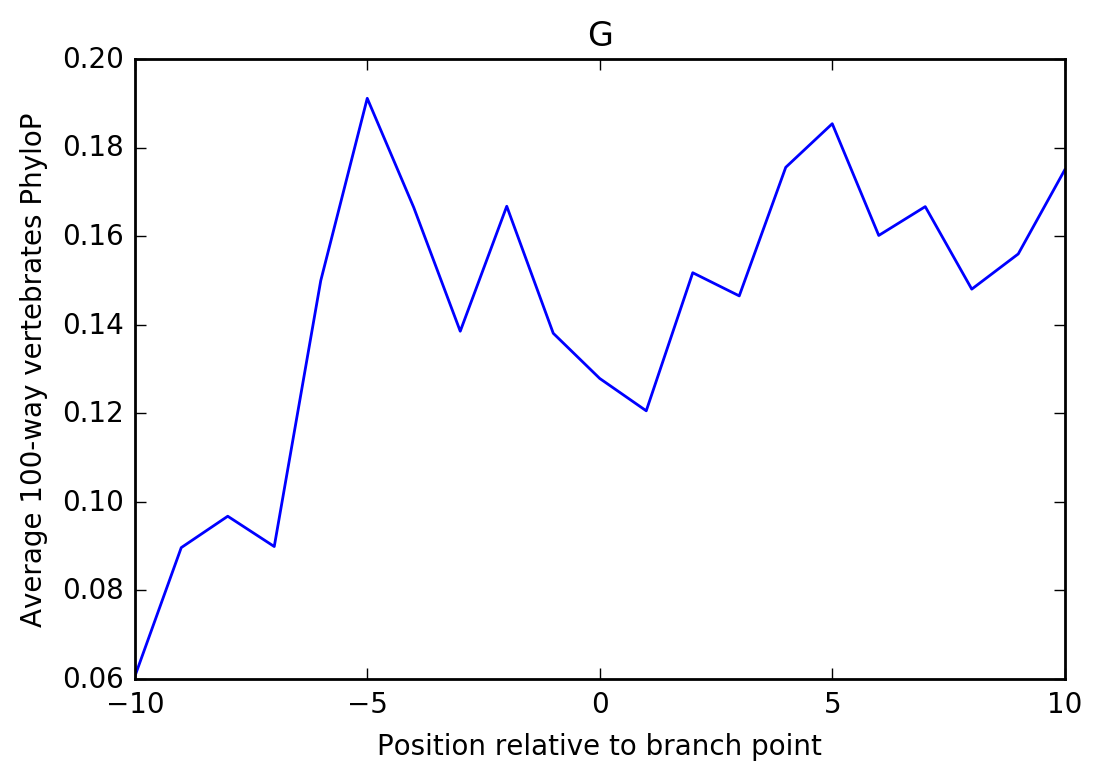

69


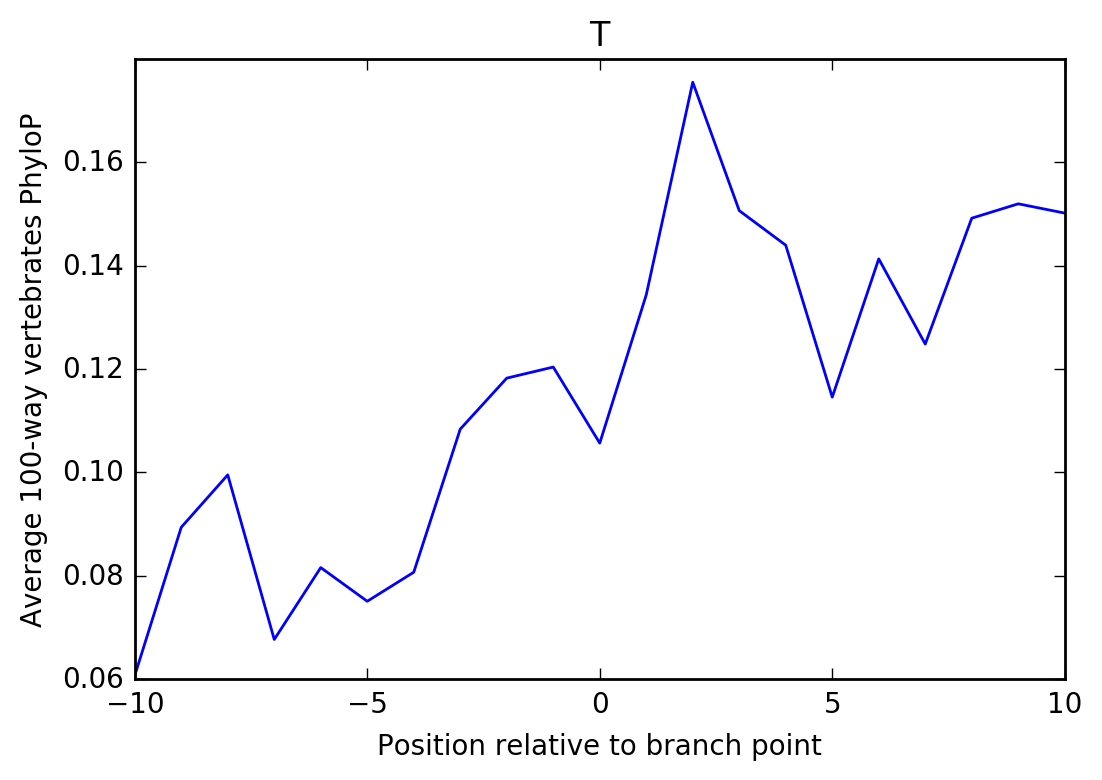

202549


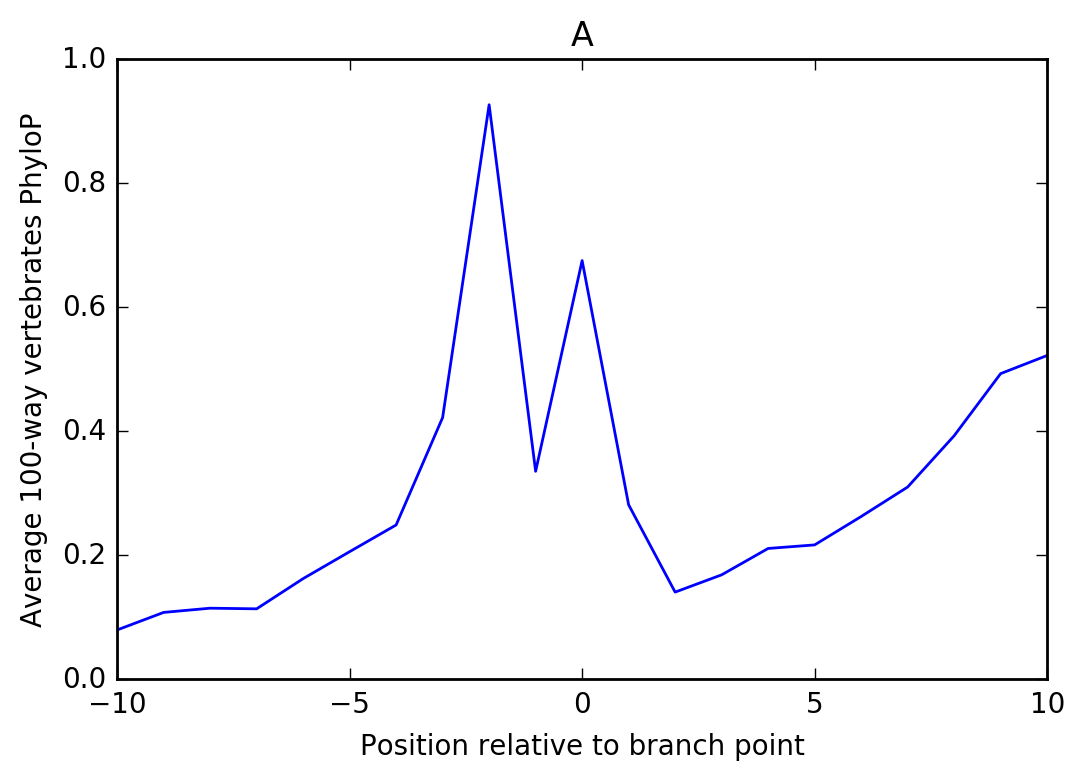

3347


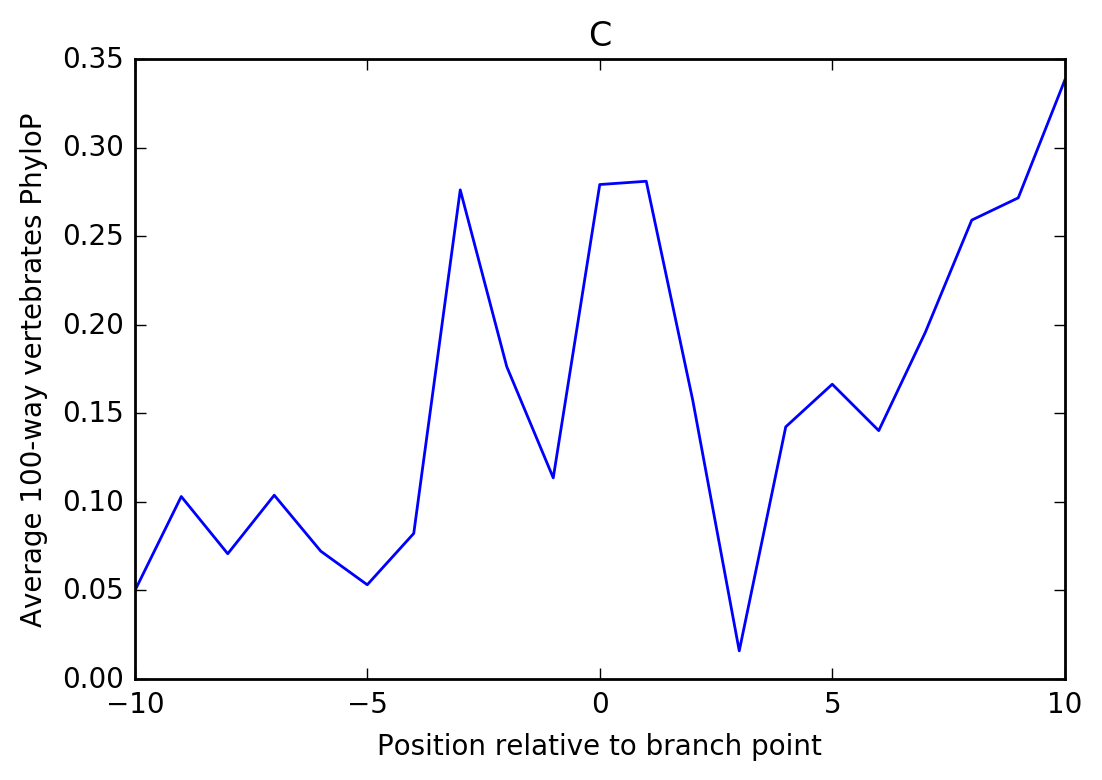

57


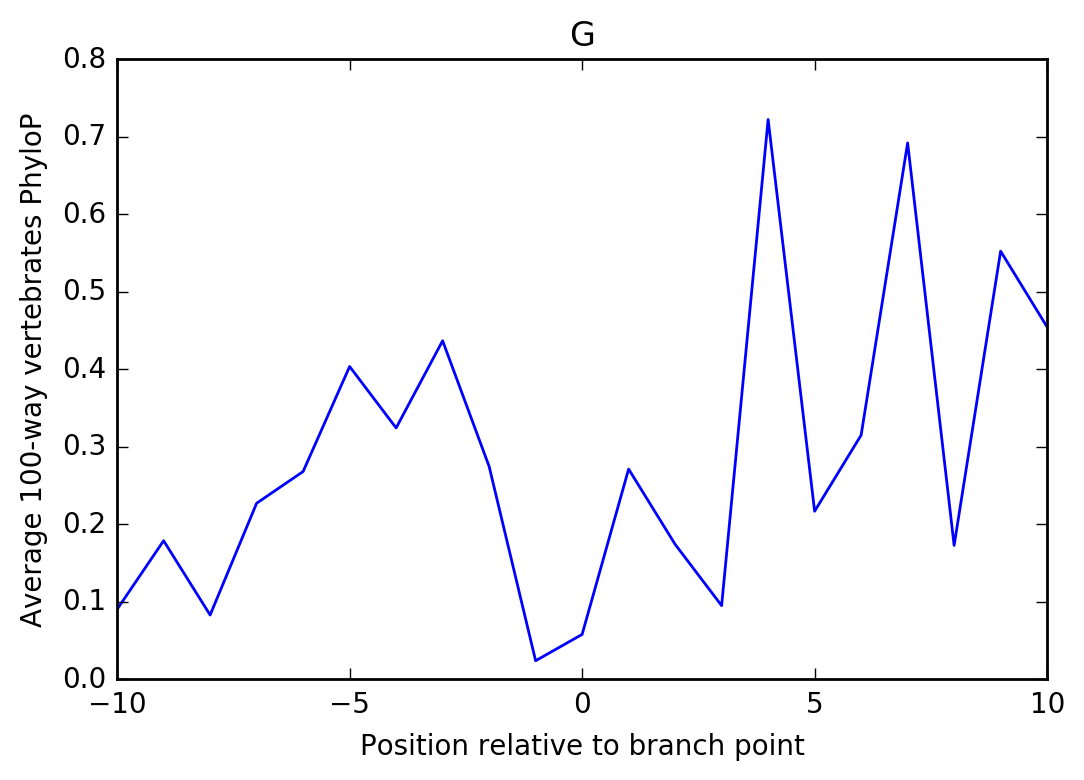

69


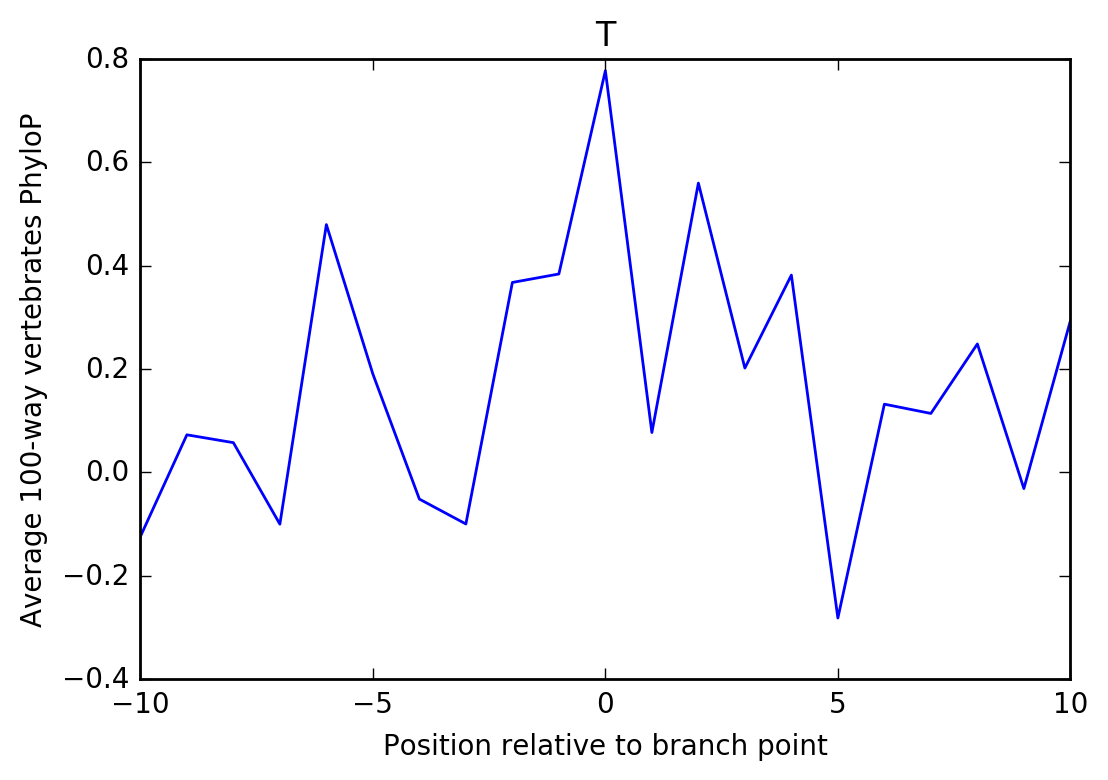

In [12]:
# By BP nucleotide

def cons_novel_base(X, y, idx, base):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if not seq[bp, base]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
             cons_novel_base(X_all, y_all, 4, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_novel_base(X_all, y_all, 5, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()

167172
38850


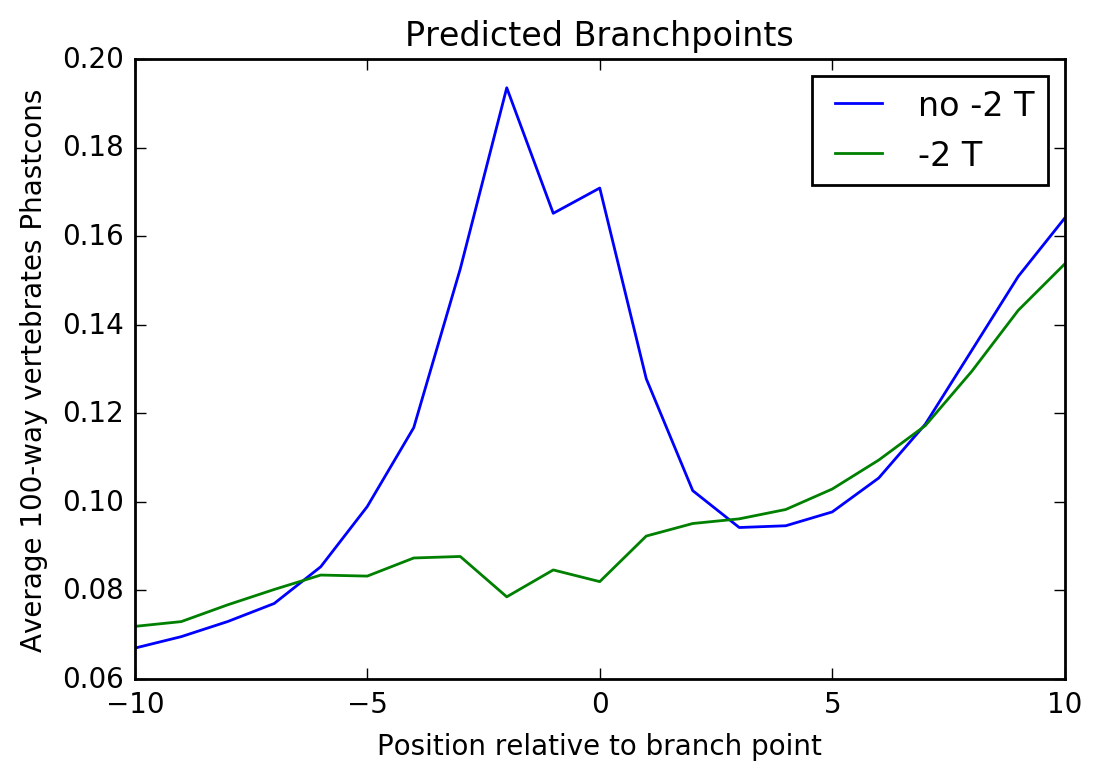

167172
38850


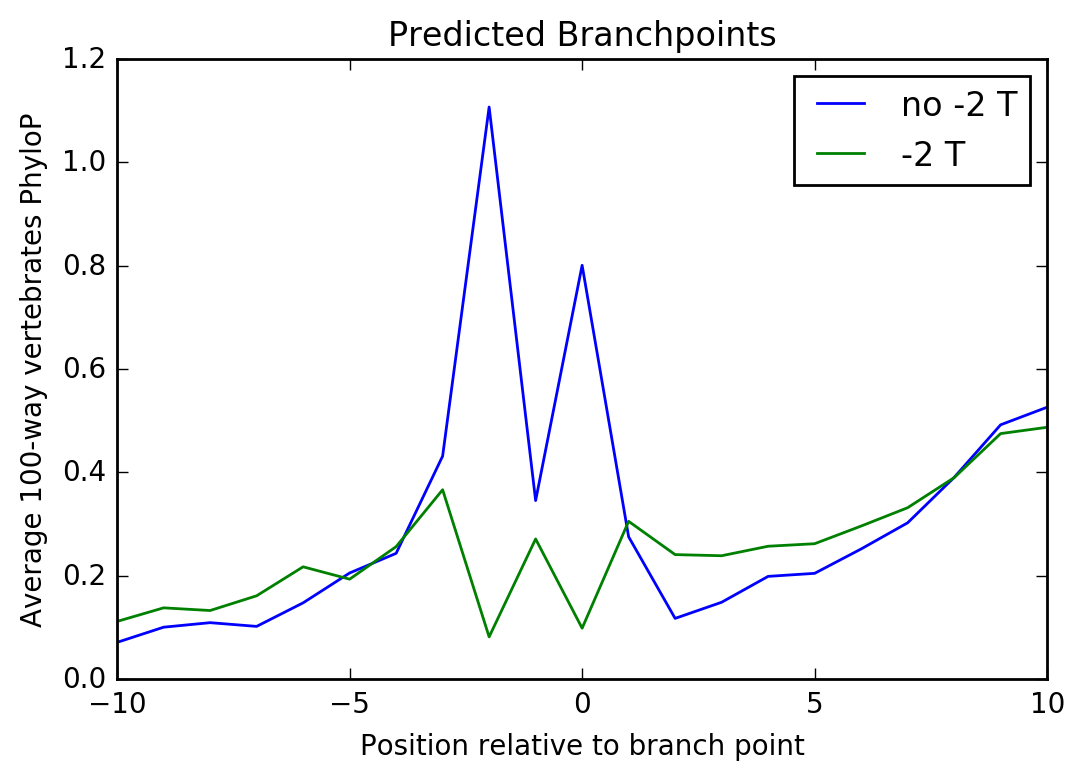

In [13]:
# No -2 T

def cons_novel_T(X, y, idx, T):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        if T==seq[bp-2, 3]: continue
        counts += seq[bp-K: bp+K+1, idx]
        total += 1
    print total
    return counts / total

for t, name in enumerate(['no -2 T','-2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 4, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates Phastcons')
plt.title('Predicted Branchpoints')
plt.legend(loc = 'best')
plt.show()

for t, name in enumerate(['no -2 T','-2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_novel_T(X_all, y_all, 5, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhyloP')
plt.title('Predicted Branchpoints')
plt.legend(loc = 'best')
plt.show()

## Dists

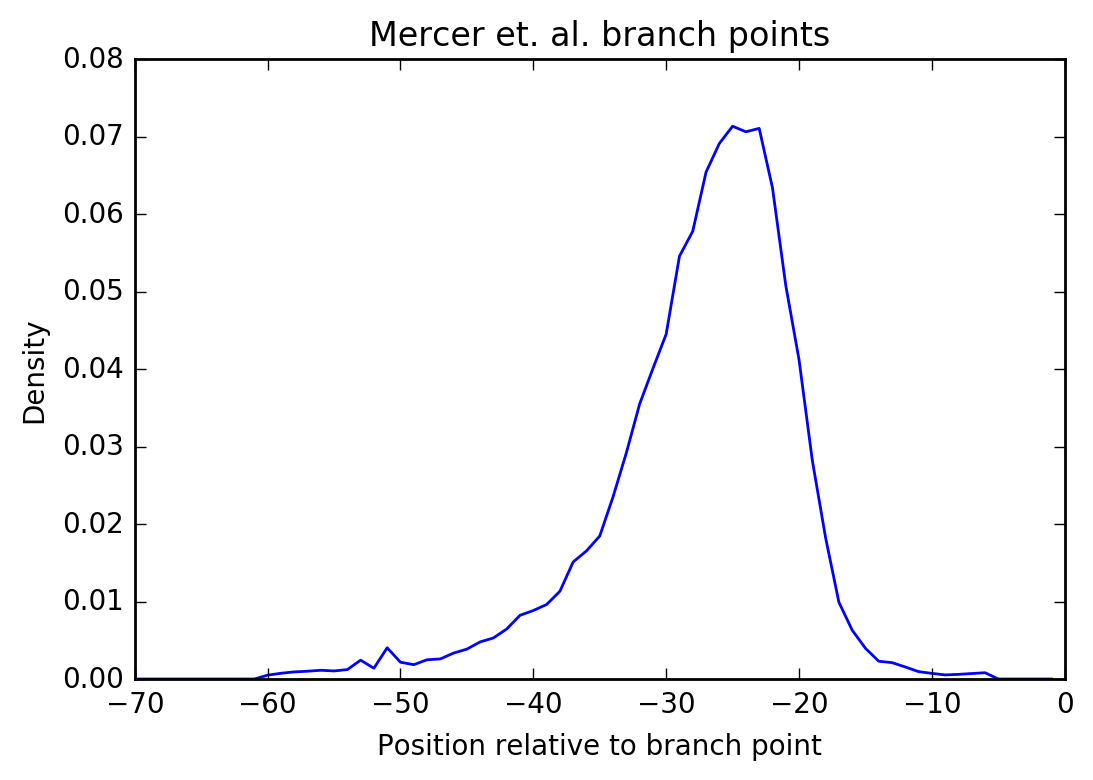

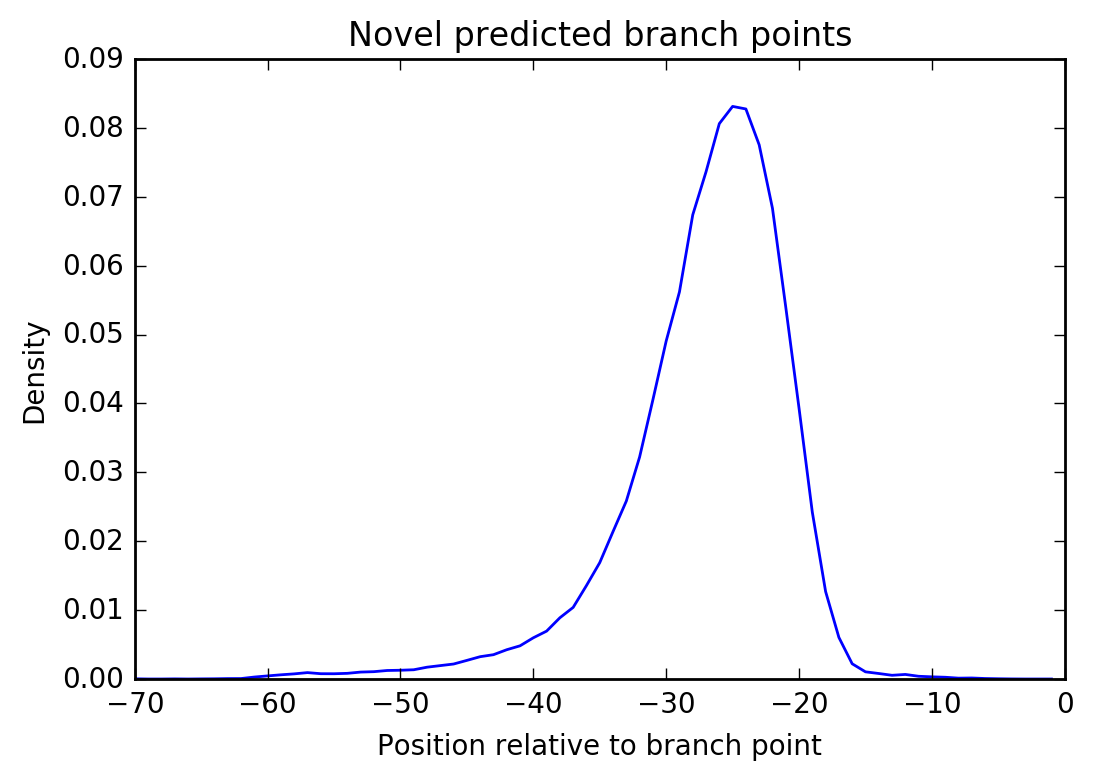

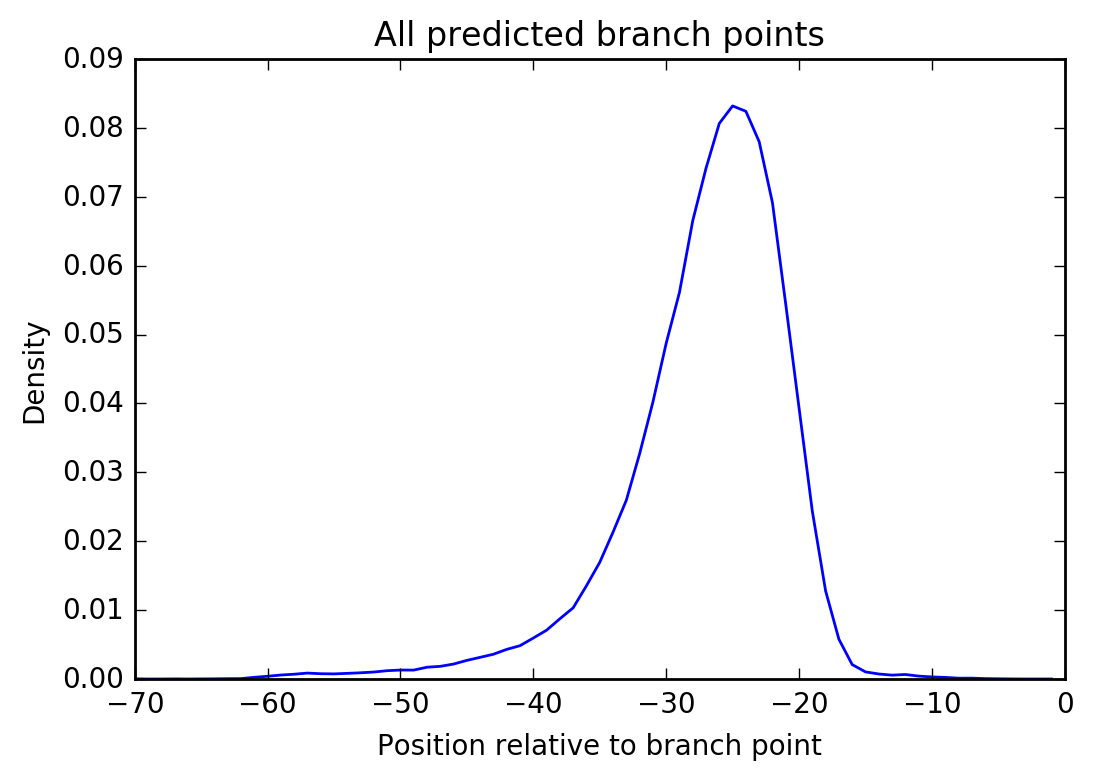

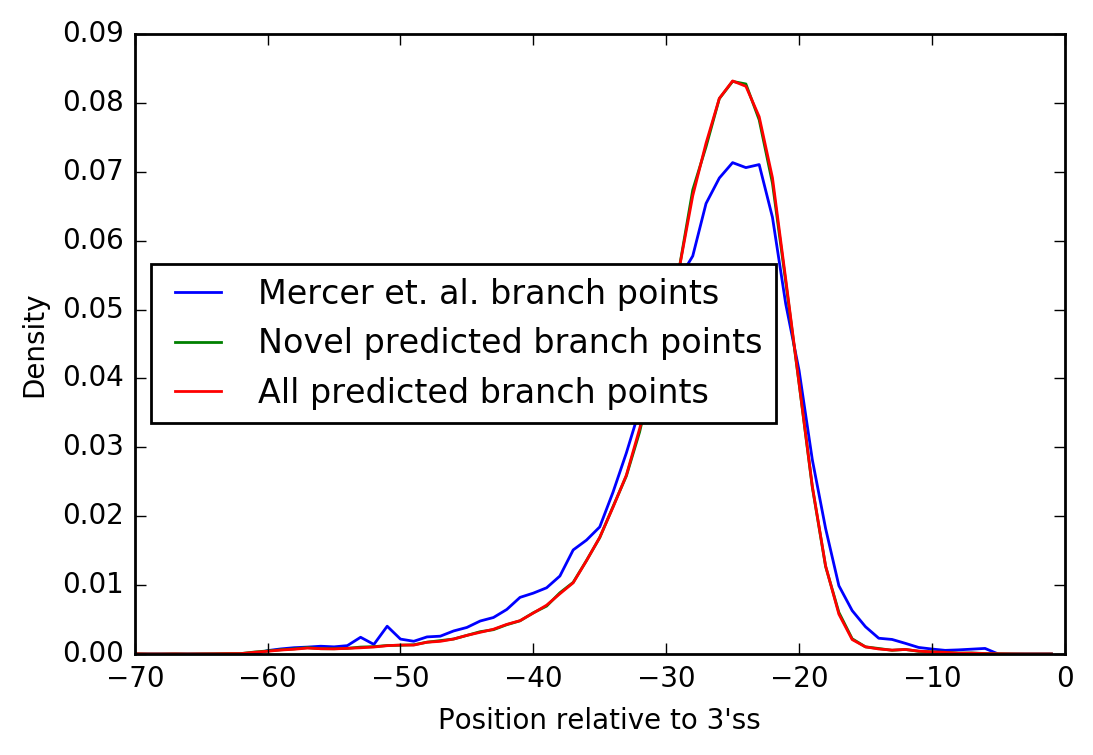

In [14]:
def dist_known(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            counts[bp] += 1
            total += 1
    return counts / total

def dist_novel(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        counts[bp] += 1
        total += 1
    return counts / total

known = dist_known(X_known, y_known, 4)
novel = dist_novel(X_novel, y_novel, 4)
allbp = dist_novel(X_all,   y_all,   4)

dists = [known, novel, allbp]

for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Density')
    plt.show()
    
for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist, label = name)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 'best')
plt.show()

## PWM

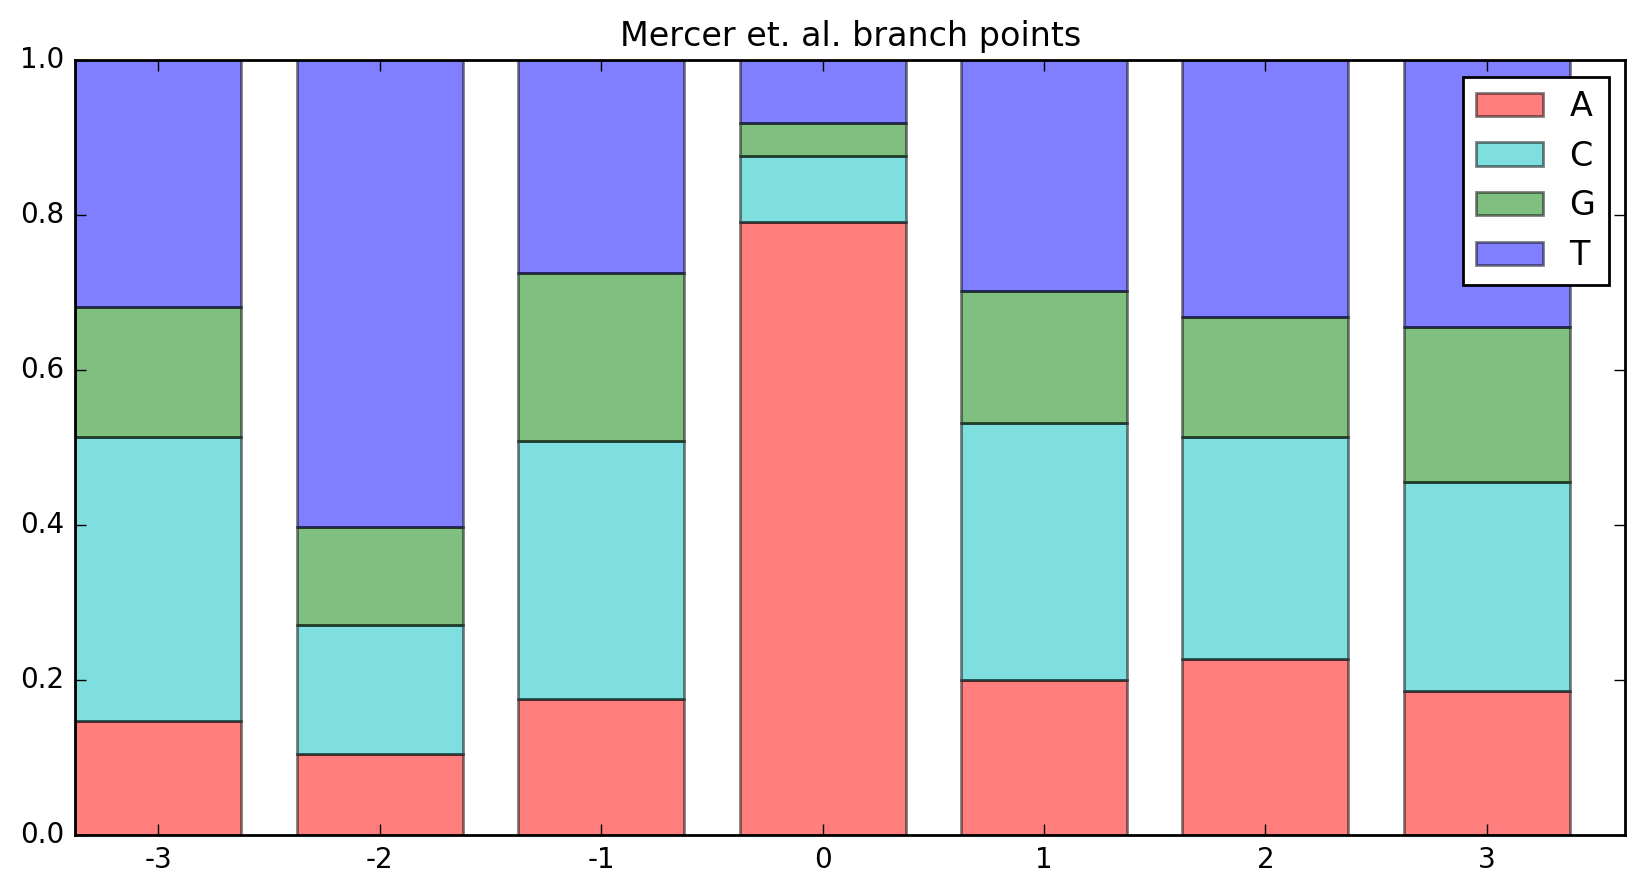

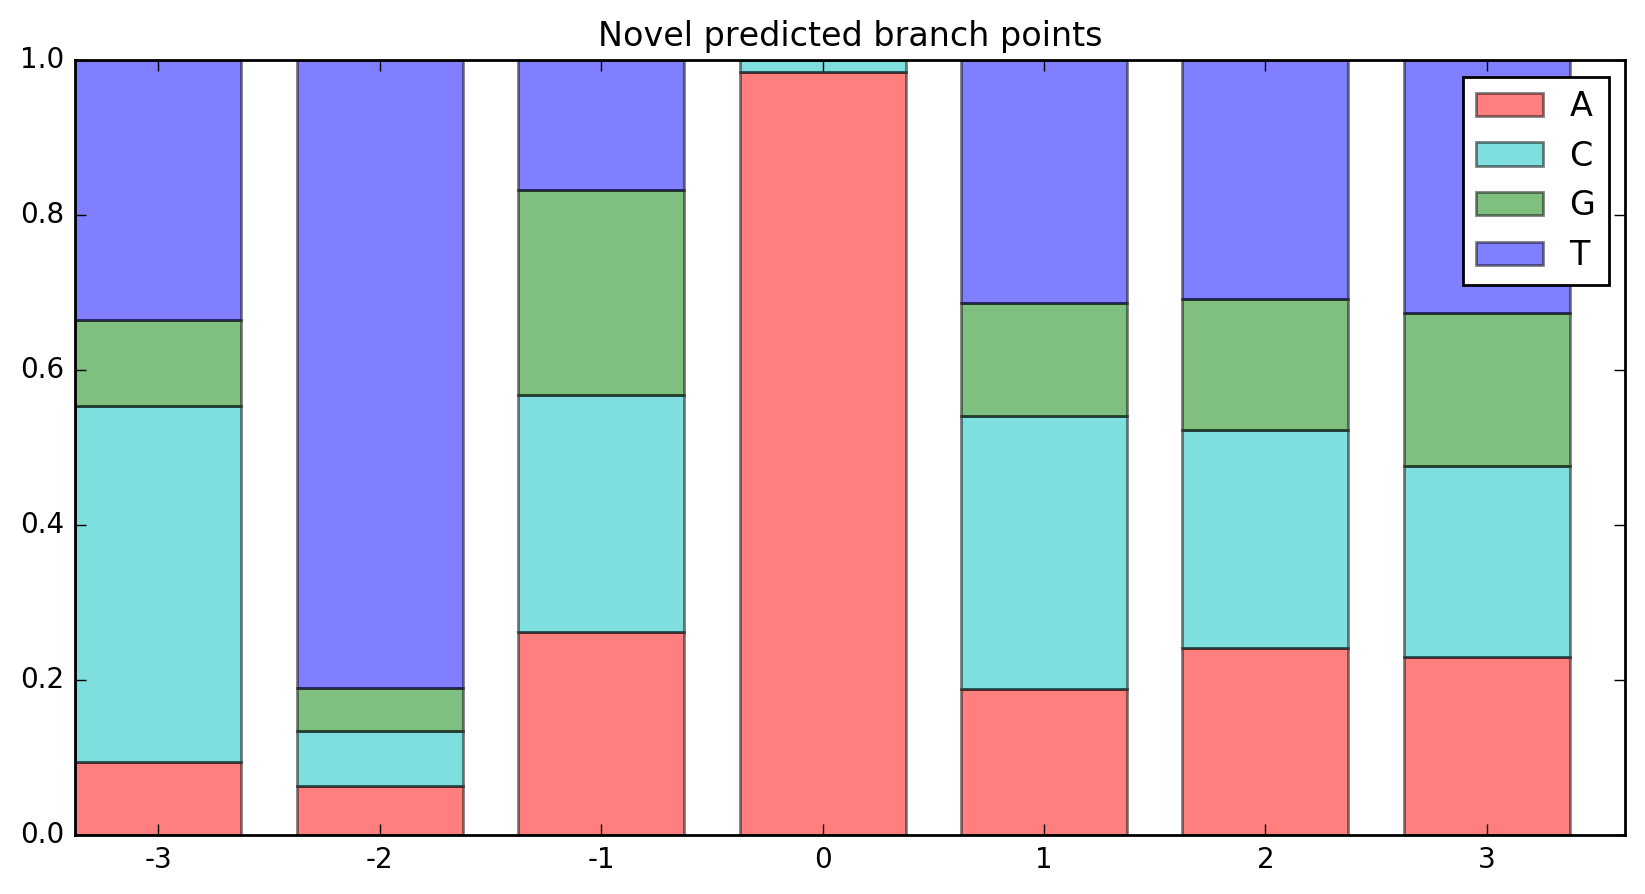

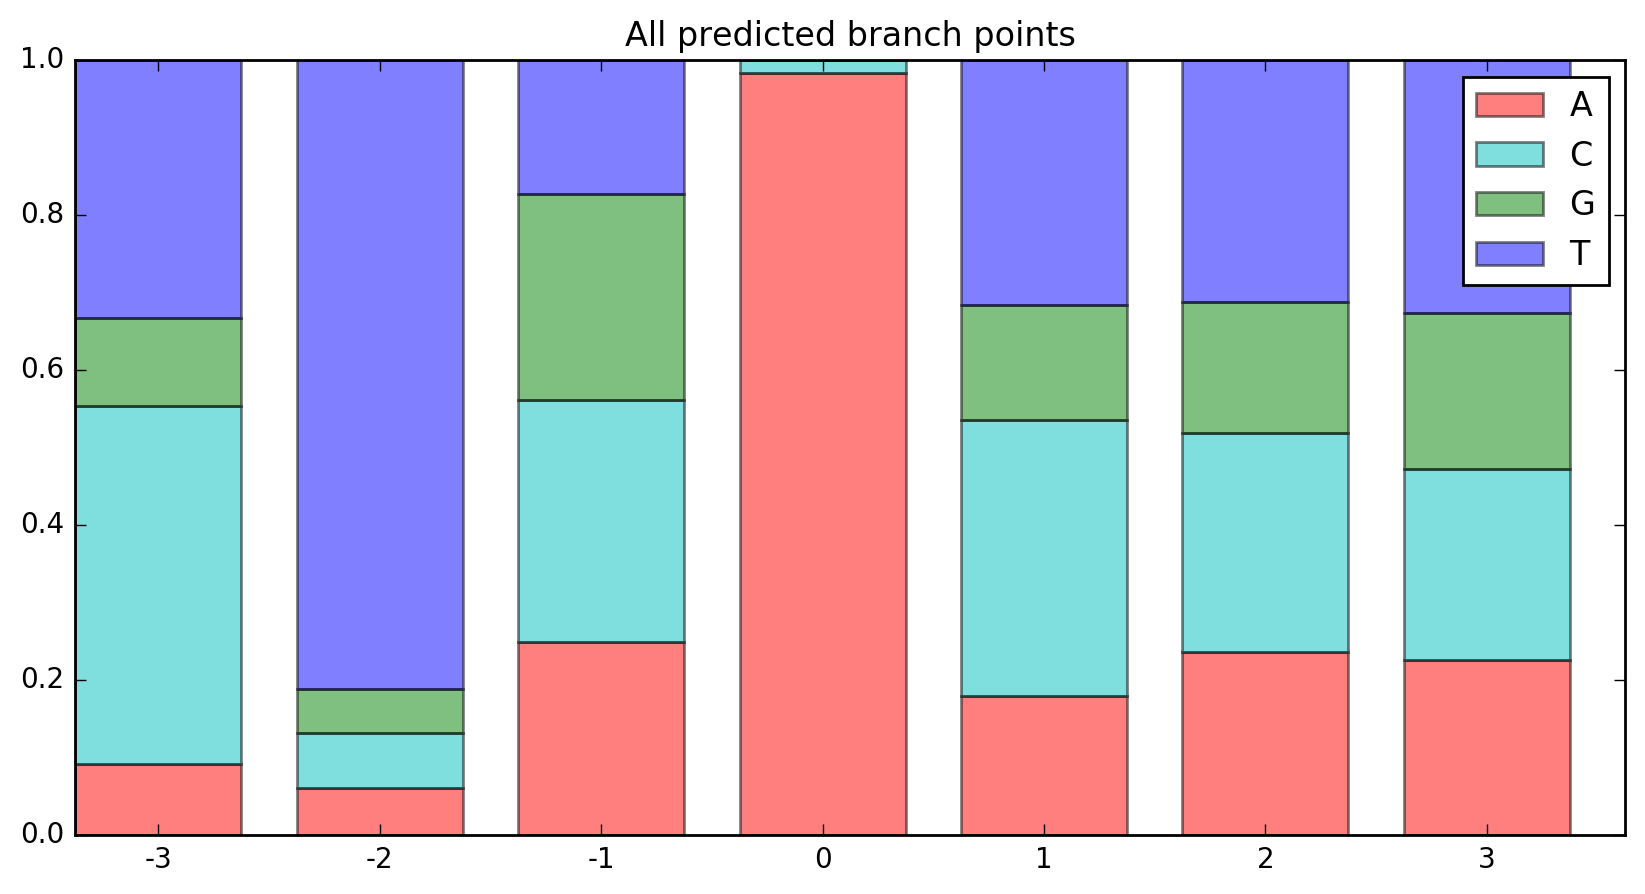

In [15]:
def pwm_logo(pwm, title):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

# Known
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm_logo(counts / total, names[0])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_novel, X_novel):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm_logo(counts / total, names[1])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm_logo(counts / total, names[2])

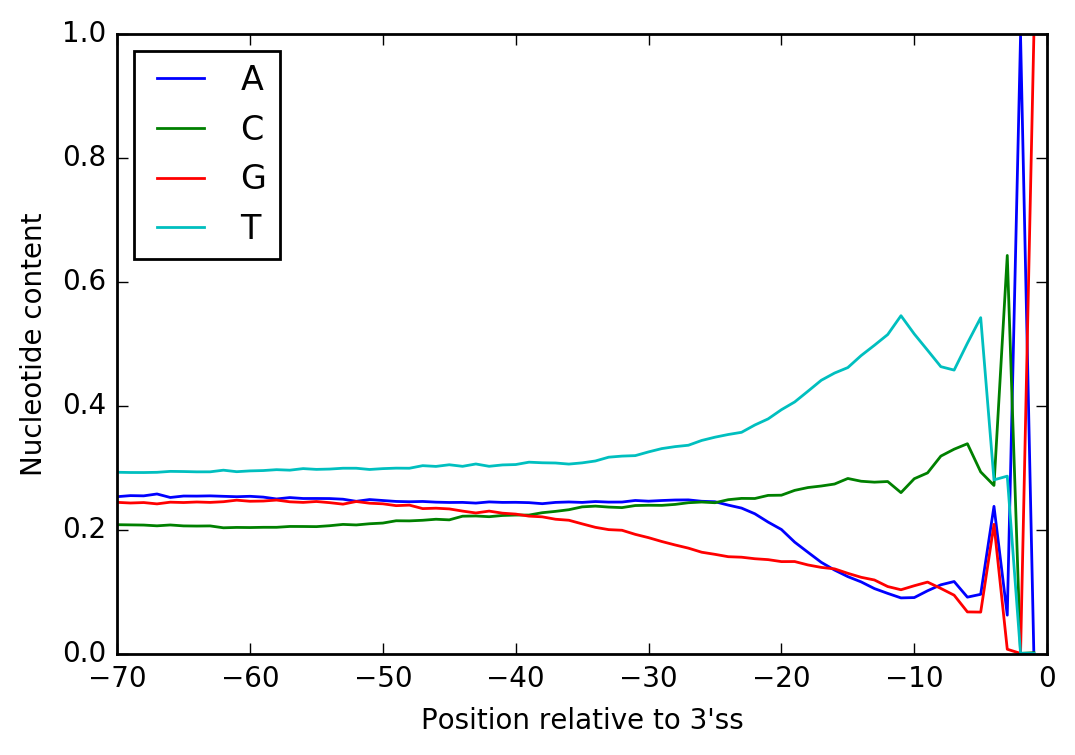

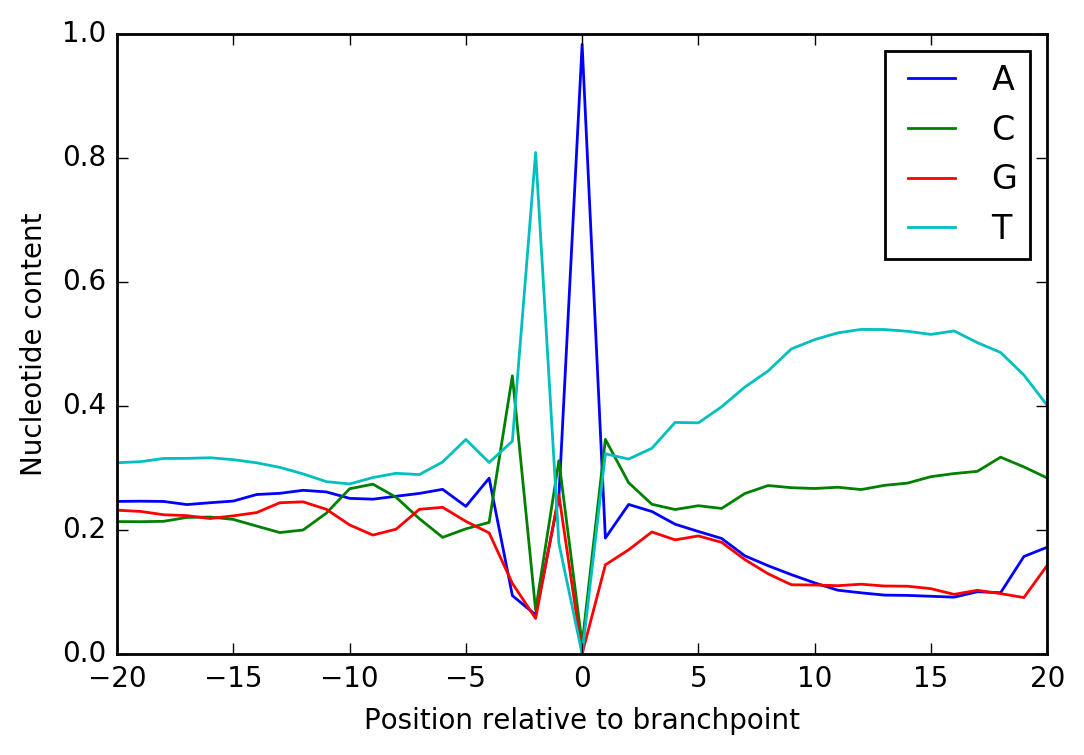

In [16]:
for i, base in enumerate(bases):
    plt.plot(range(-70, 0), X_all[:, :, i].mean(axis = 0), label = base)
plt.legend(loc='best')
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Nucleotide content')
plt.show()

K = 20
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1), cons_novel(X_all, y_all, i), label = base)
plt.legend(loc='best')
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Nucleotide content')
plt.show()

In [17]:
bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

from sklearn.utils import shuffle
shuffle_bps = []
for seq, bp in zip(X_all, np.argmax(shuffle(y_all),axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    shuffle_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
shuffle_bps = np.vstack(shuffle_bps)
print shuffle_bps.shape

(160785, 43, 4)
(160785, 43, 4)


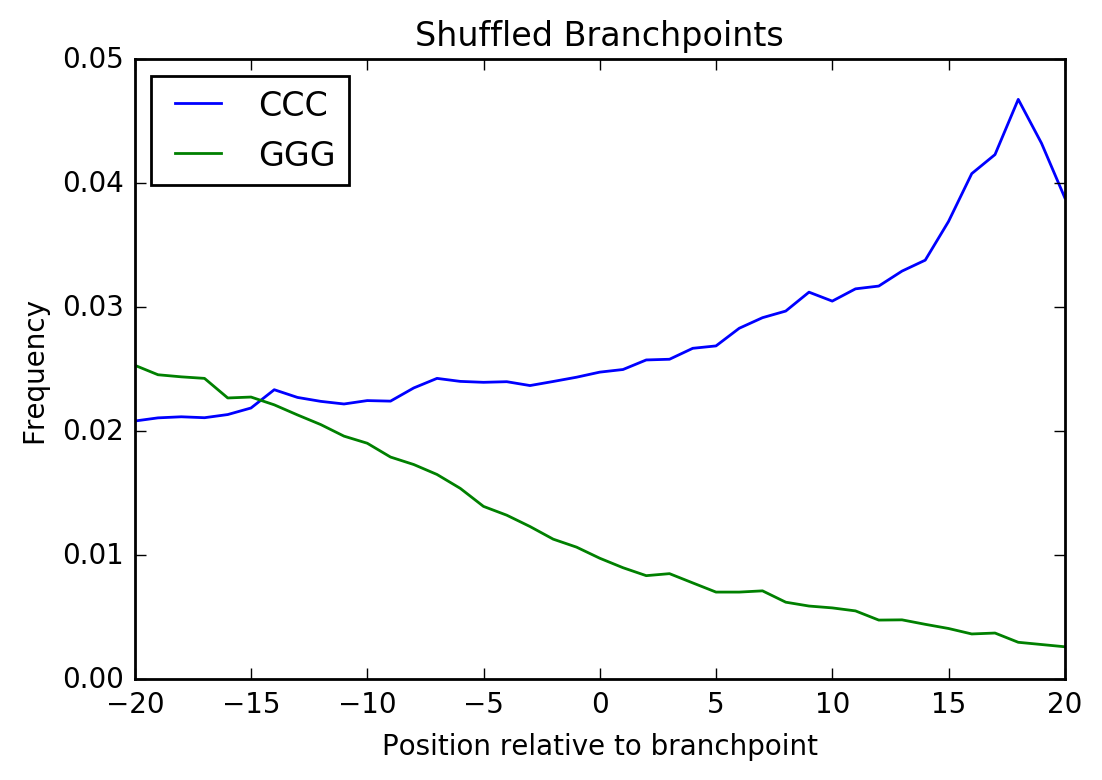

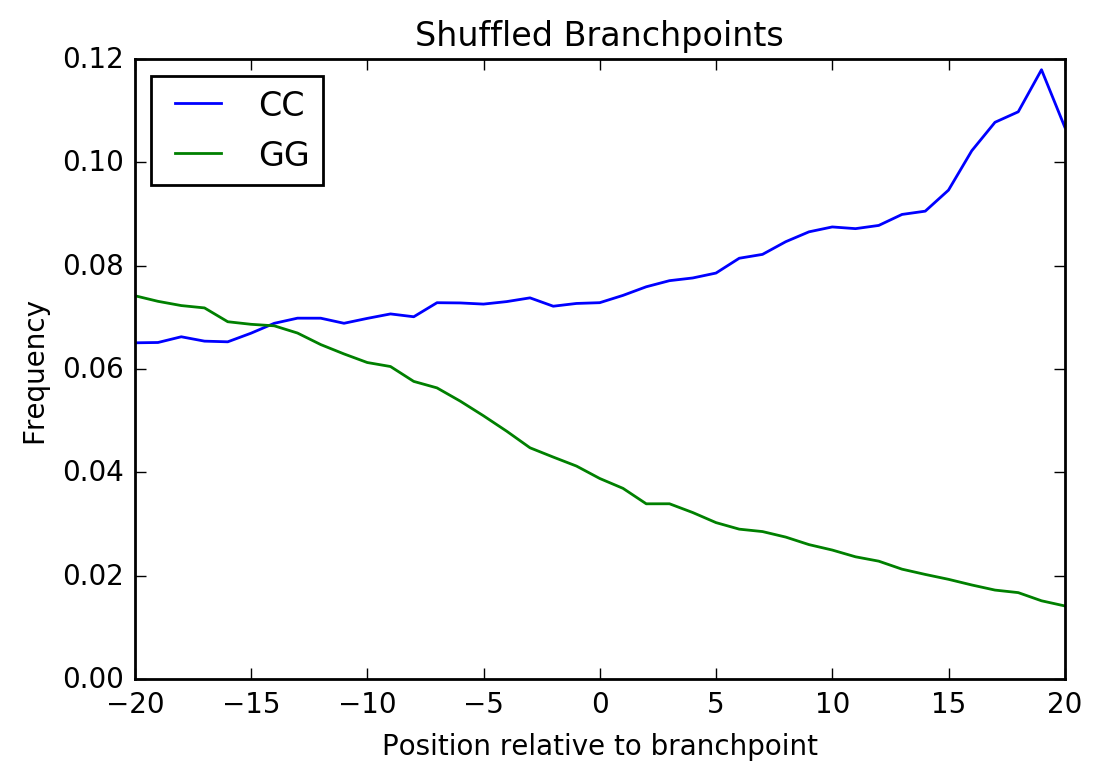

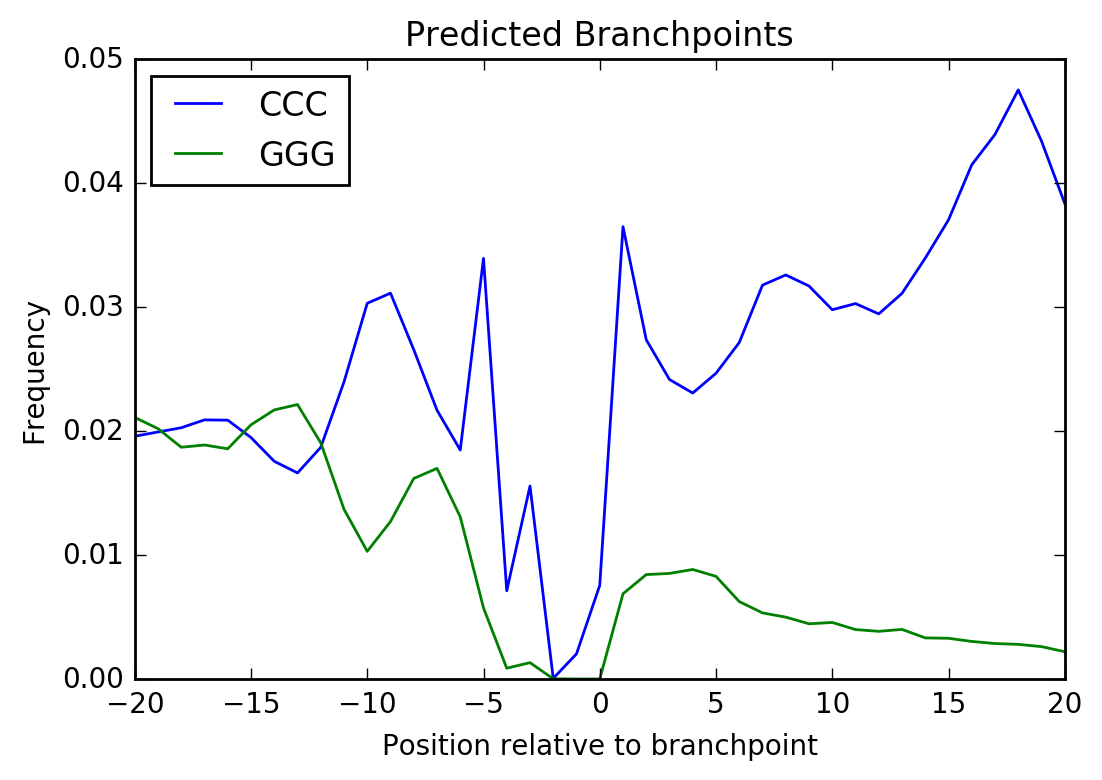

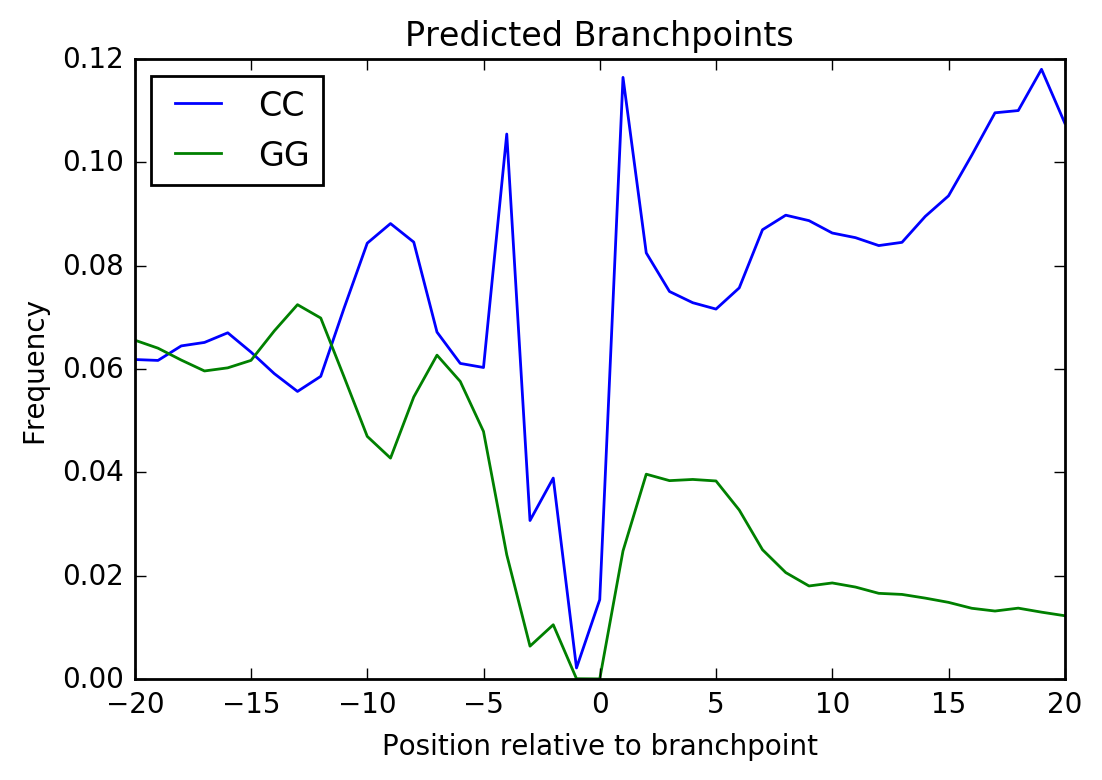

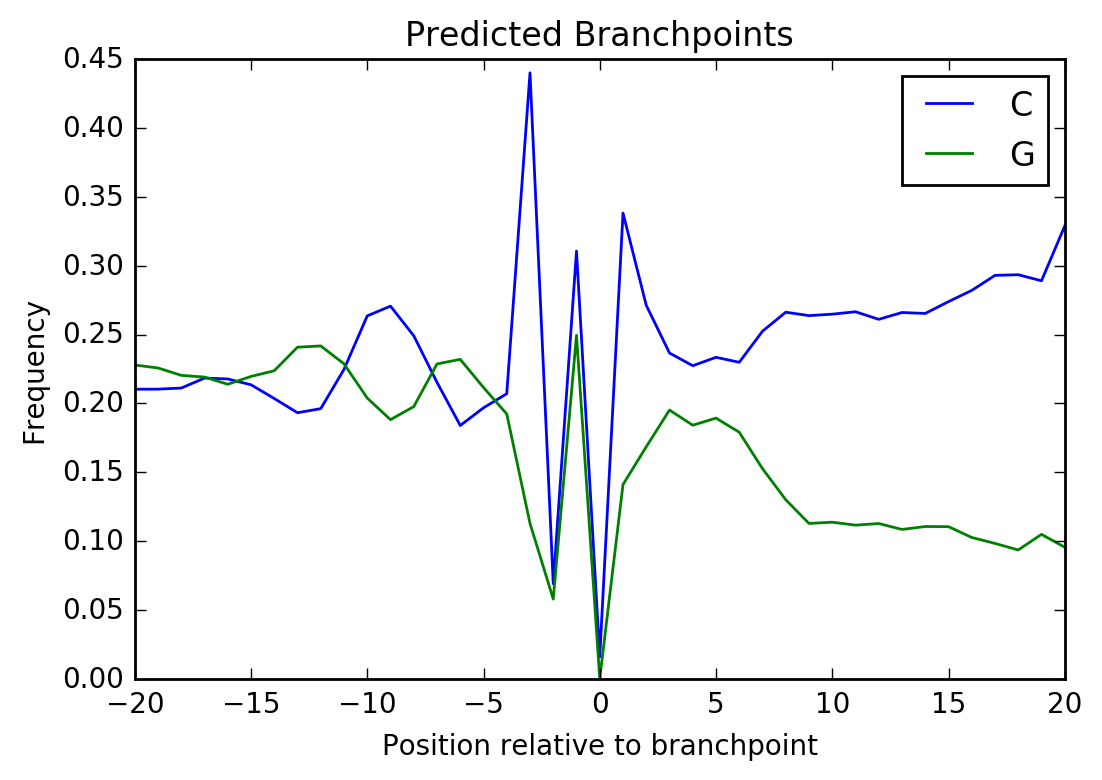

In [18]:
CCC = []
GGG = []
for i in range(41):
    CCC += [sum(shuffle_bps[:, i, 1]*shuffle_bps[:, i+1, 1]*shuffle_bps[:, i+2, 1])]
    GGG += [sum(shuffle_bps[:, i, 2]*shuffle_bps[:, i+1, 2]*shuffle_bps[:, i+2, 2])]
plt.plot(range(-20, 21),
         np.array(CCC) / float(bps.shape[0]),
         label = 'CCC')
plt.plot(range(-20, 21),
         np.array(GGG) / float(bps.shape[0]),
         label = 'GGG')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.legend(loc = 'best')
plt.title('Shuffled Branchpoints')
plt.show()
CC = []
GG = []
for i in range(41):
    CC += [sum(shuffle_bps[:, i, 1]*shuffle_bps[:, i+1, 1])]
    GG += [sum(shuffle_bps[:, i, 2]*shuffle_bps[:, i+1, 2])]
plt.plot(range(-20, 21),
         np.array(CC) / float(shuffle_bps.shape[0]),
         label = 'CC')
plt.plot(range(-20, 21),
         np.array(GG) / float(shuffle_bps.shape[0]),
         label = 'GG')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Shuffled Branchpoints')
plt.show()

CCC = []
GGG = []
for i in range(41):
    CCC += [sum(bps[:, i, 1]*bps[:, i+1, 1]*bps[:, i+2, 1])]
    GGG += [sum(bps[:, i, 2]*bps[:, i+1, 2]*bps[:, i+2, 2])]
plt.plot(range(-20, 21),
         np.array(CCC) / float(bps.shape[0]),
         label = 'CCC')
plt.plot(range(-20, 21),
         np.array(GGG) / float(bps.shape[0]),
         label = 'GGG')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.legend(loc = 'best')
plt.title('Predicted Branchpoints')
plt.show()
CC = []
GG = []
for i in range(41):
    CC += [sum(bps[:, i, 1]*bps[:, i+1, 1])]
    GG += [sum(bps[:, i, 2]*bps[:, i+1, 2])]
plt.plot(range(-20, 21),
         np.array(CC) / float(bps.shape[0]),
         label = 'CC')
plt.plot(range(-20, 21),
         np.array(GG) / float(bps.shape[0]),
         label = 'GG')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Predicted Branchpoints')
plt.show()

C = []
G = []
for i in range(41):
    C += [sum(bps[:, i, 1])]
    G += [sum(bps[:, i, 2])]
plt.plot(range(-20, 21),
         np.array(C) / float(bps.shape[0]),
         label = 'C')
plt.plot(range(-20, 21),
         np.array(G) / float(bps.shape[0]),
         label = 'G')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Predicted Branchpoints')
plt.show()

44922


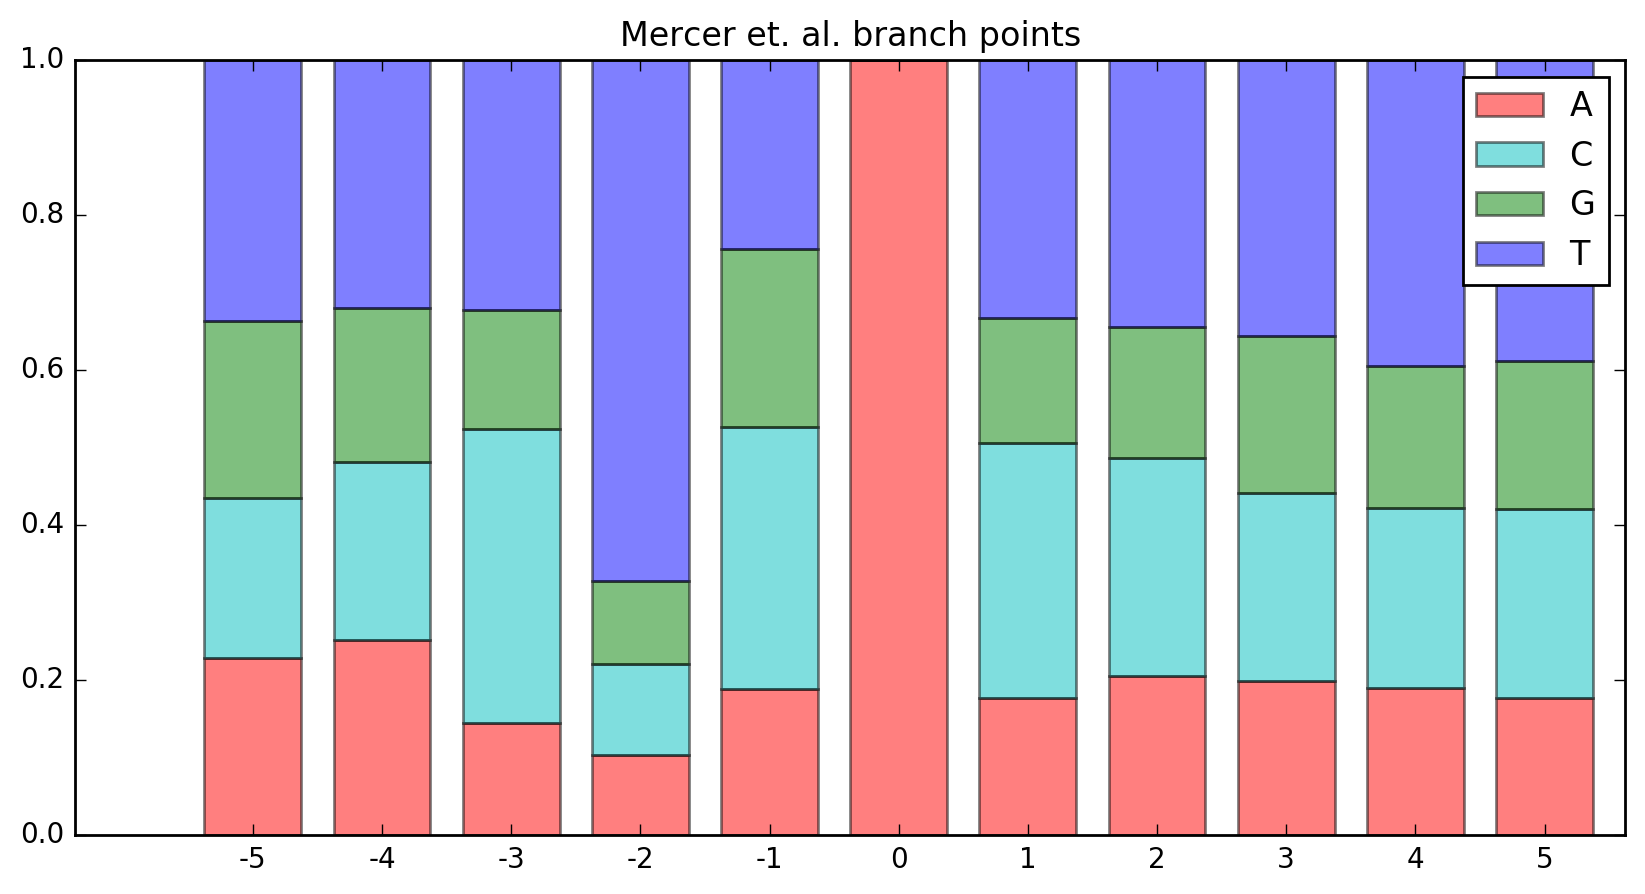

4840


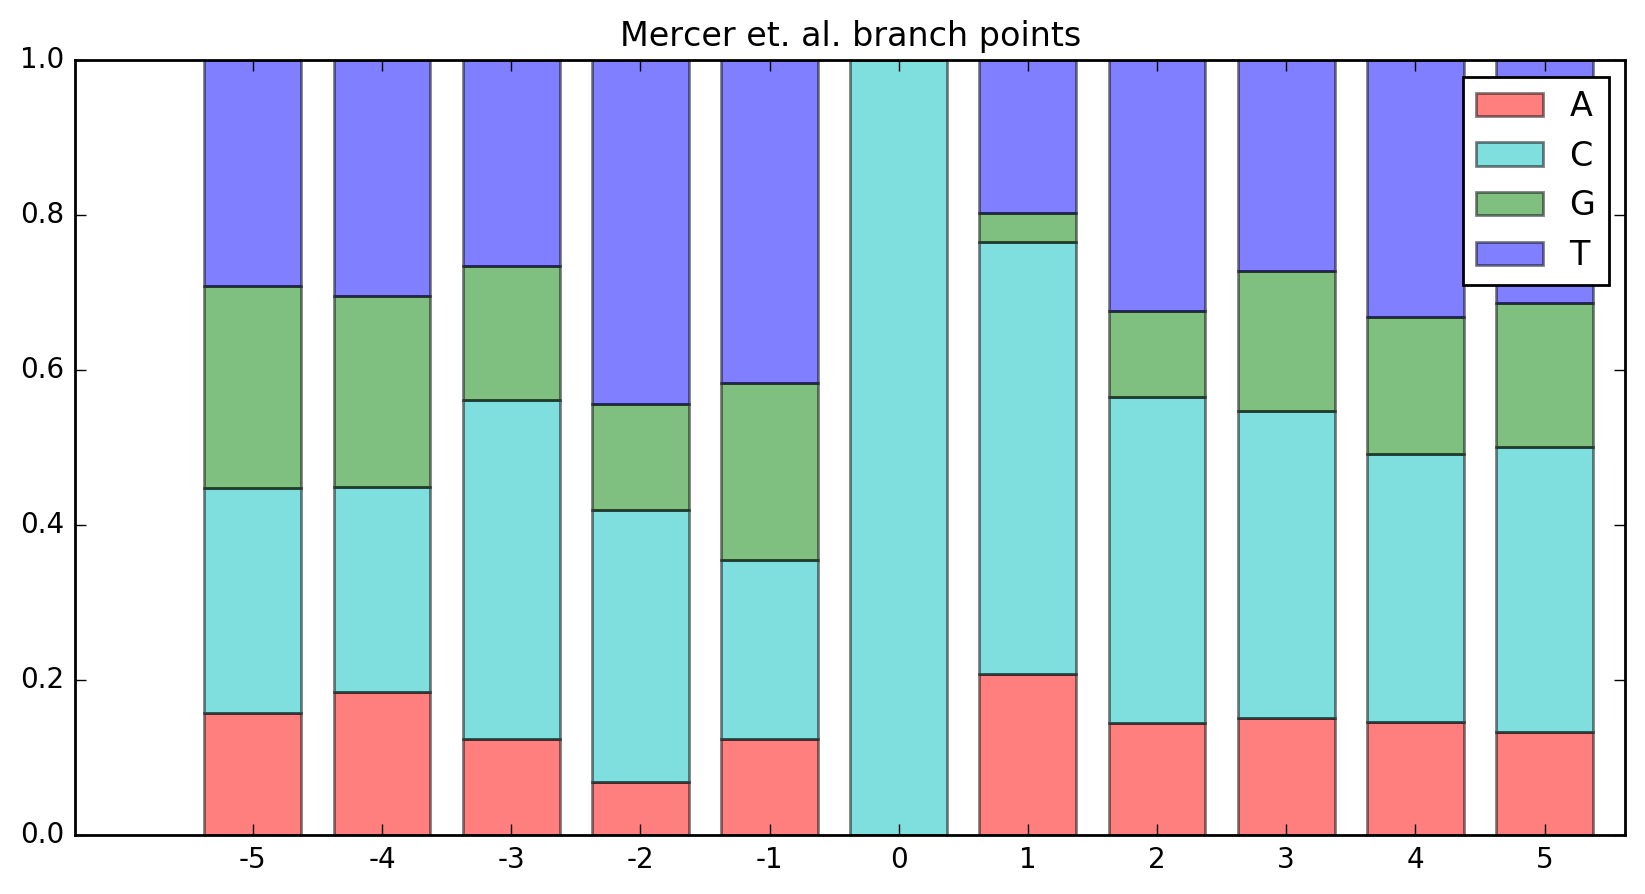

2439


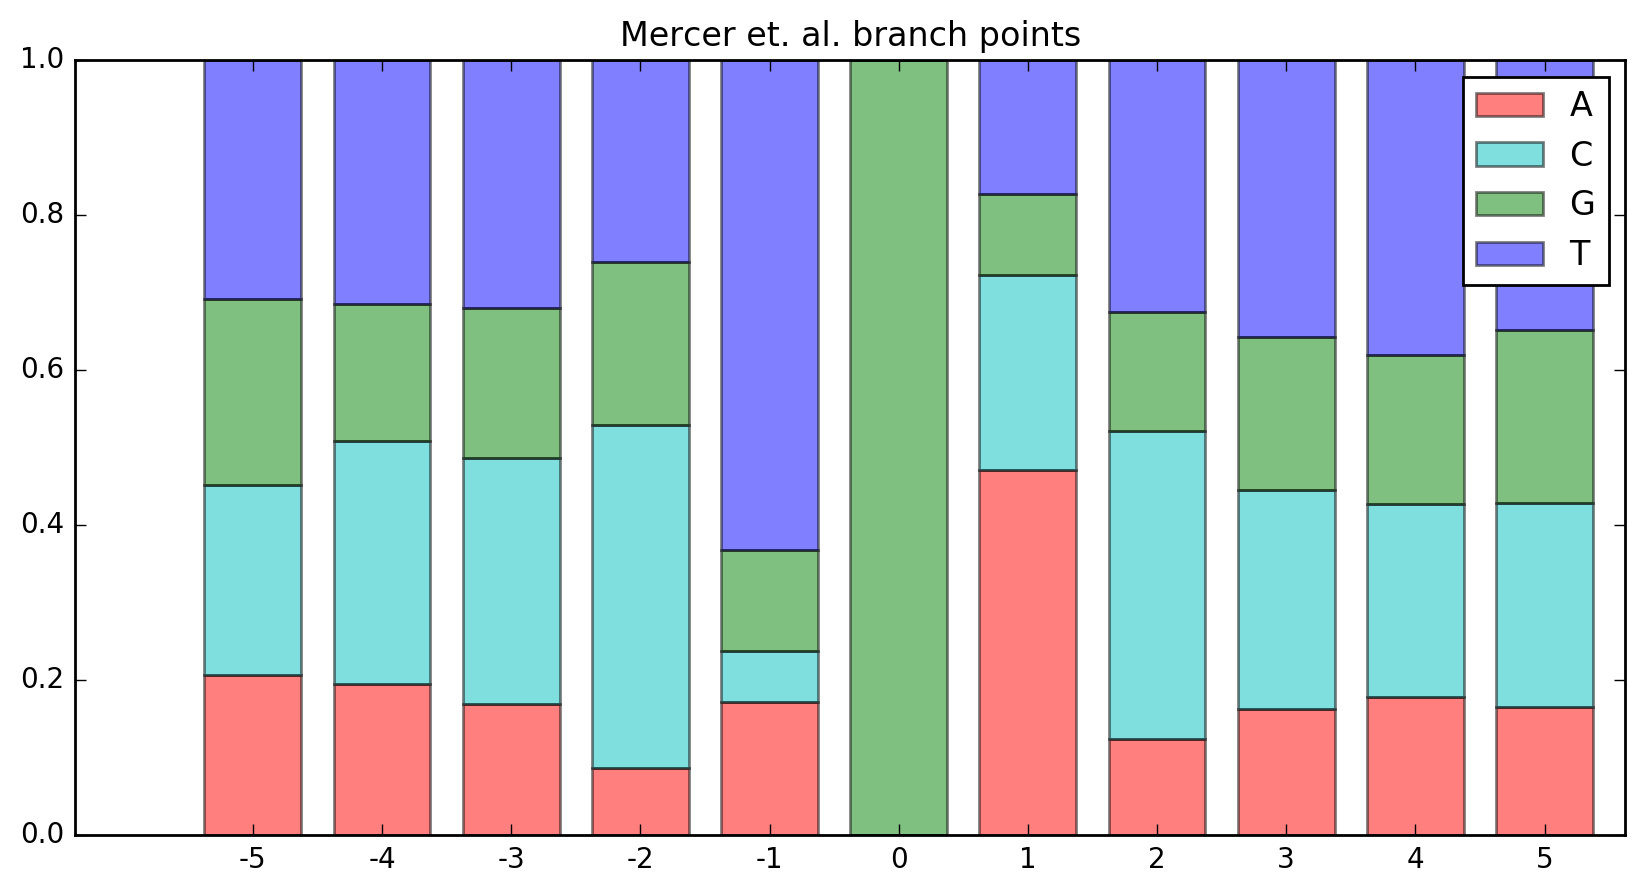

4607


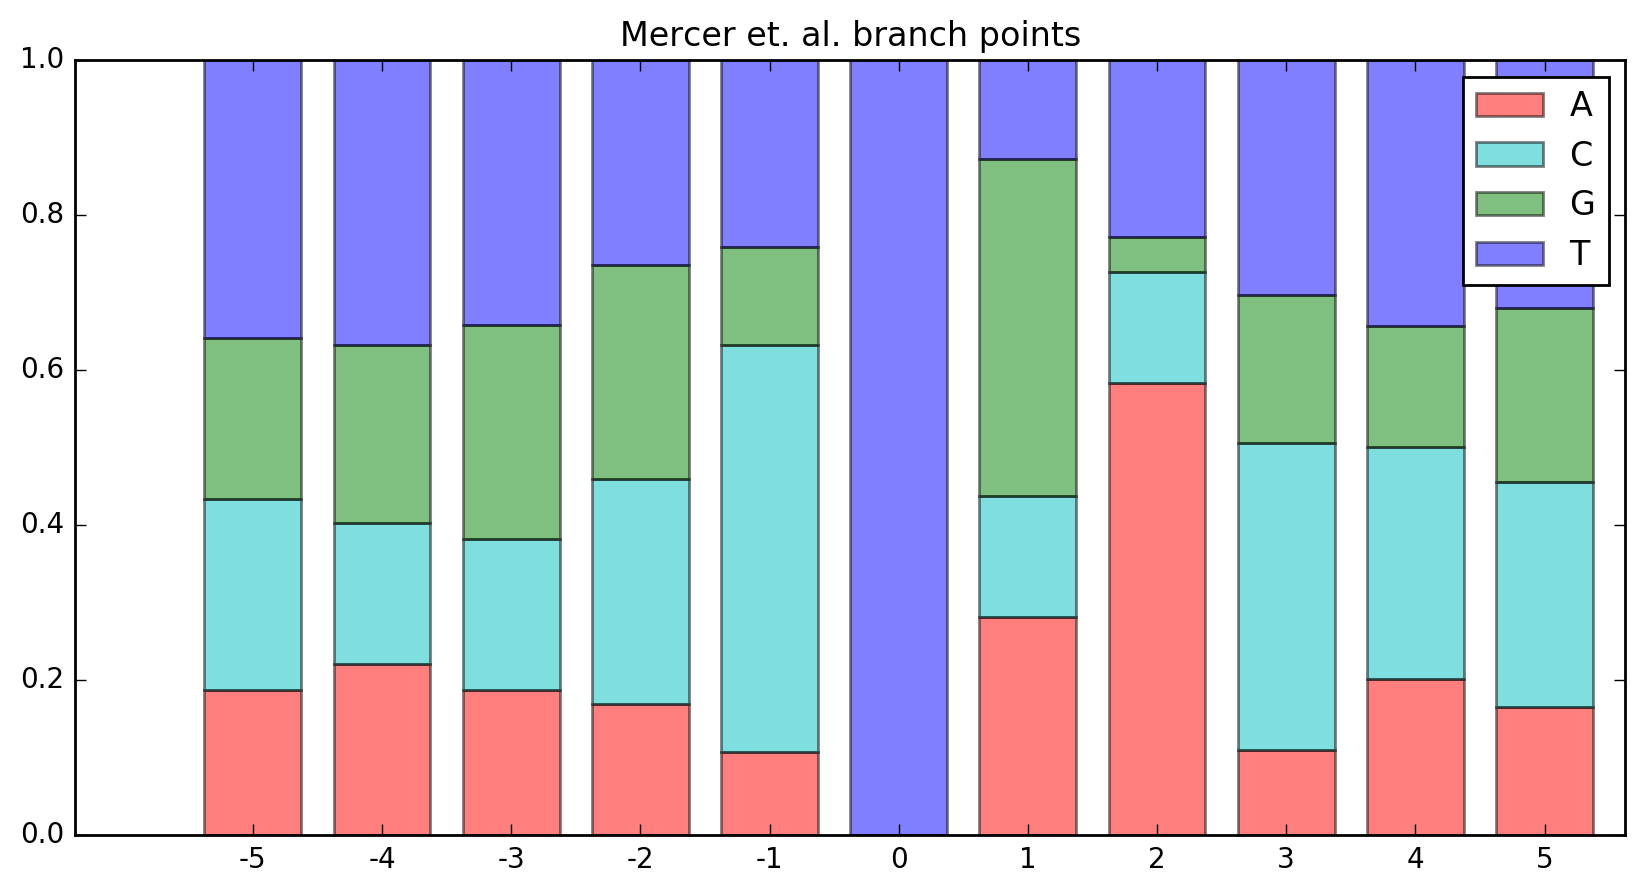

In [19]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_known, X_known):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, i]: continue
            counts += seq[bp-K: bp+K+1, :4]
            total += 1
    print total
    pwm_logo(counts / total, names[0])

202799


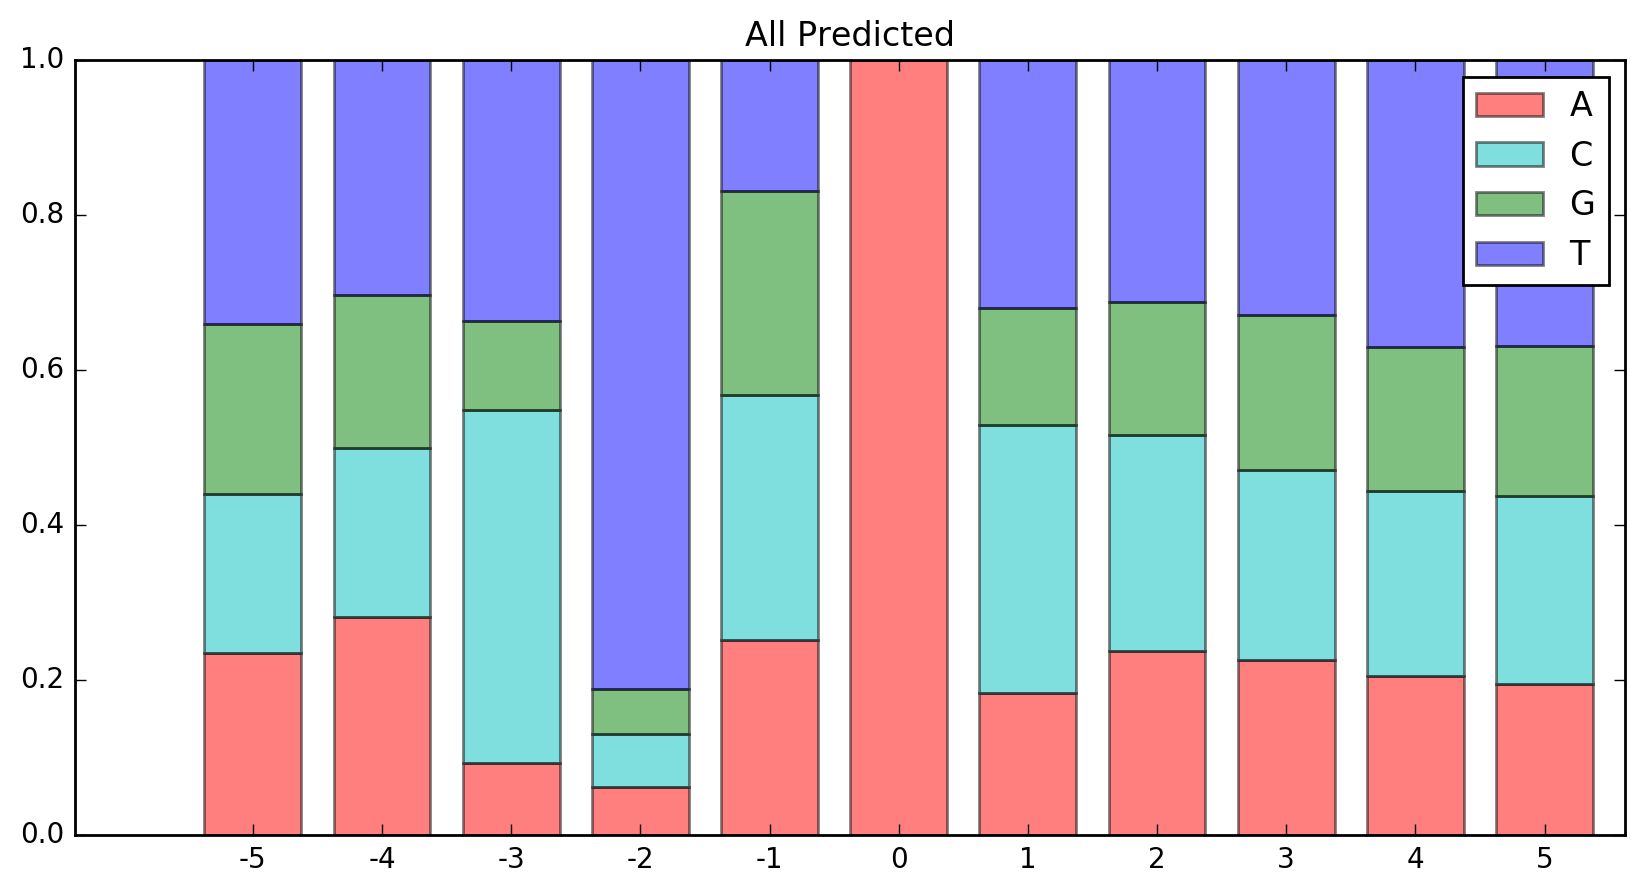

3351


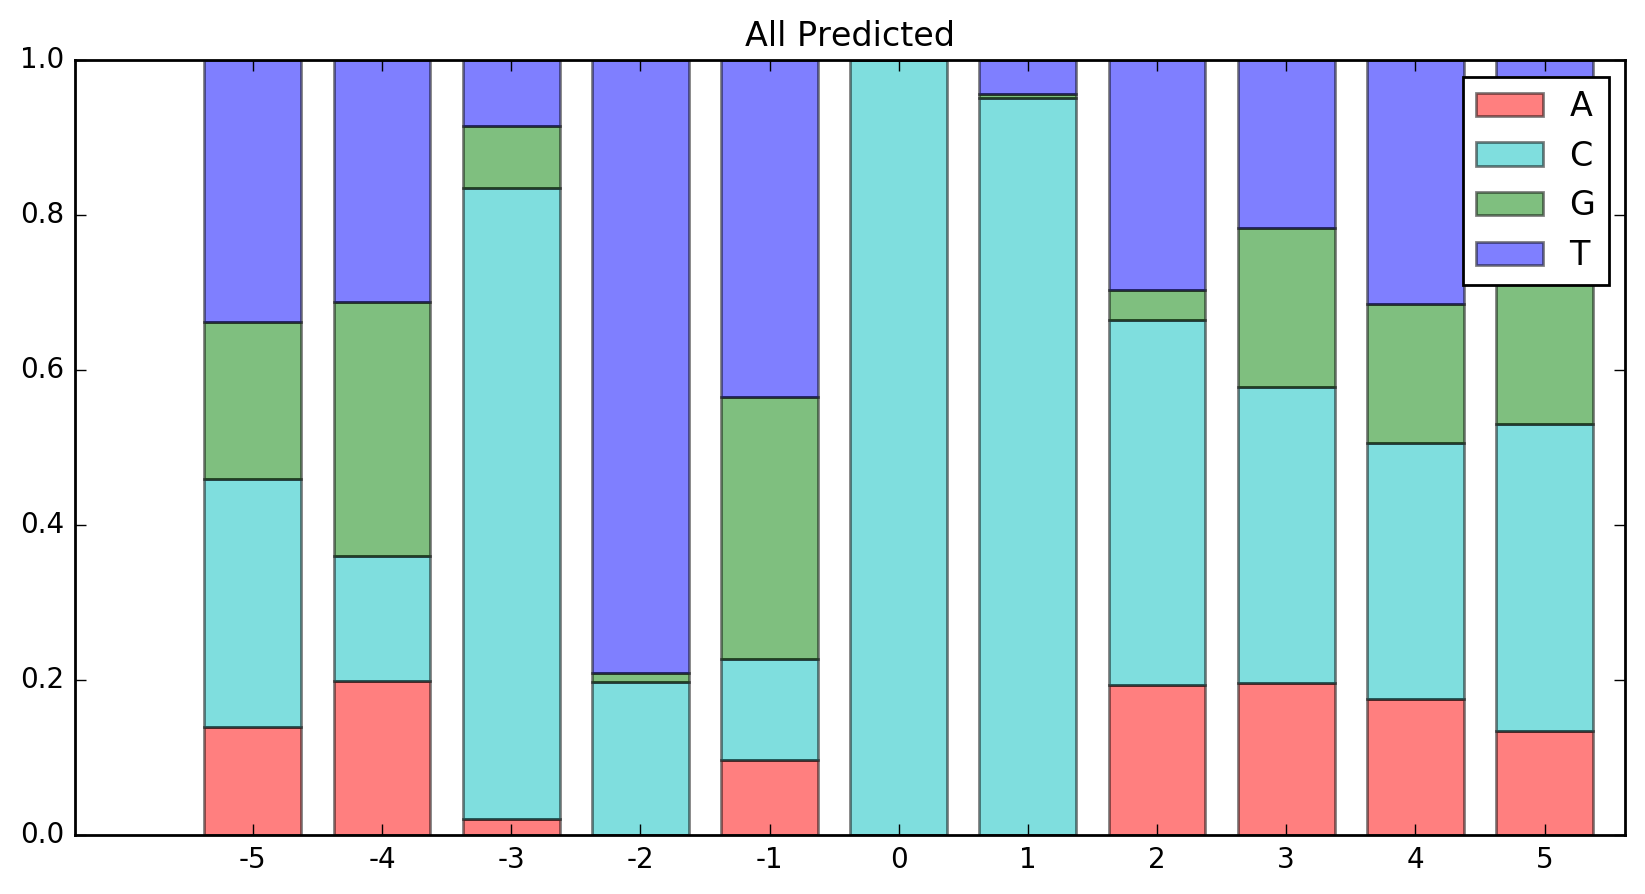

57


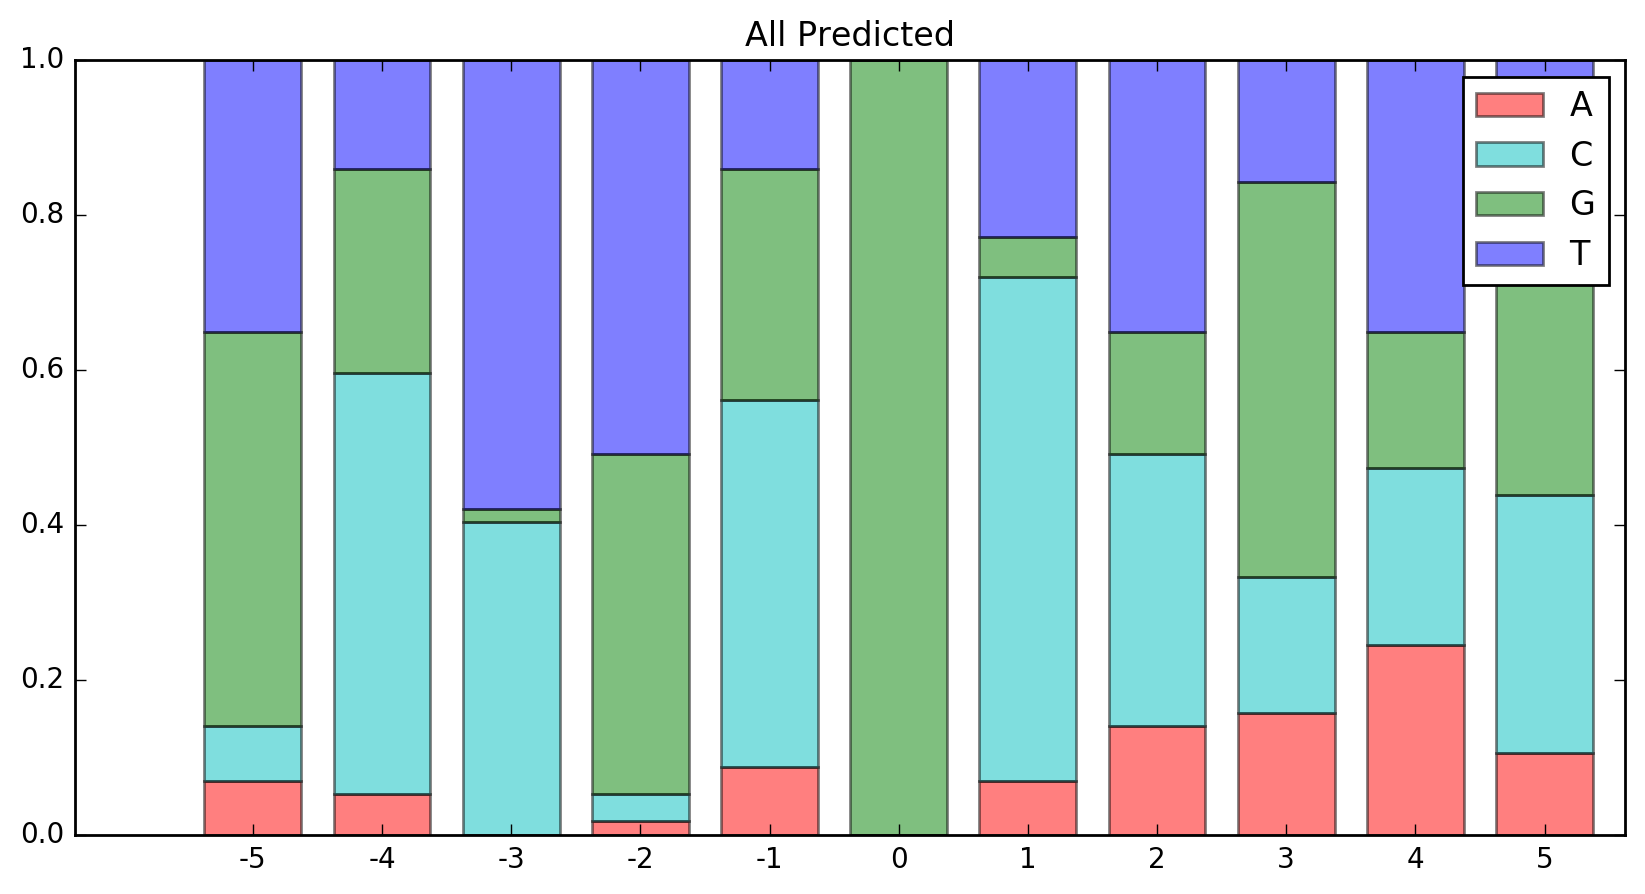

69


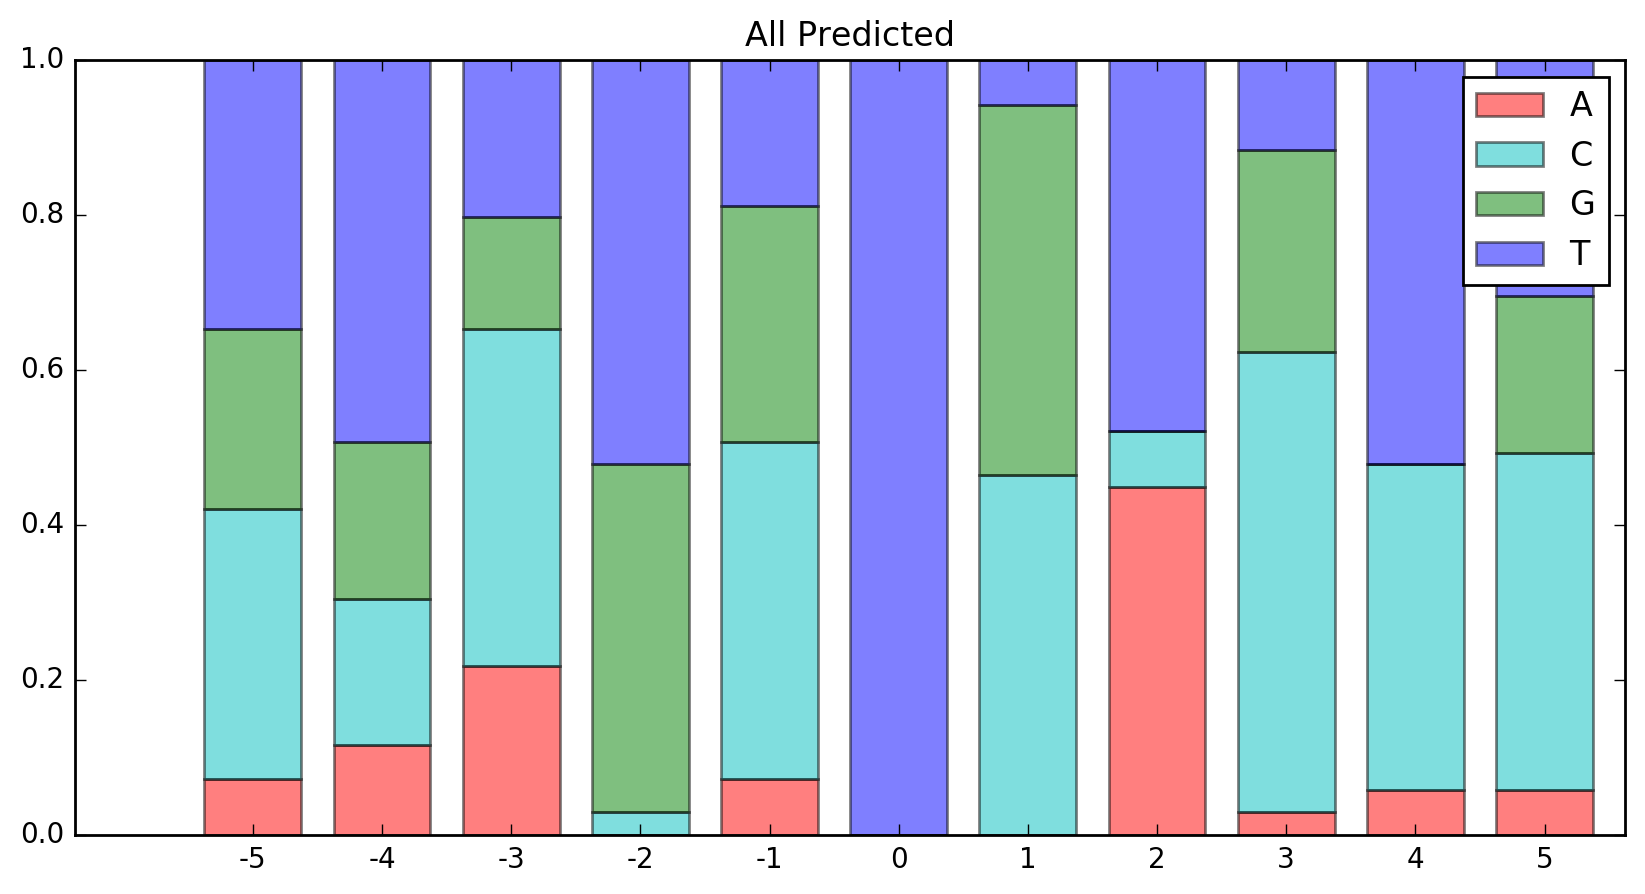

167355


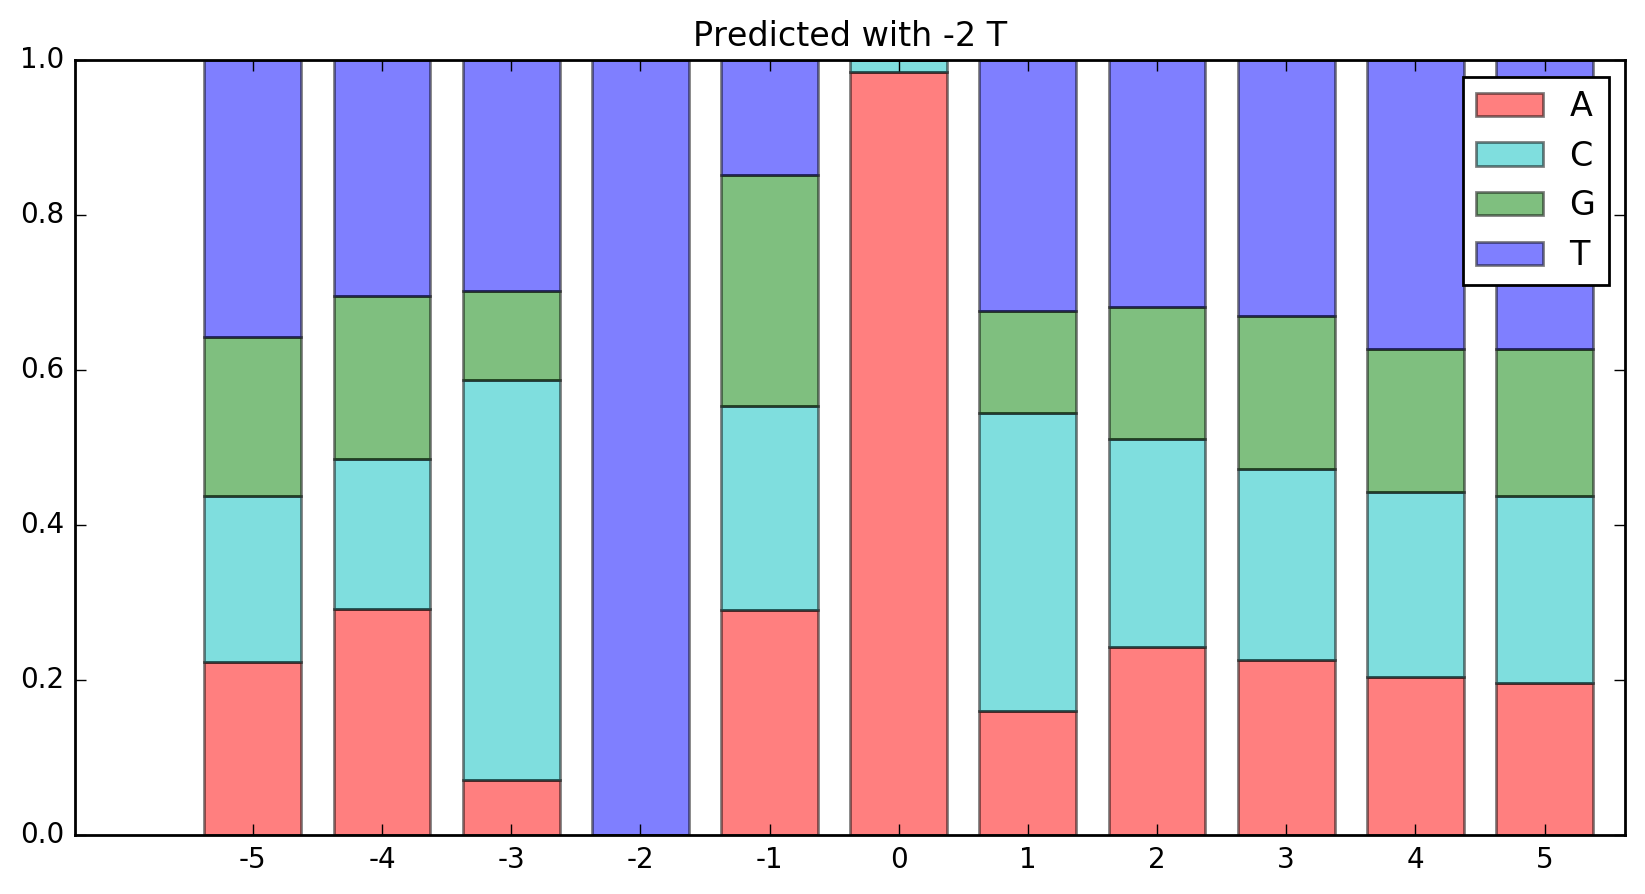

38921


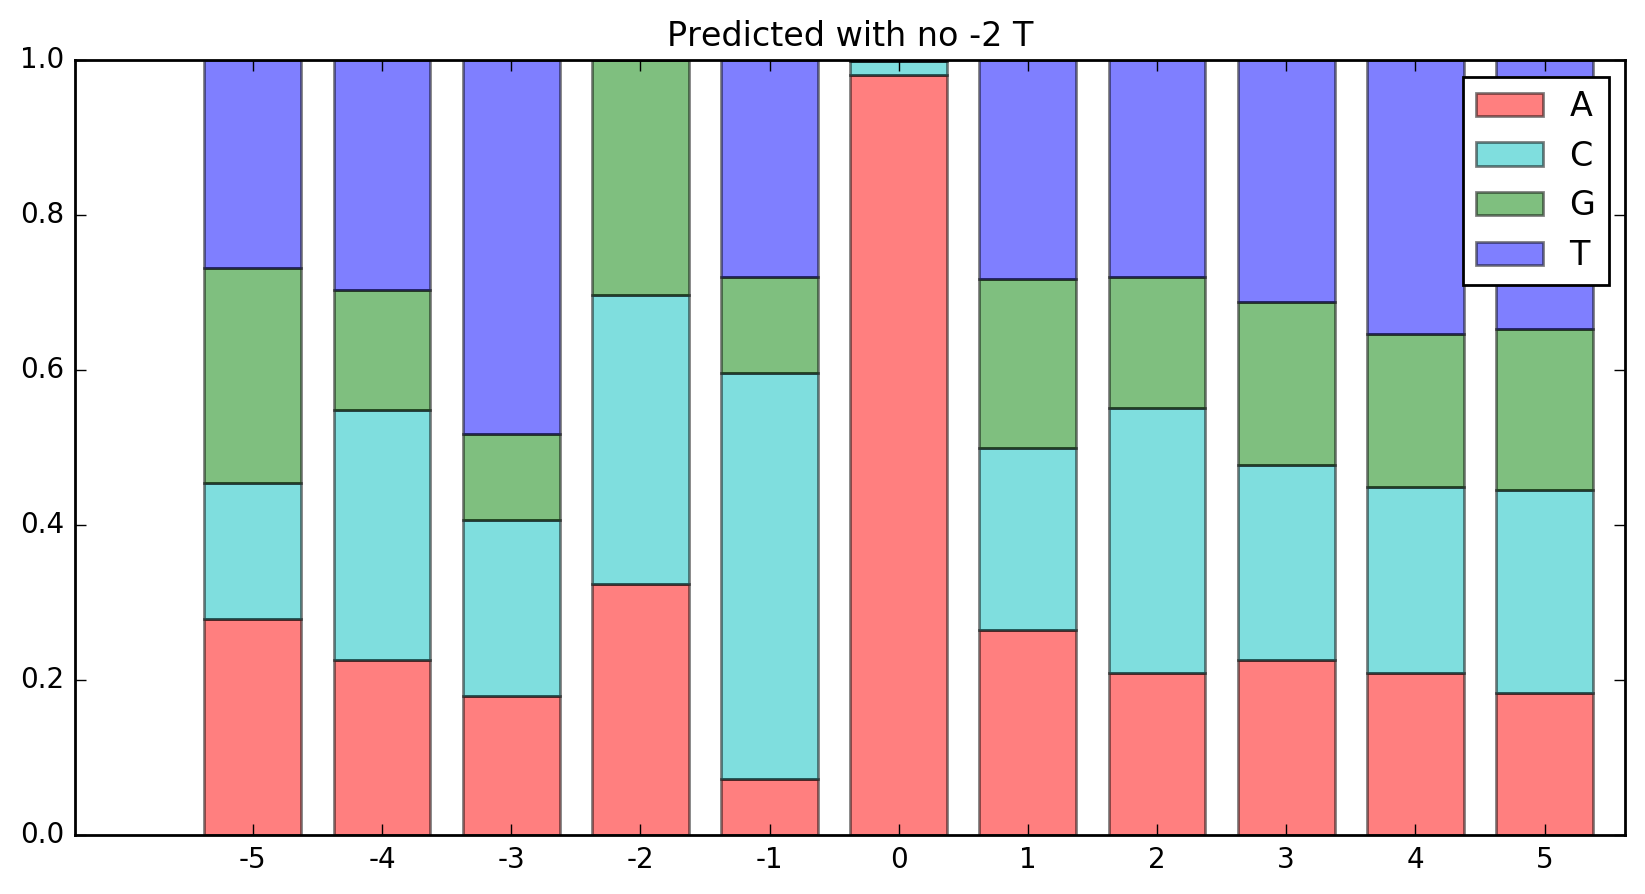

In [20]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_all, X_all):
        bp = np.argmax(target)
        if not seq[bp, i]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    print total
    pwm_logo(counts / total, 'All Predicted')

# -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'Predicted with -2 T')
# No -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'Predicted with no -2 T')

In [21]:
bps = []
con = []
gen = []
for seq, bp, gene in zip(X_all, np.argmax(y_all,axis = 1), a_coords):
    if bp-10 < 0 or bp+11 > L: continue
    bps += [seq[bp-5:bp+6, :4].flatten()]
    con += [seq[bp-10:bp+11, 4:].reshape(1, 21, 3)]
    gen += [gene]
bps = np.vstack(bps)
con = np.vstack(con)
gen = np.array(gen)
print bps.shape, con.shape, gen.shape

(206022, 44) (206022, 21, 3) (206022,)


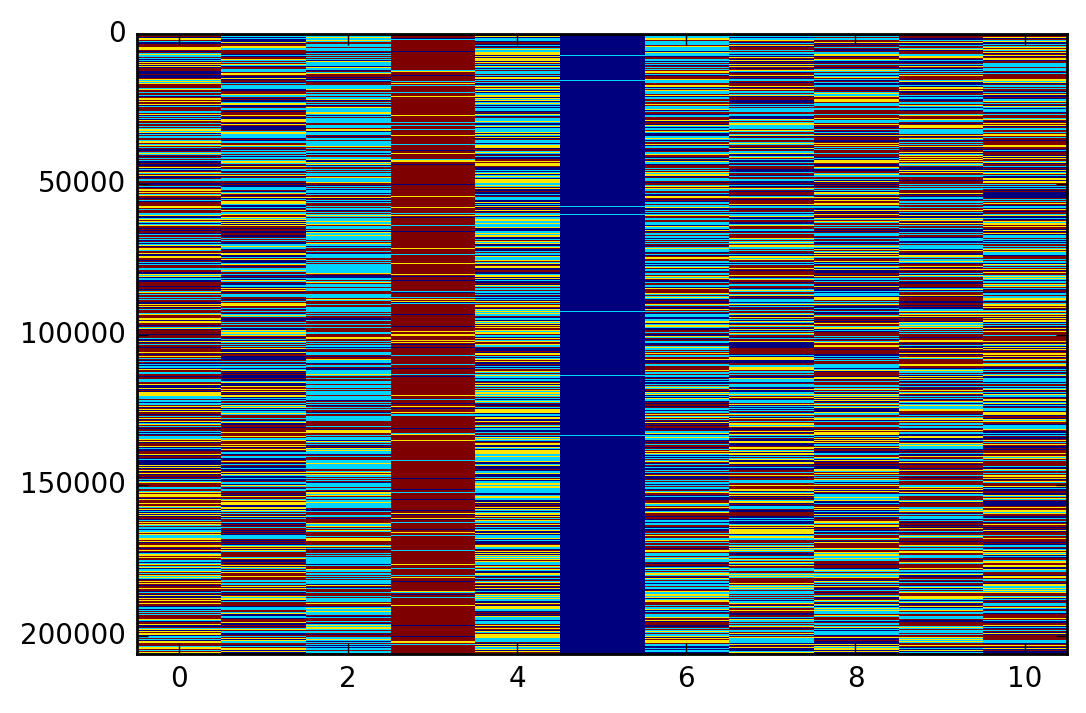

In [22]:
def color(x):
    out = []
    for i in range(0, x.shape[0], 4):
        out += [np.argmax(x[i:i+4])]
    return out
plt.imshow(np.vstack(map(color, bps)), aspect = 'auto', interpolation = 'nearest')
plt.show()

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 6).fit(bps)

(35739, 44)


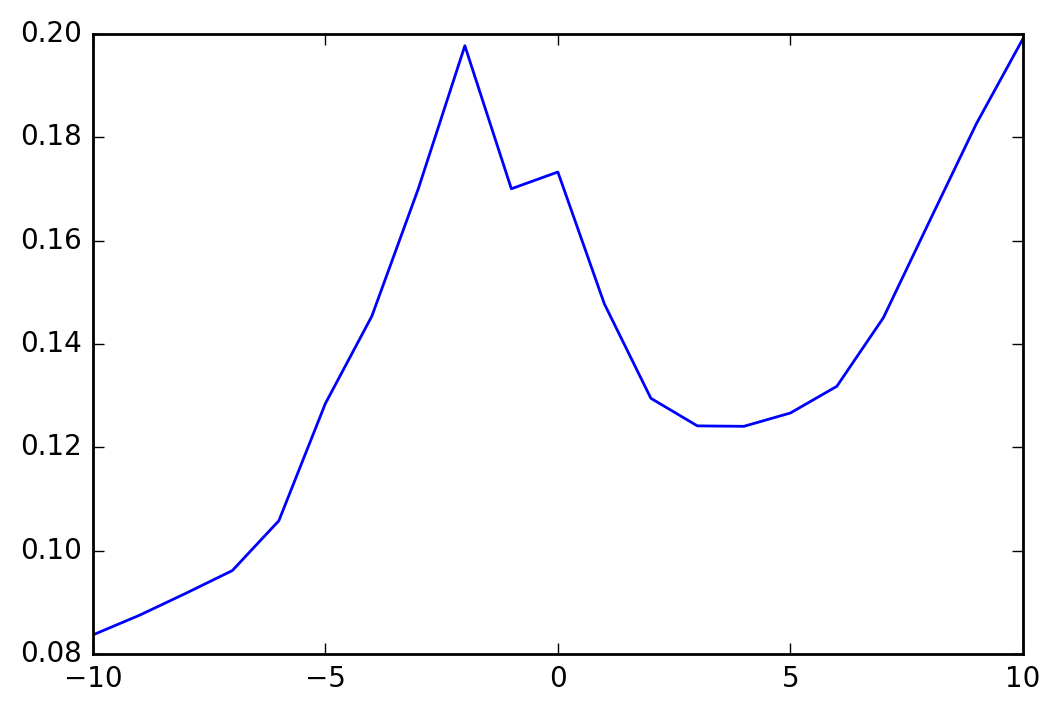

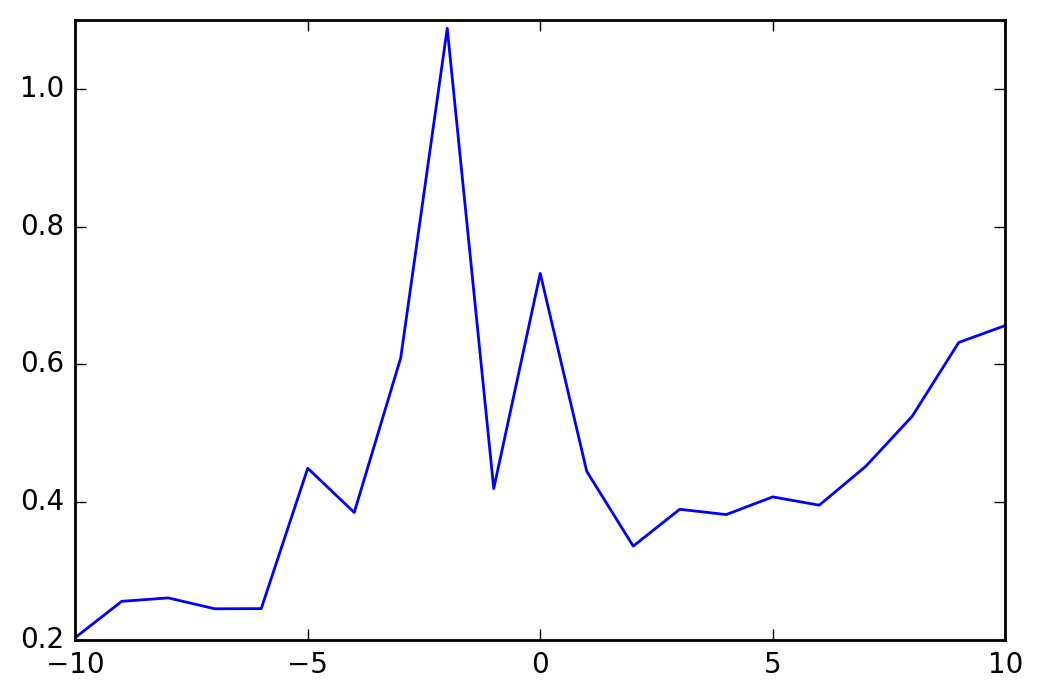

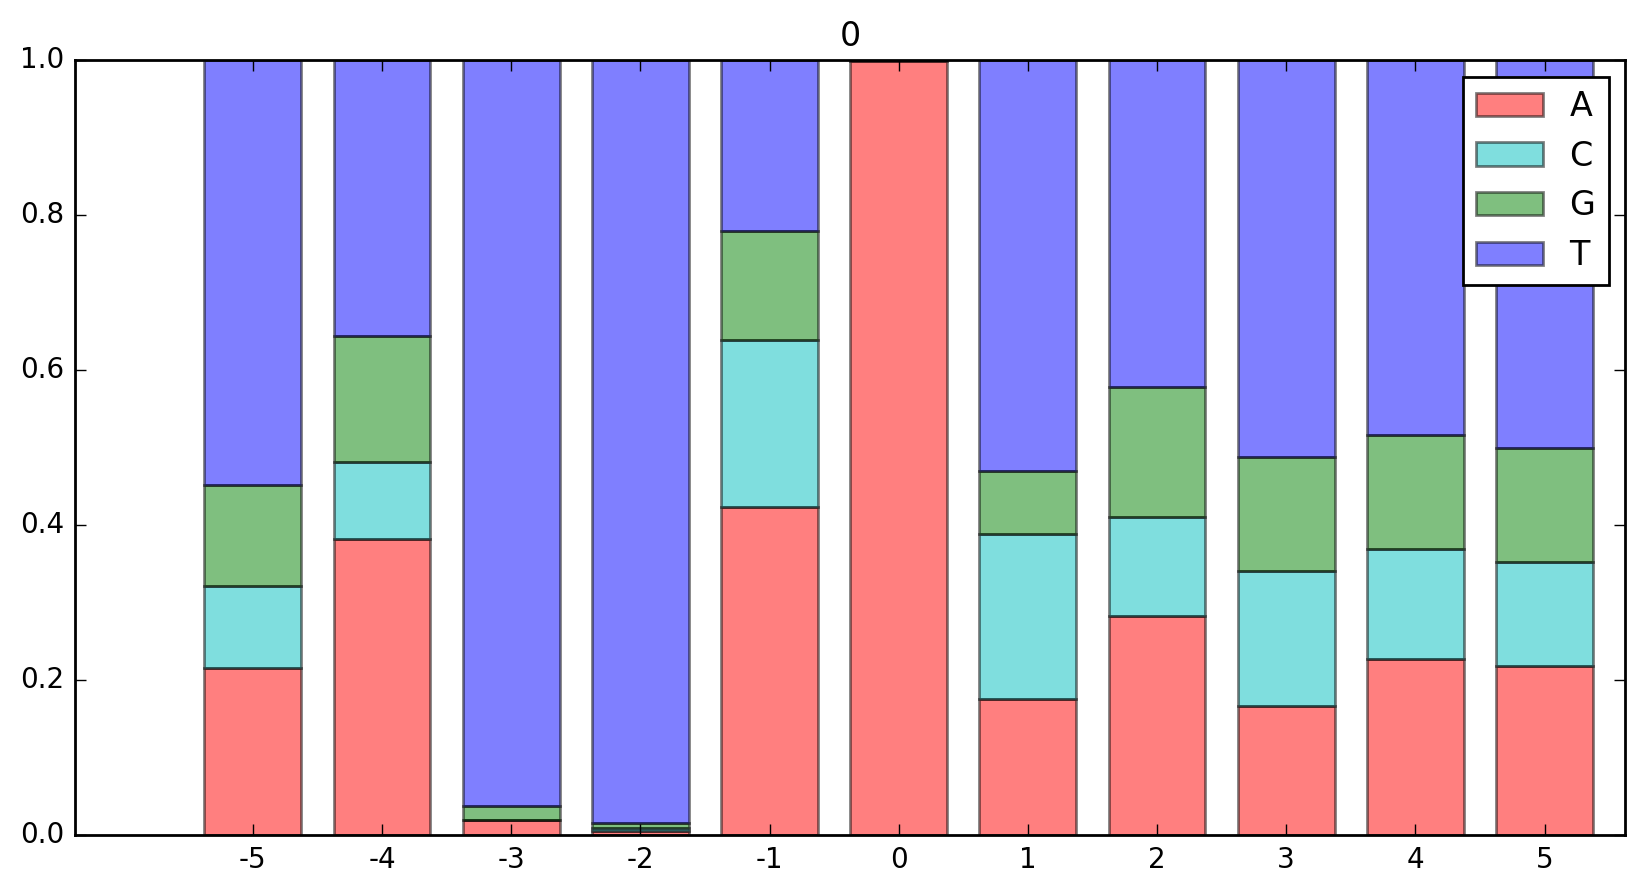

(30415, 44)


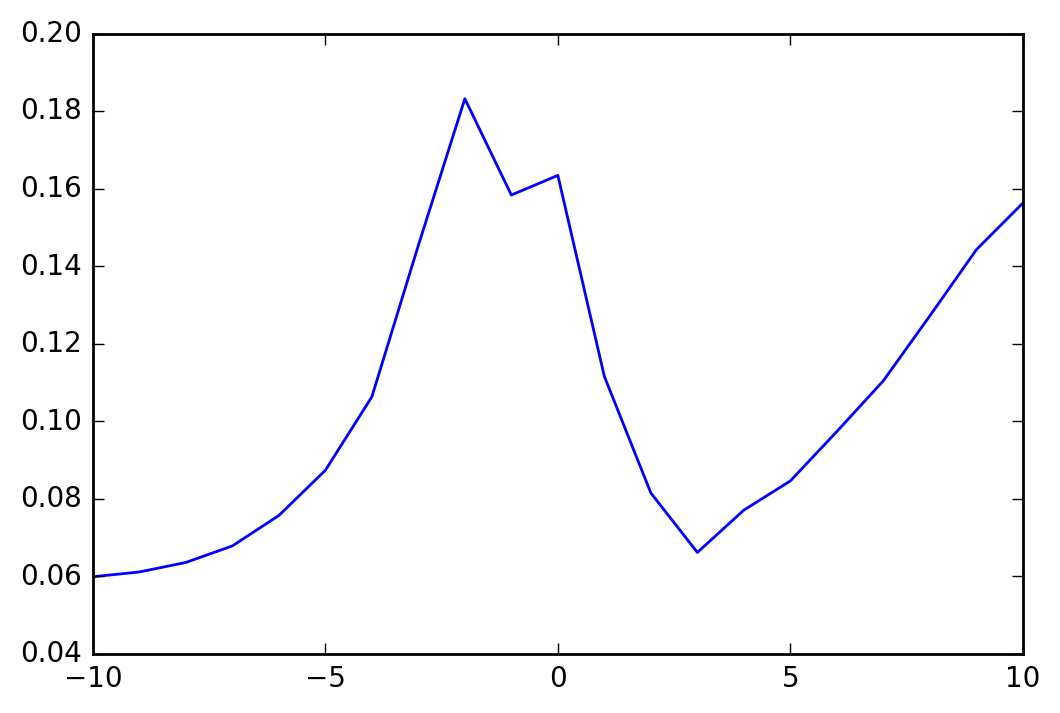

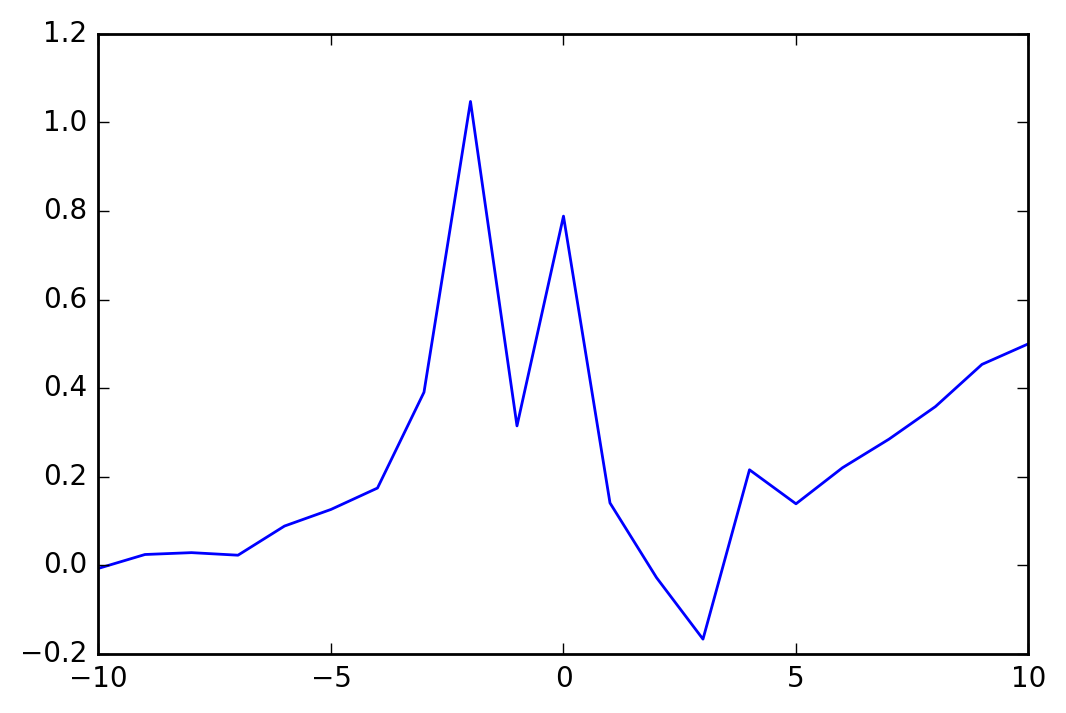

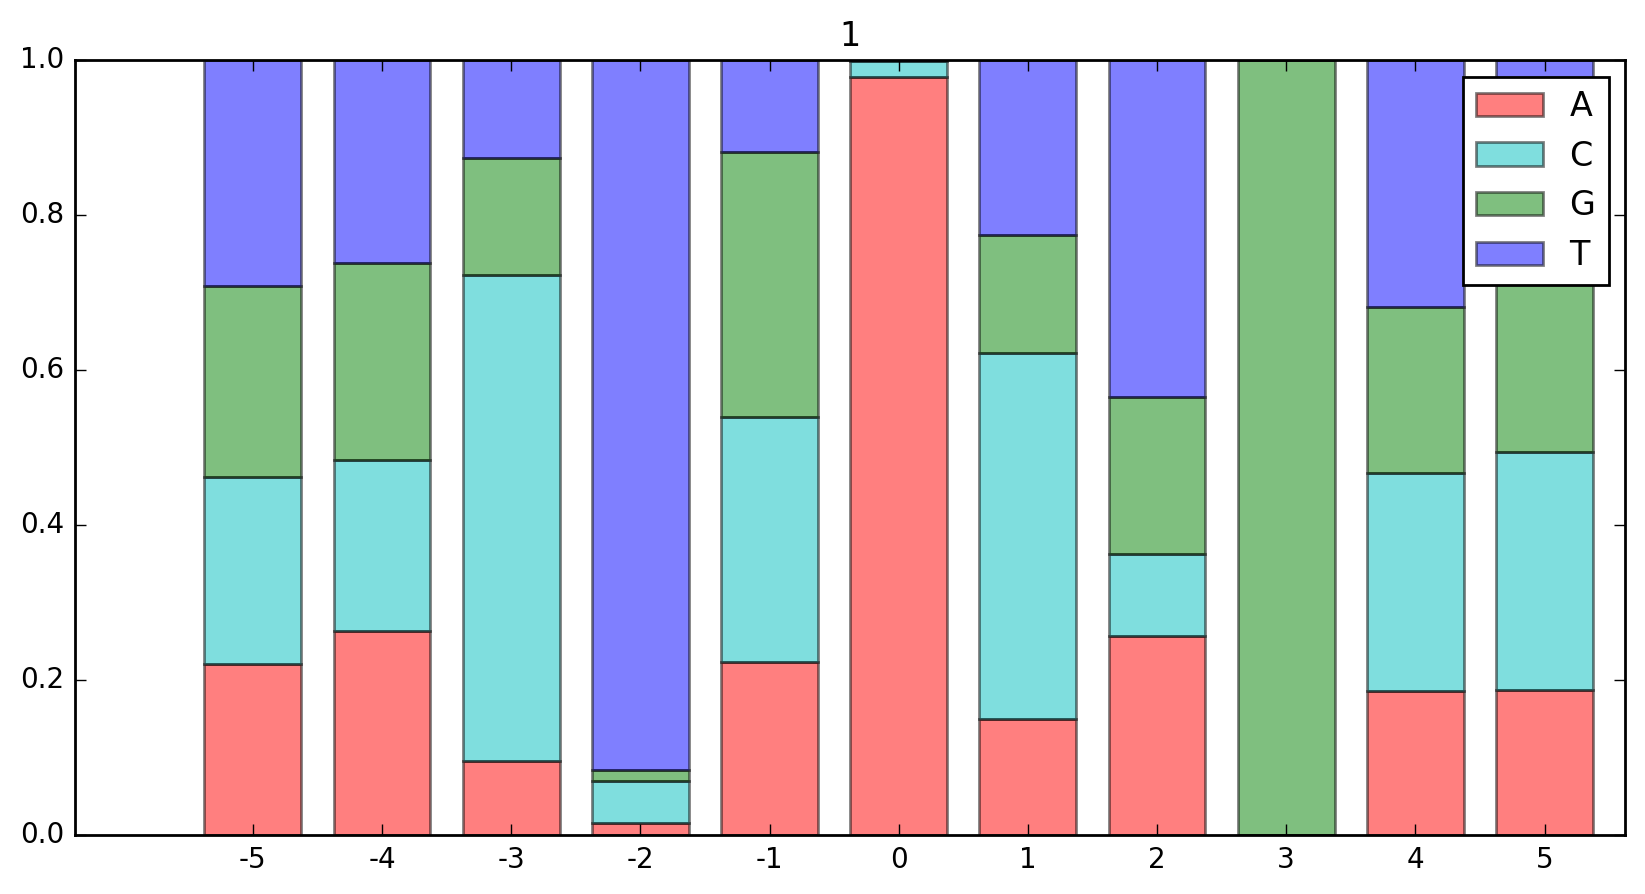

(38474, 44)


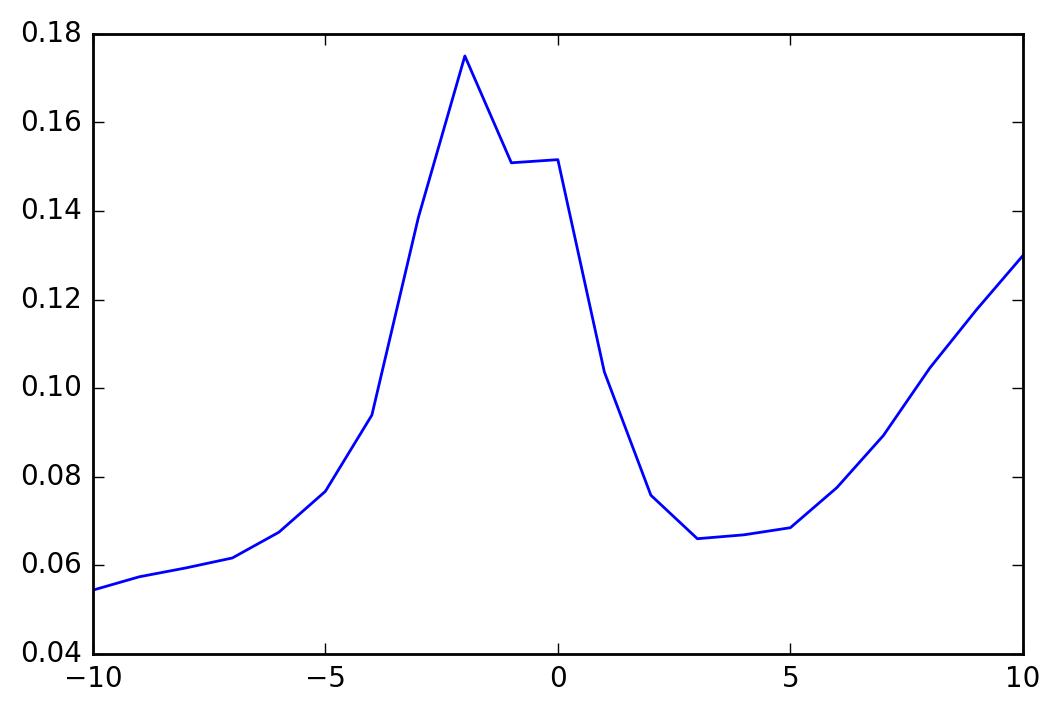

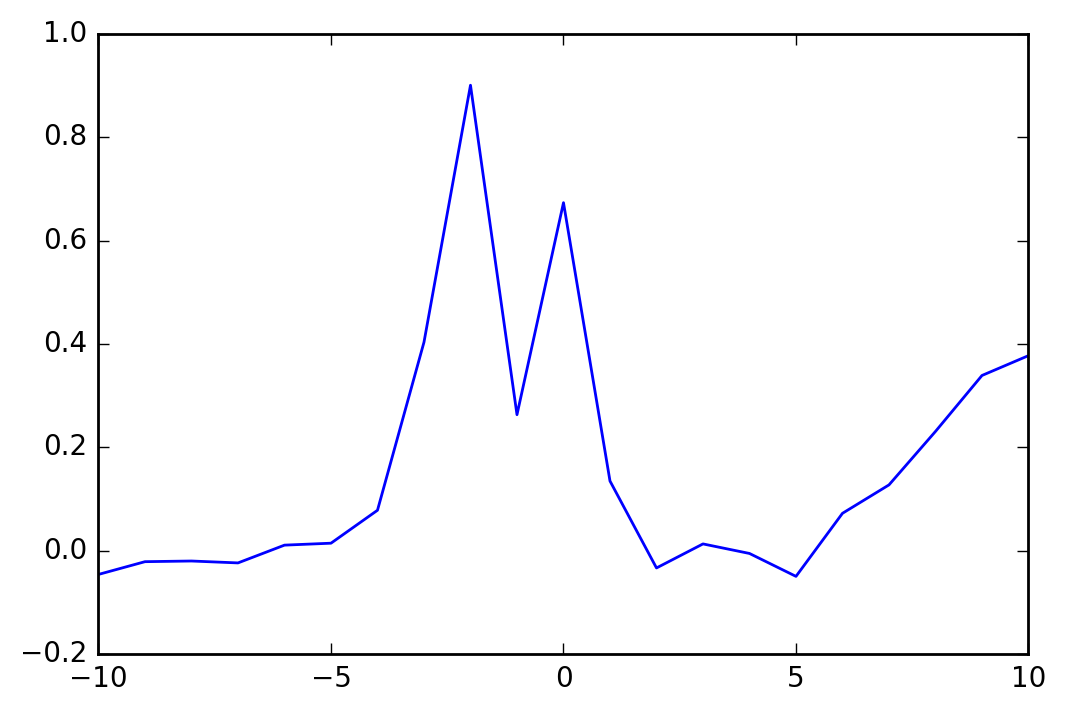

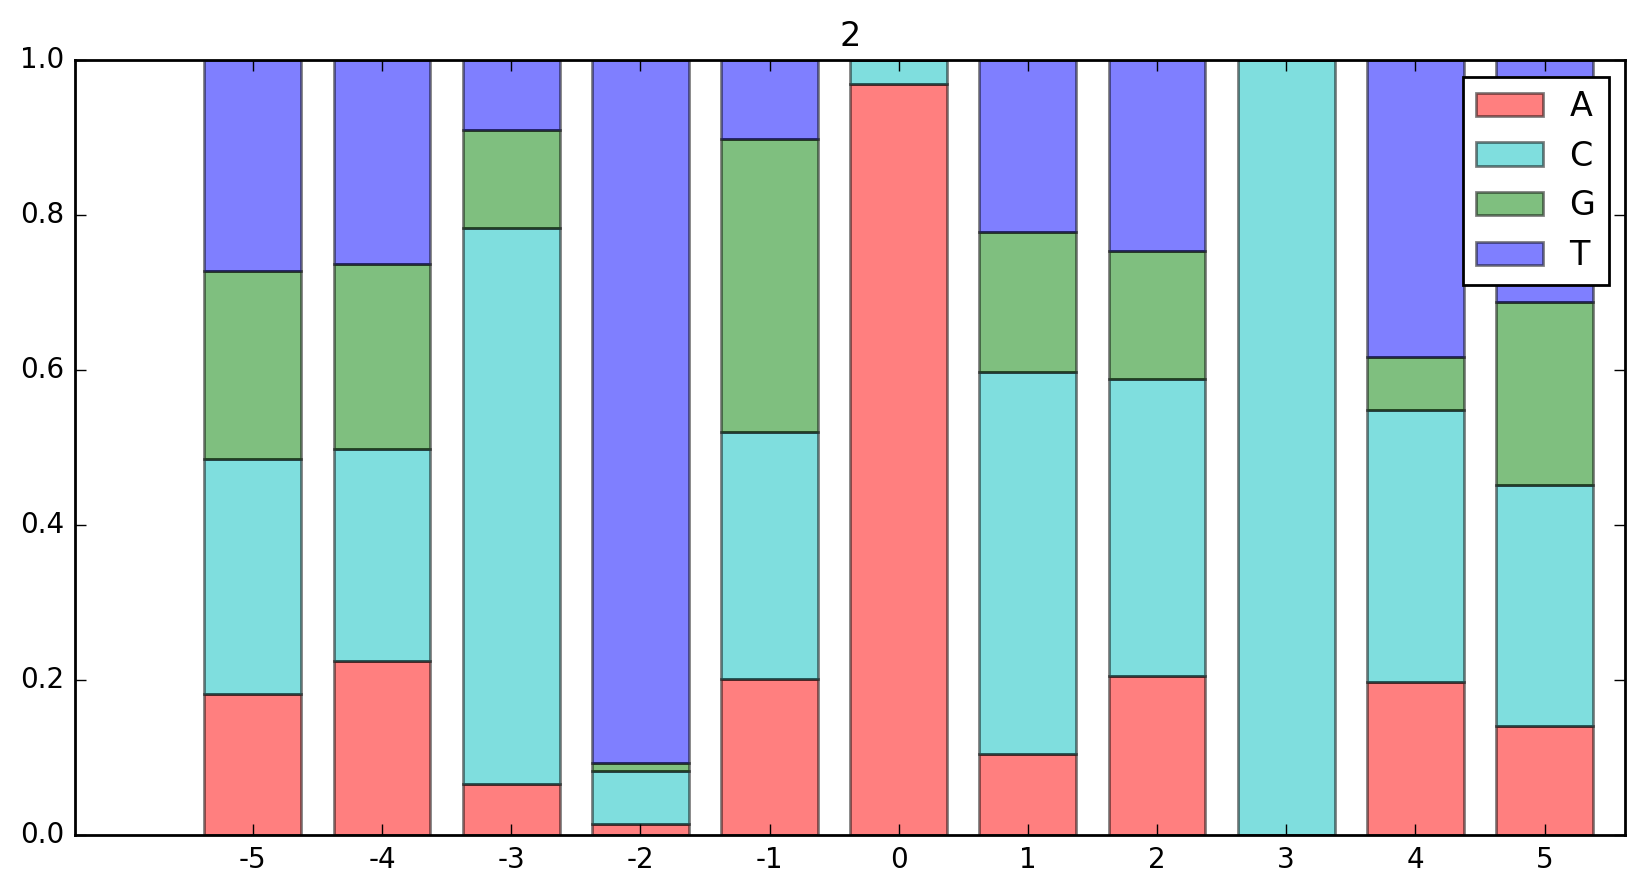

(33534, 44)


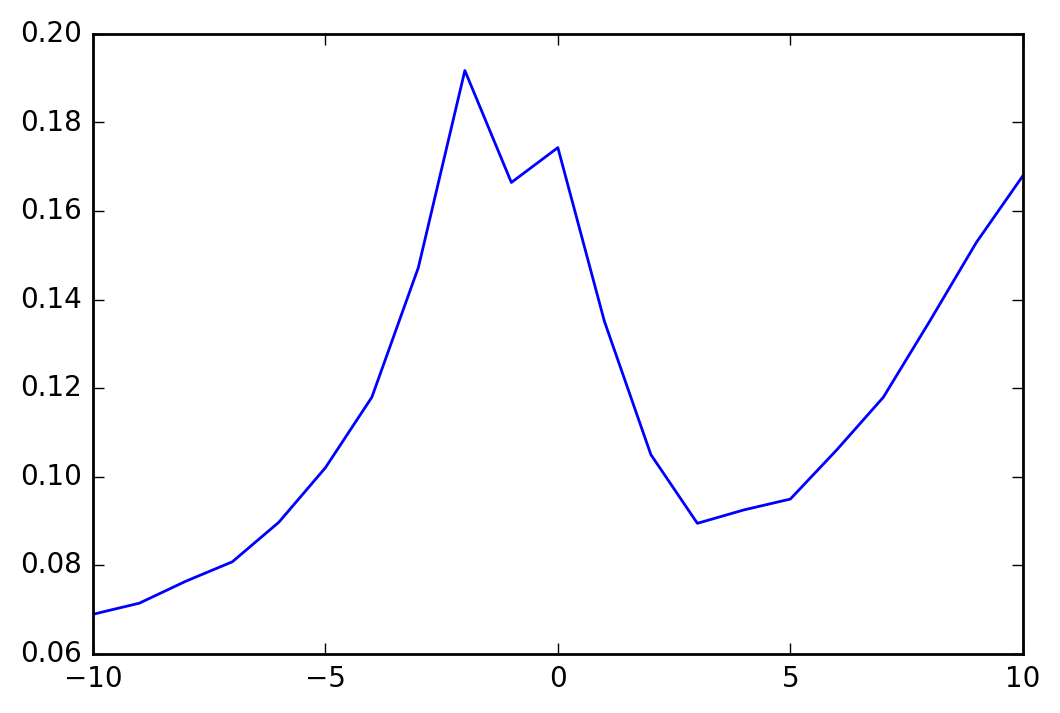

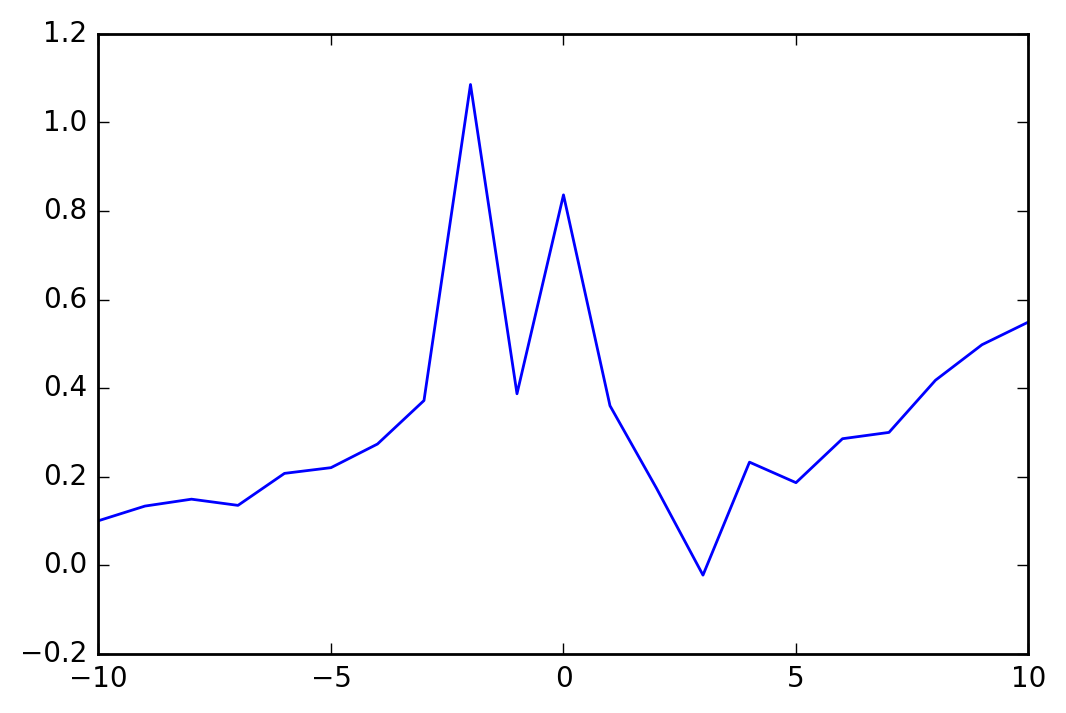

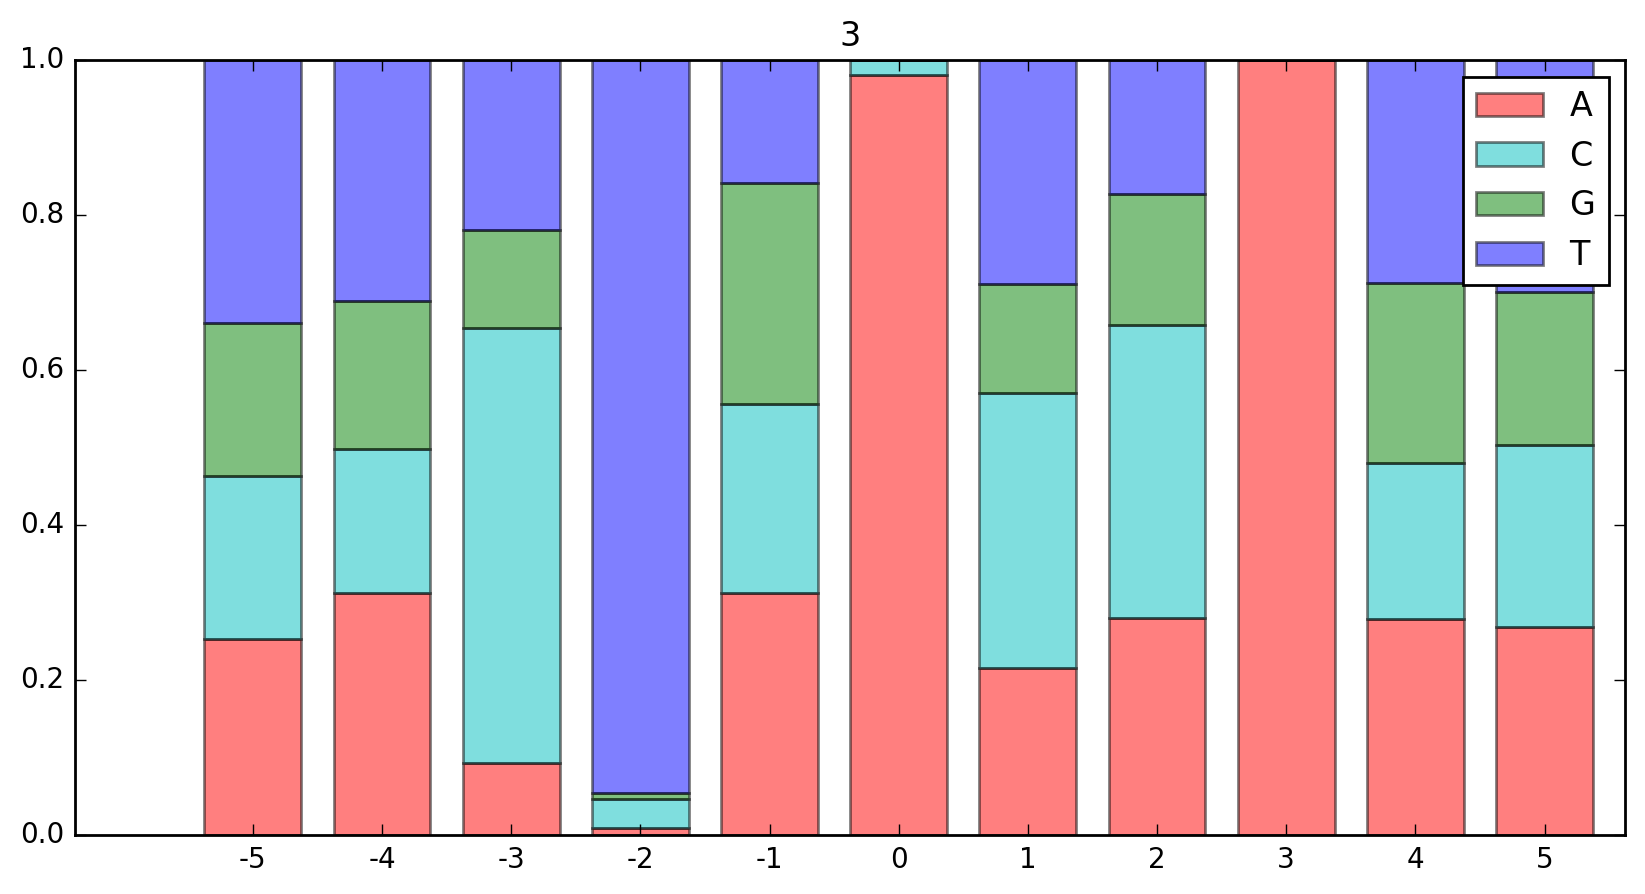

(39123, 44)


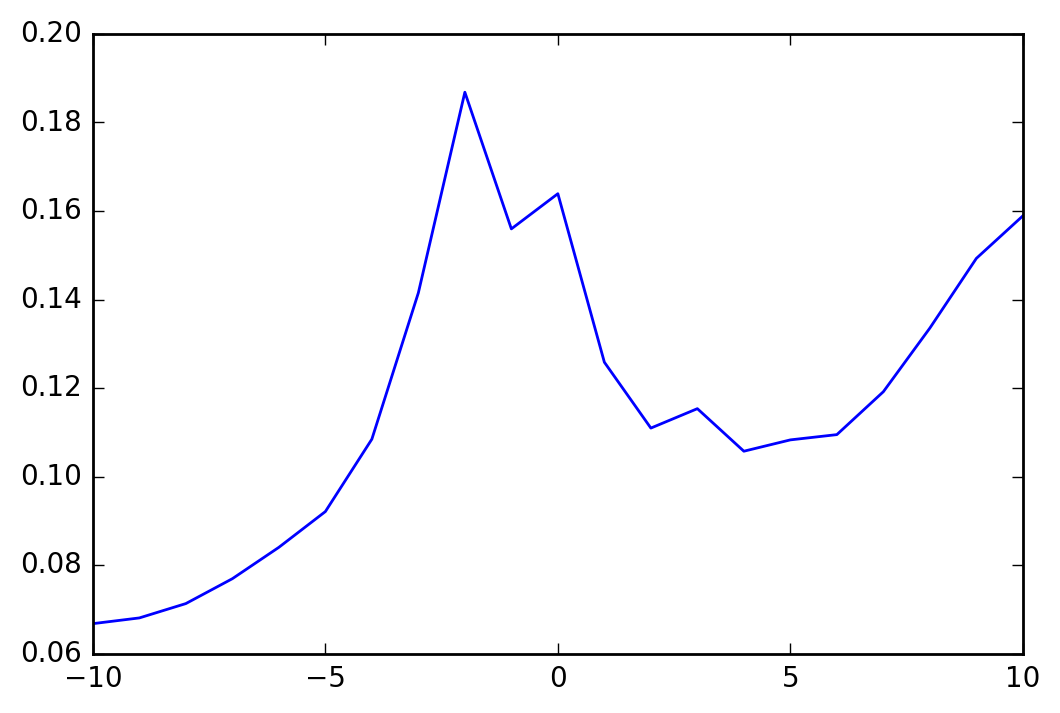

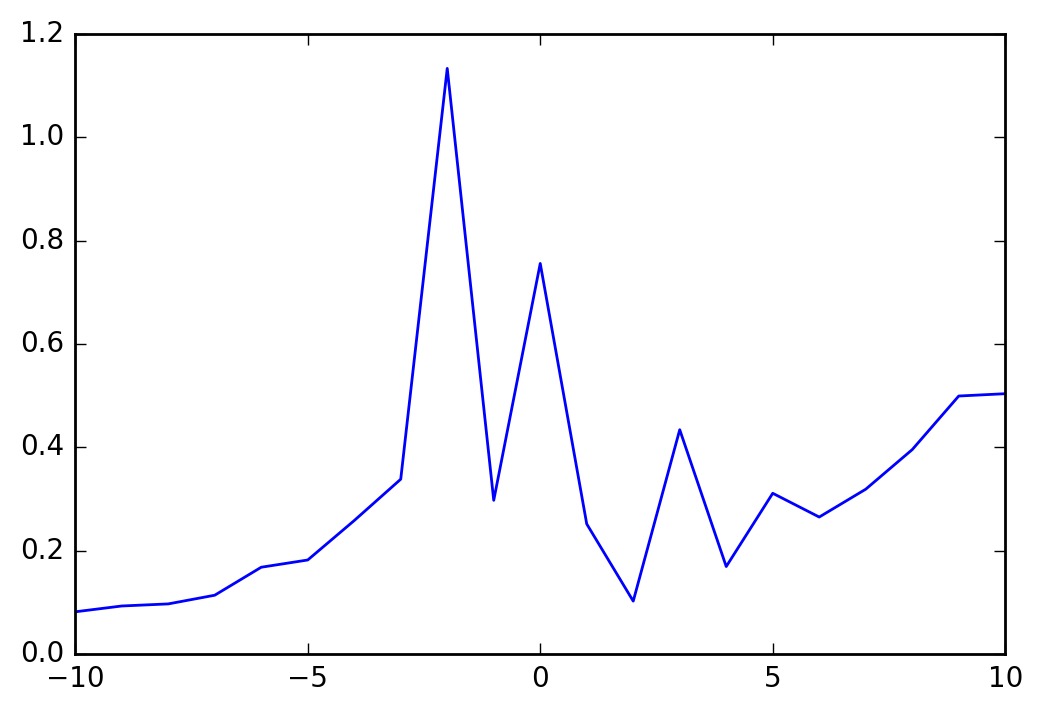

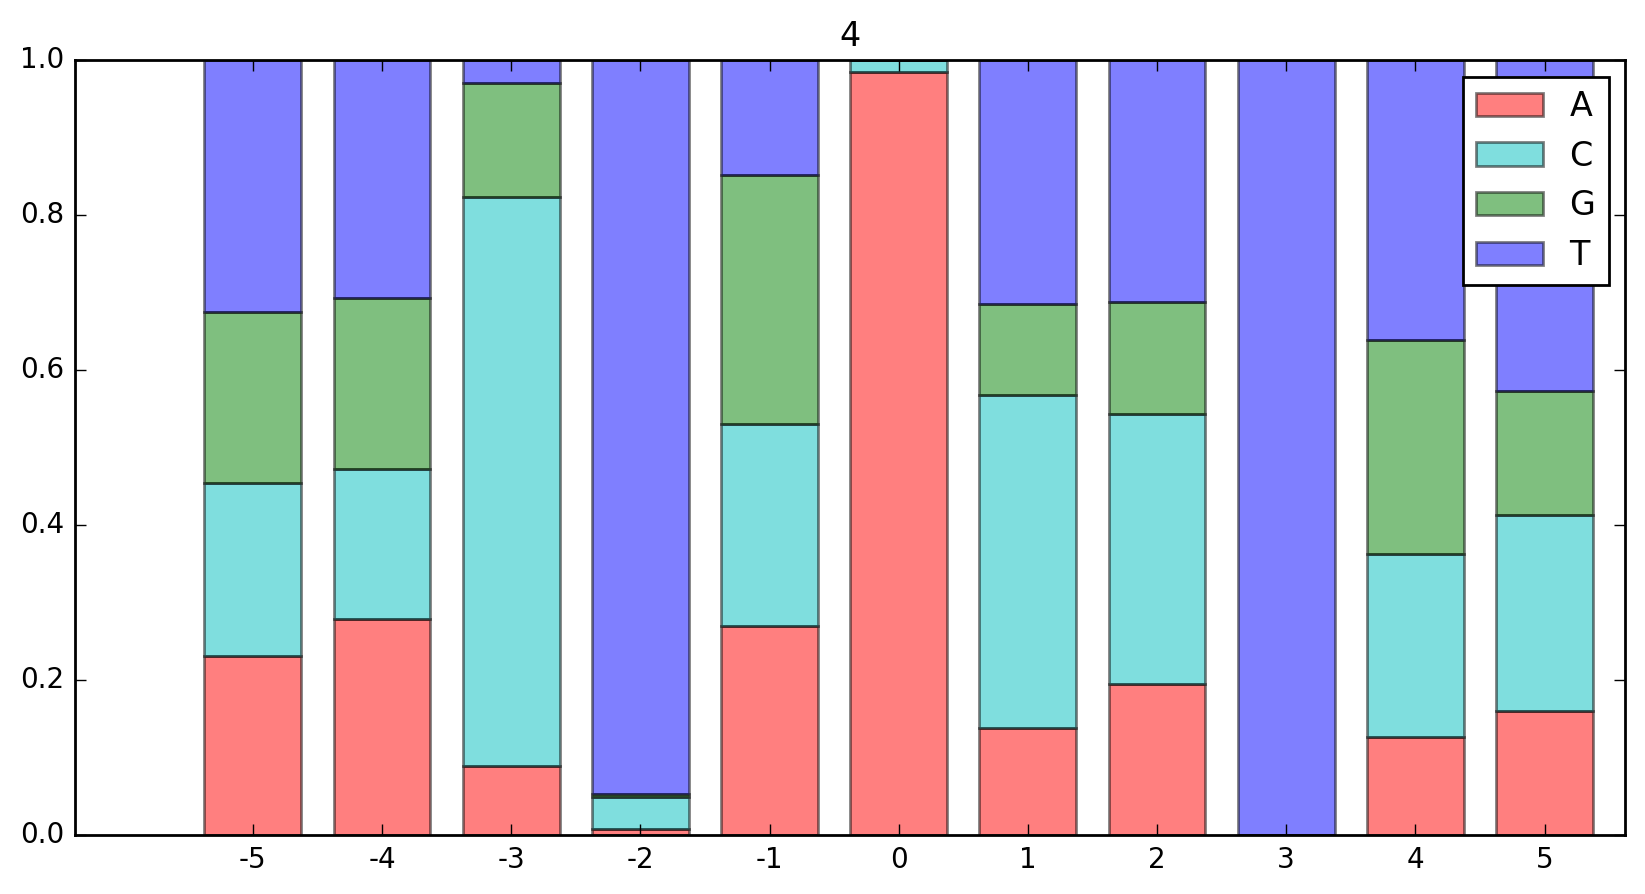

(28737, 44)


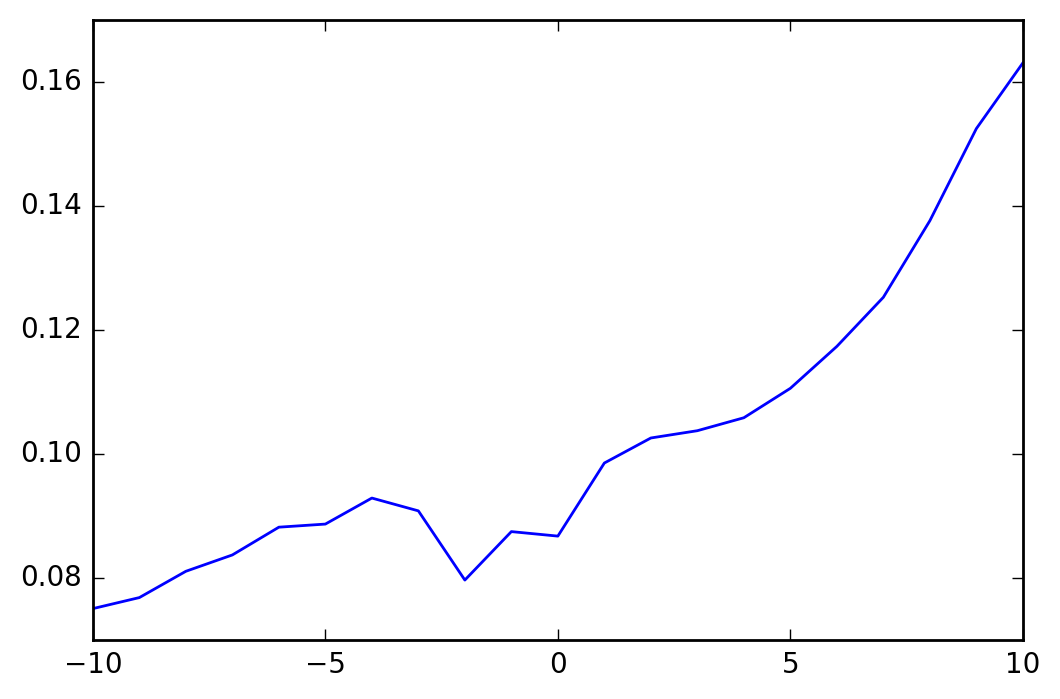

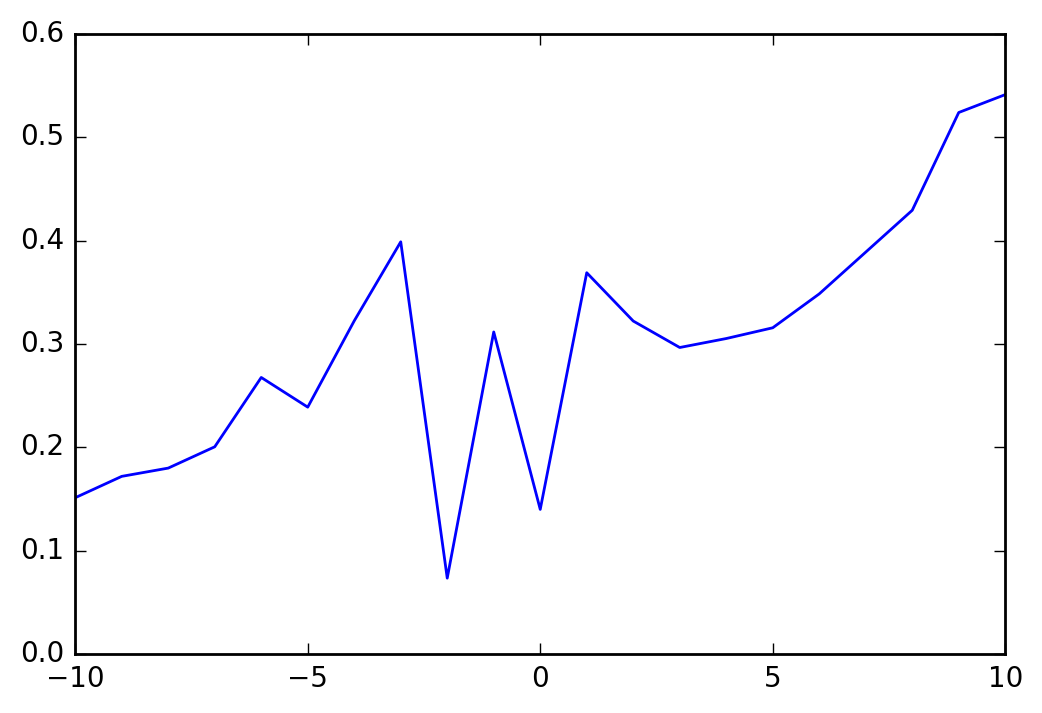

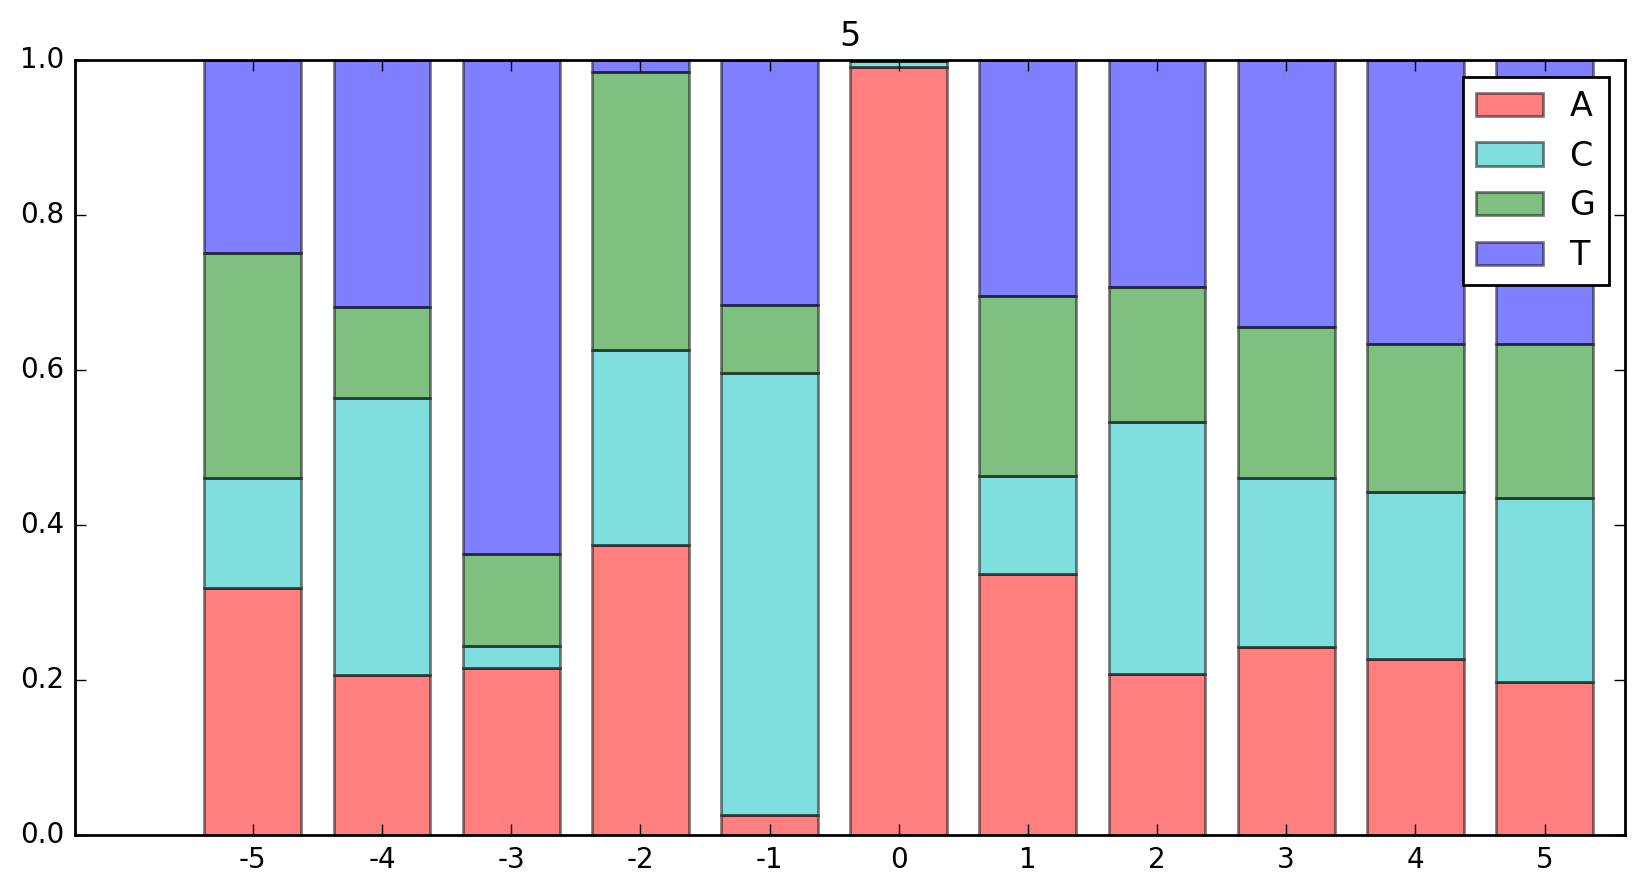

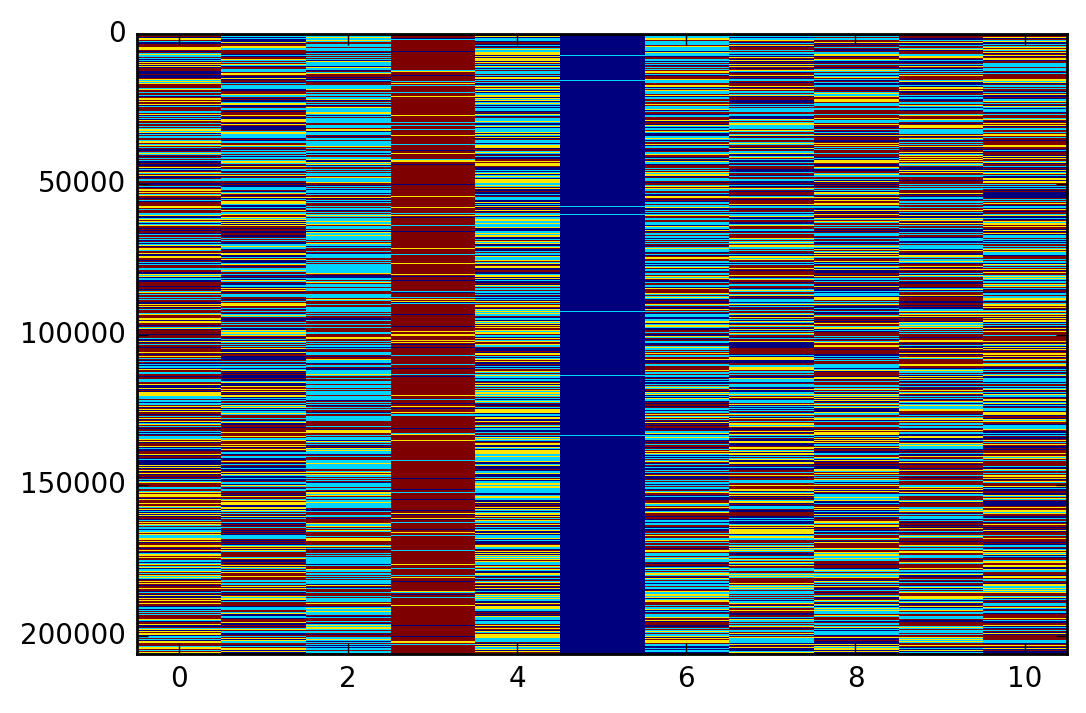

In [24]:
K = 5
B, E = 5, 6
sort = None
for i in range(max(kmeans.labels_)+1):
    clust = bps[kmeans.labels_ == i]
    if sort is not None:
        sort = np.vstack([sort, clust])
    else:
        sort = clust
    print clust.shape
    clust = clust.reshape(-1, B+E, 4)
    counts = np.zeros((B+E, 4))
    total = 0
    for seq in clust:
        counts += seq
        total += 1
    c = con[kmeans.labels_ == i]
    plt.plot(range(-10, 10+1), c[:, :, 0].mean(axis = 0))
    plt.show()
    plt.plot(range(-10, 10+1), c[:, :, 1].mean(axis = 0))
    plt.show()
    pwm_logo(counts / total, str(i))
plt.imshow(np.vstack(map(color, bps)), aspect = 'auto', interpolation = 'nearest')
plt.show()

# Secondary Structure

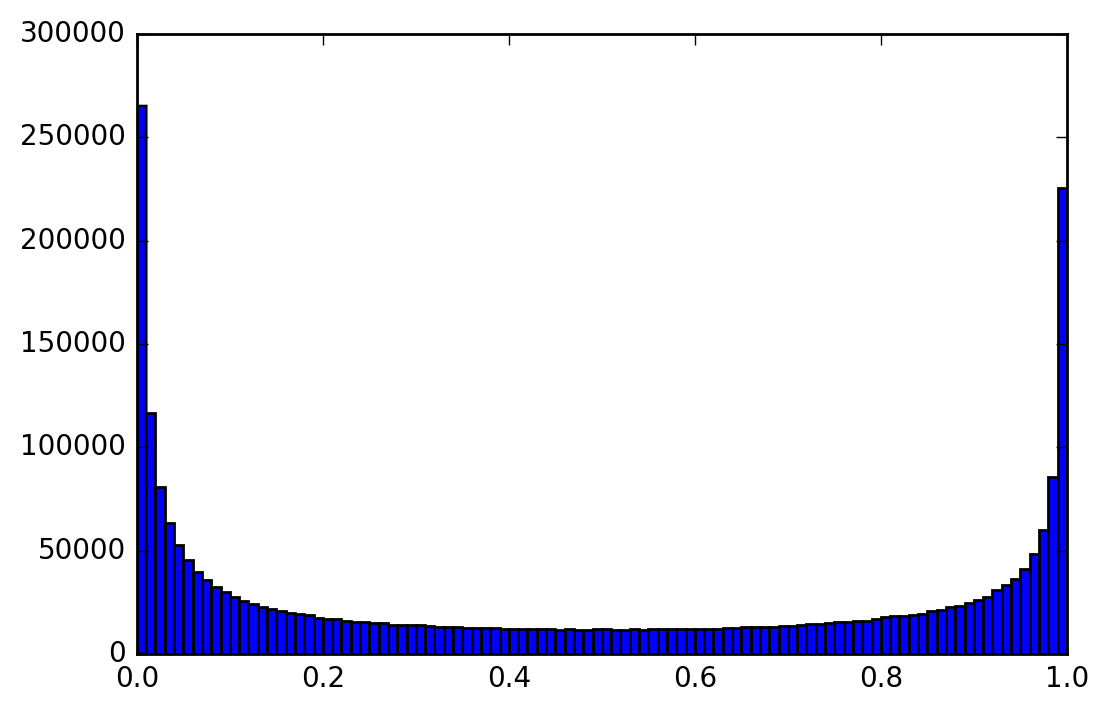

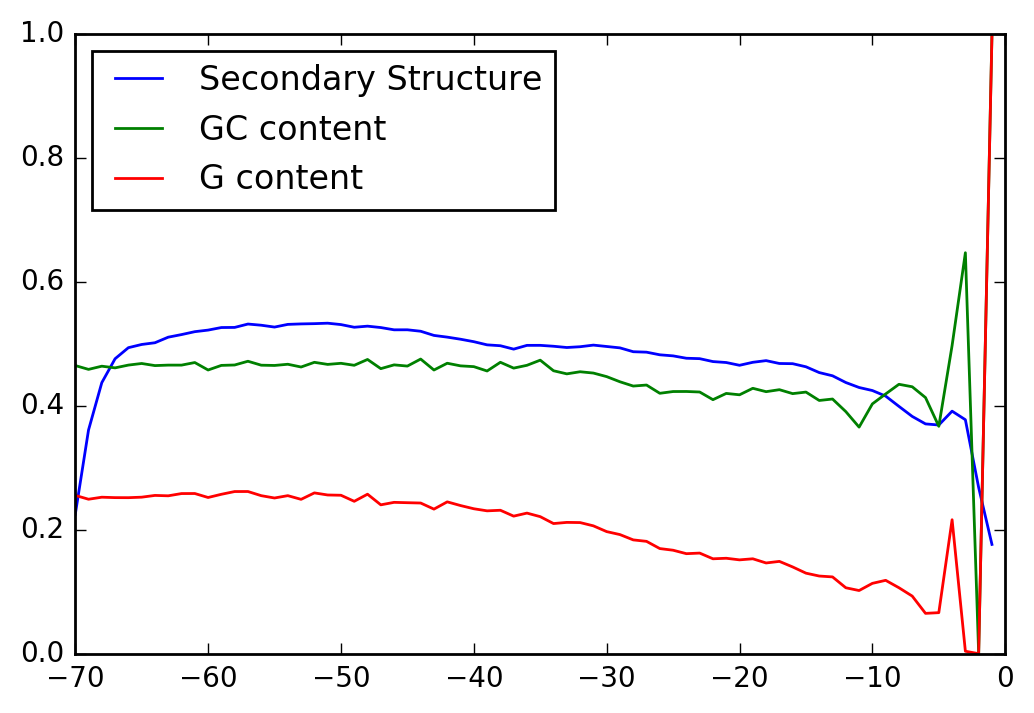

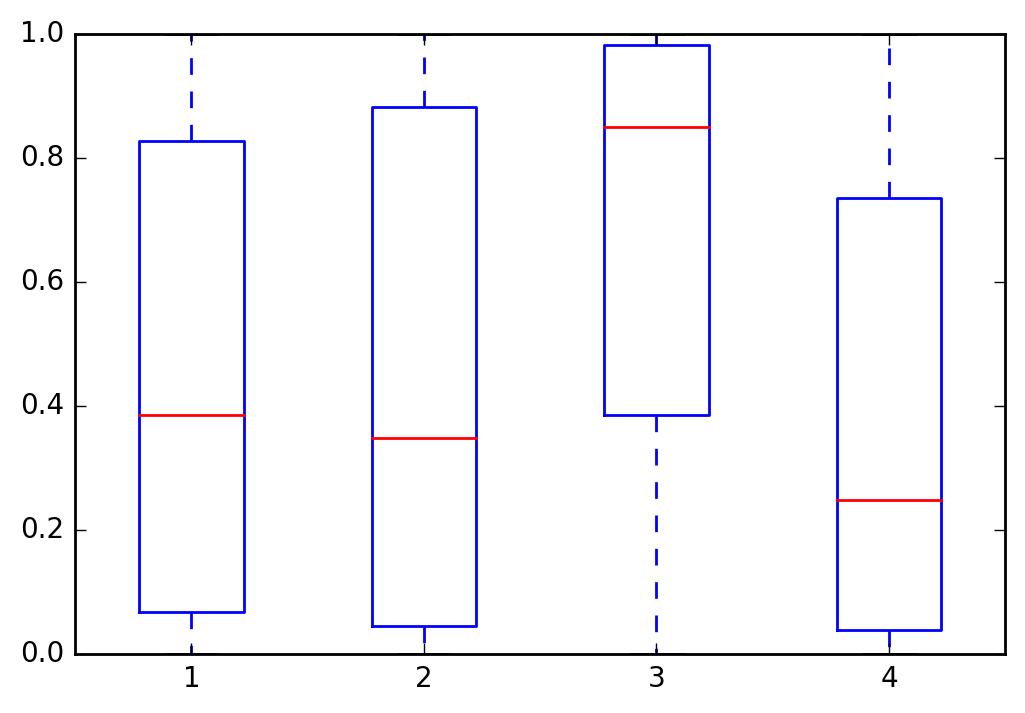

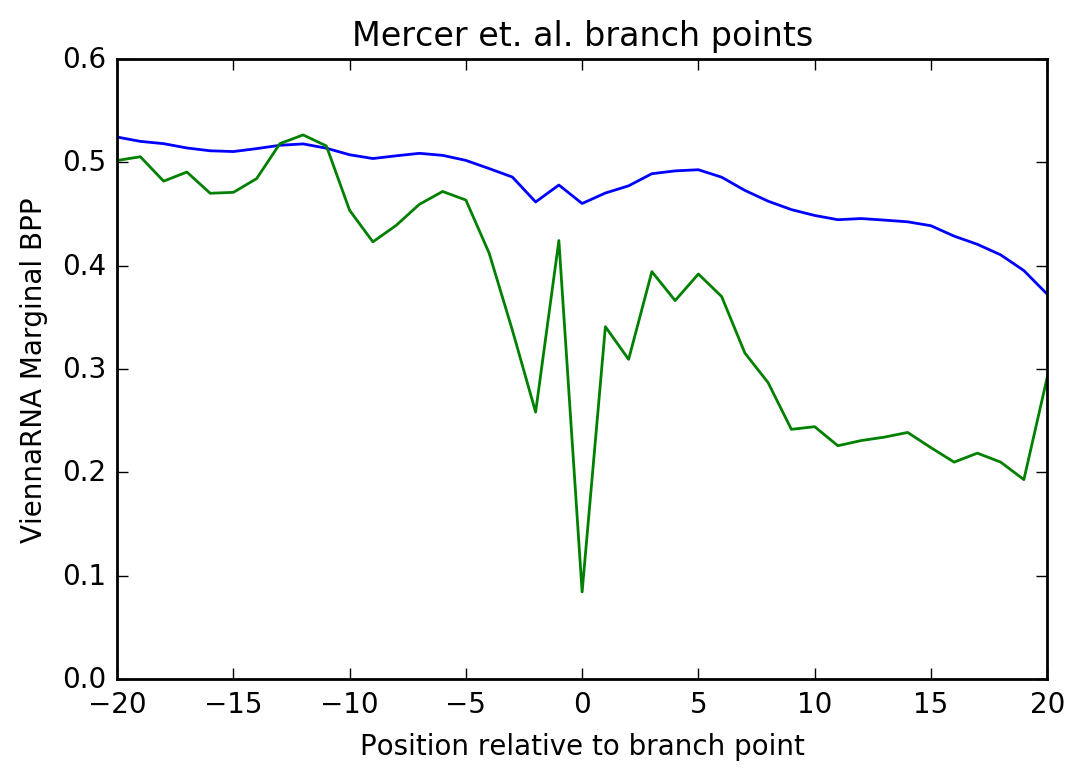

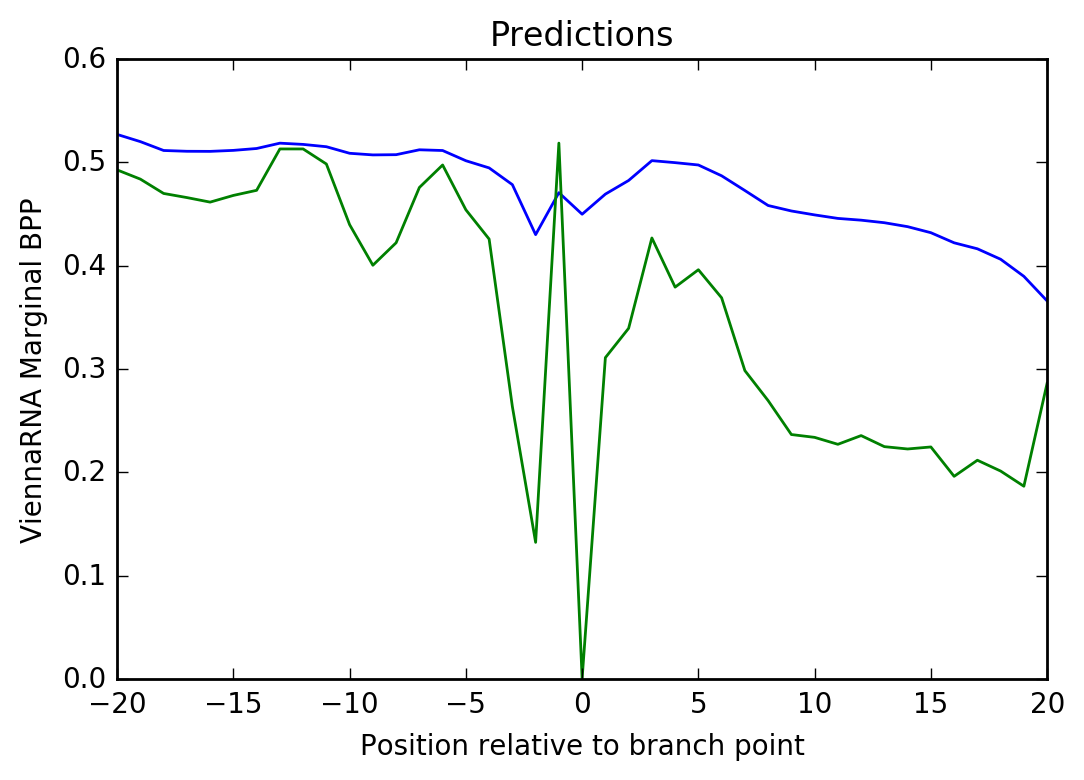

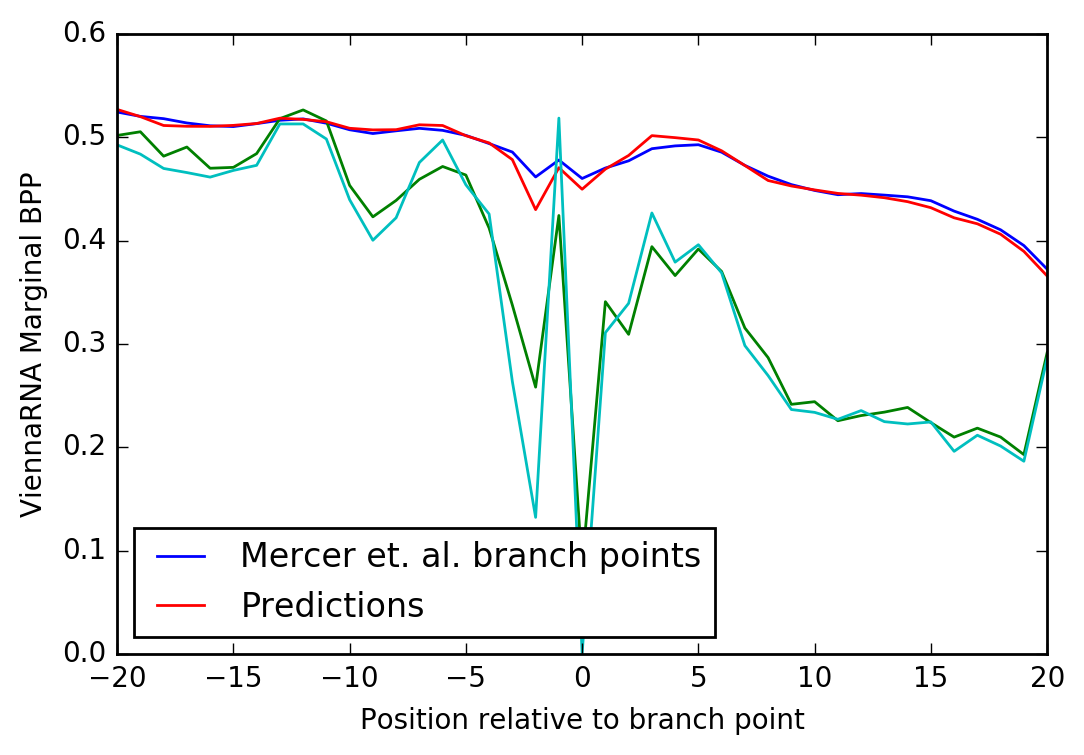

In [25]:
K = 20

plt.hist(X_known[:, :, 6].flatten(), bins = 100)
plt.show()

plt.plot(range(-70, 0), X_known[:, :, 6].mean(axis = 0), label = 'Secondary Structure')
plt.plot(range(-70, 0), X_known[:, :, 1].mean(axis = 0) + X_known[:, :, 2].mean(axis = 0), label = 'GC content')
plt.plot(range(-70, 0), X_known[:, :, 2].mean(axis = 0), label = 'G content')
plt.legend(loc = 2)
plt.show()

plt.boxplot([X_known[:, :, 6][X_known[:, :, i] == 1] for i in range(4)])
plt.show()

known = cons_known(X_known, y_known, 6)
predicted = cons_novel(X_known, p_known, 6)

g_known = cons_known(X_known, y_known, 2)
g_predicted = cons_novel(X_known, p_known, 2)

names = ['Mercer et. al. branch points',
         'Predictions']
cons = [known, predicted]
gs = [g_known, g_predicted]

for name, con, g in zip(names, cons, gs):
    plt.plot(range(-K, K+1), con)
    plt.plot(range(-K, K+1), 2*g)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('ViennaRNA Marginal BPP')
    plt.show()
    
for name, con, g in zip(names, cons, gs):
    plt.plot(range(-K, K+1), con, label = name)
    plt.plot(range(-K, K+1), 2*g)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('ViennaRNA Marginal BPP')
plt.legend(loc = 'best')
plt.show()

20 48
21 31
22 54
23 43
24 67
25 86
26 91
27 125
28 154
29 164
30 191
31 239
32 256
33 316
34 421
35 551
36 646
37 801
38 1082
39 1168
40 1391
41 1507
42 1444
43 1312
44 1308
45 1299
46 1278
47 1345
48 1500
49 1595


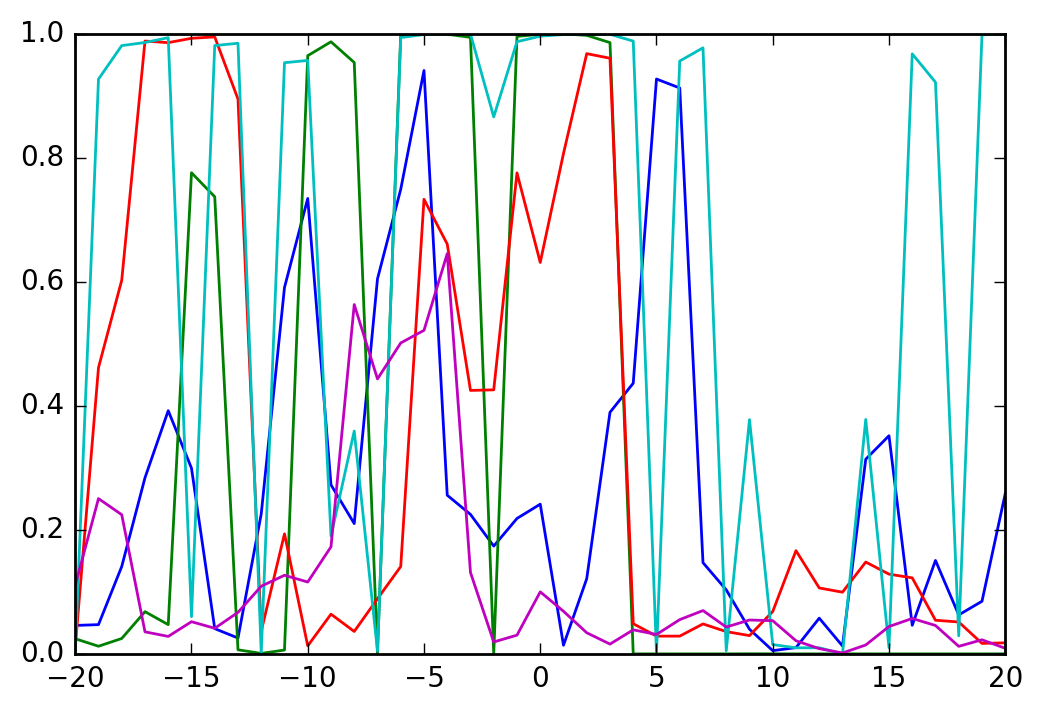

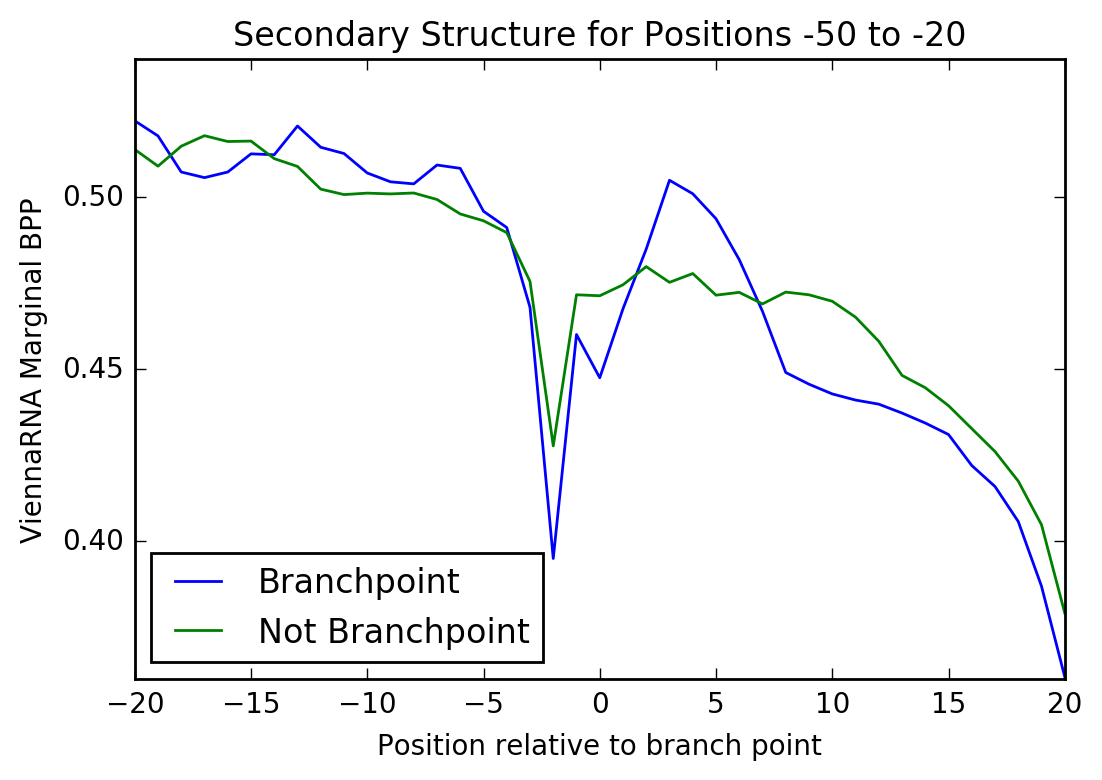

35 551
36 646
37 801
38 1082
39 1168
40 1391
41 1507
42 1444
43 1312
44 1308
45 1299
46 1278
47 1345
48 1500
49 1595


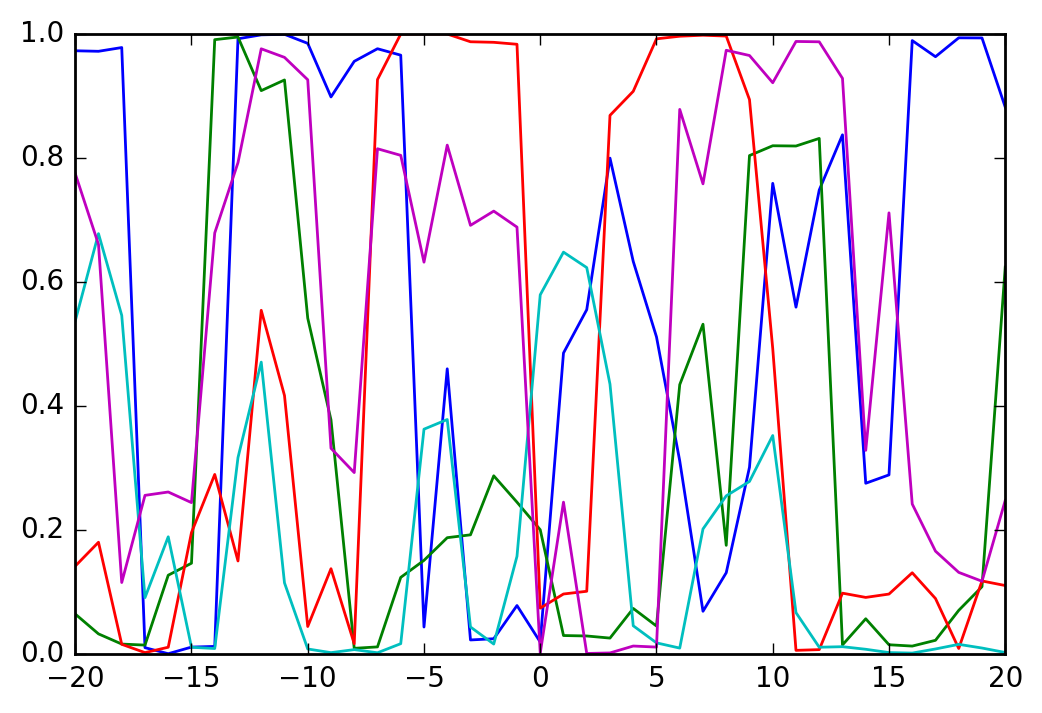

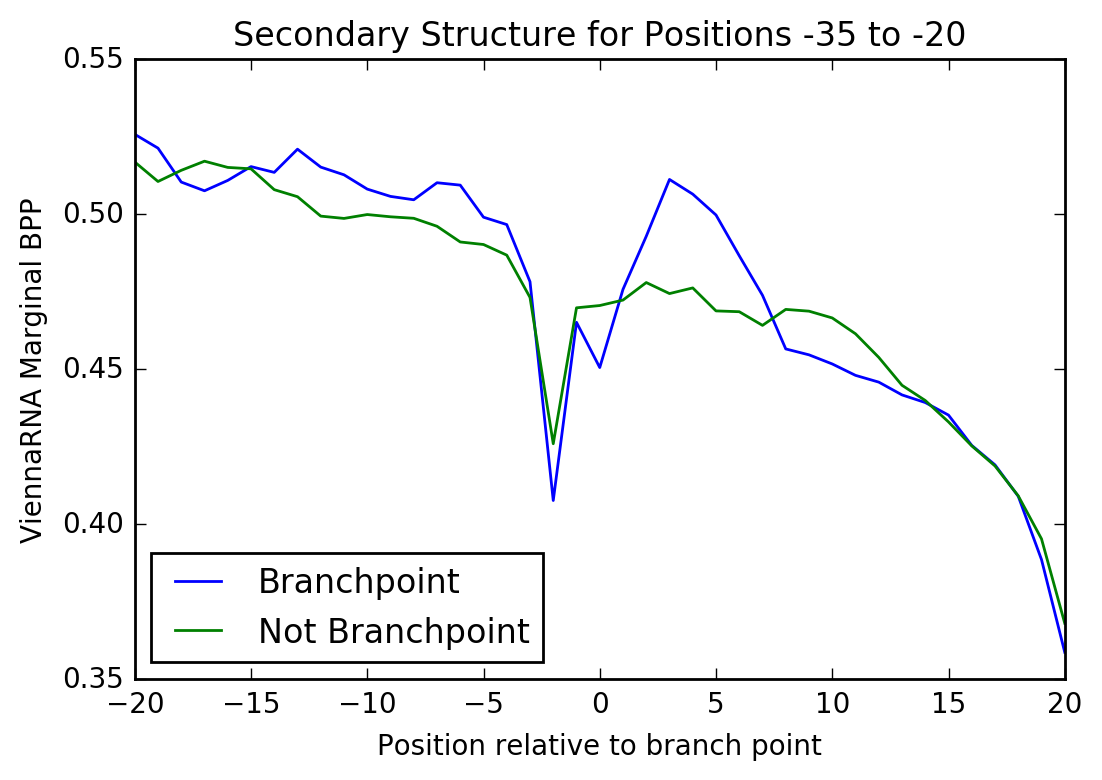

48 1500
49 1595
45 1299
46 1278
47 1345


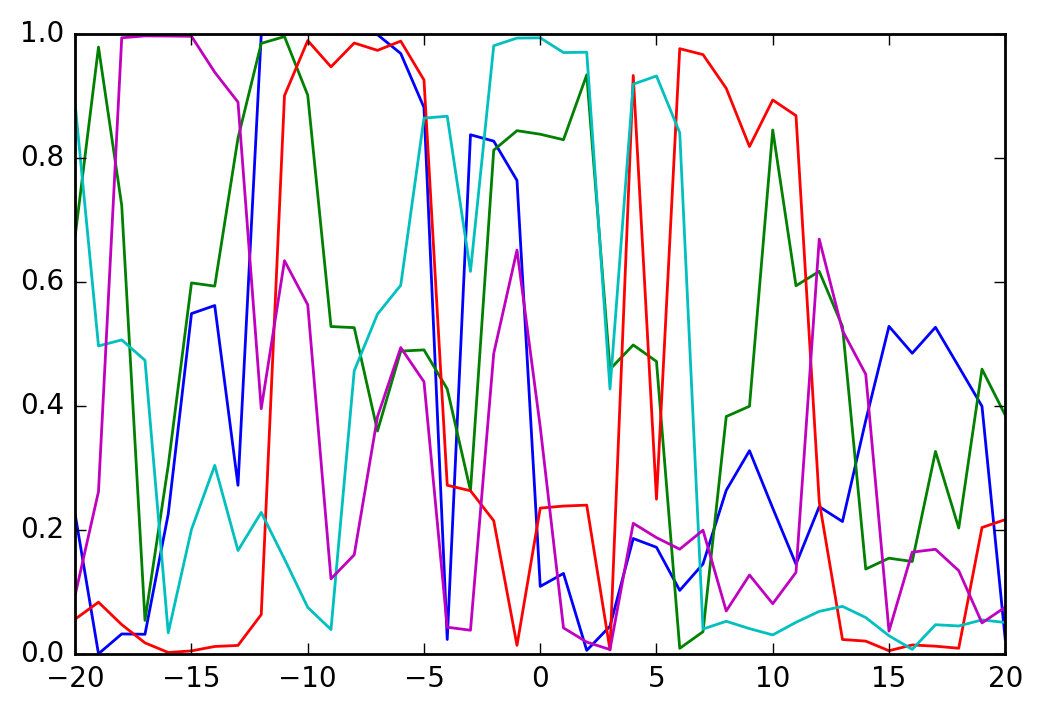

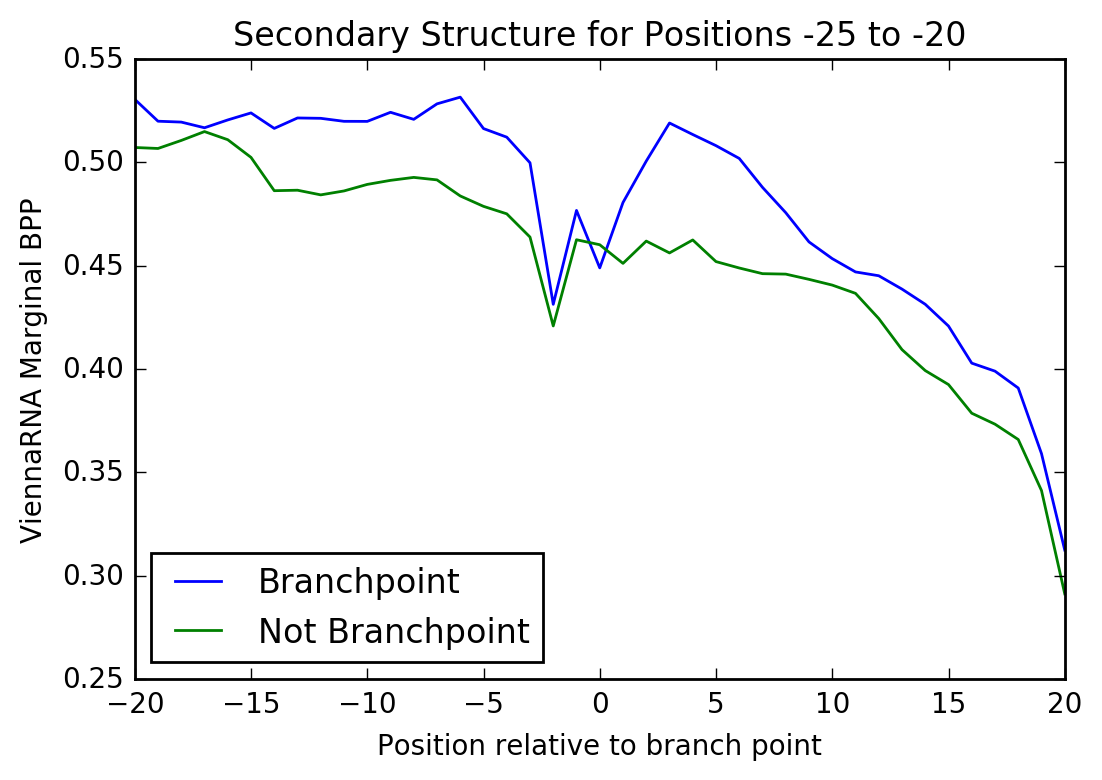

35 551
36 646
37 801
38 1082
39 1168


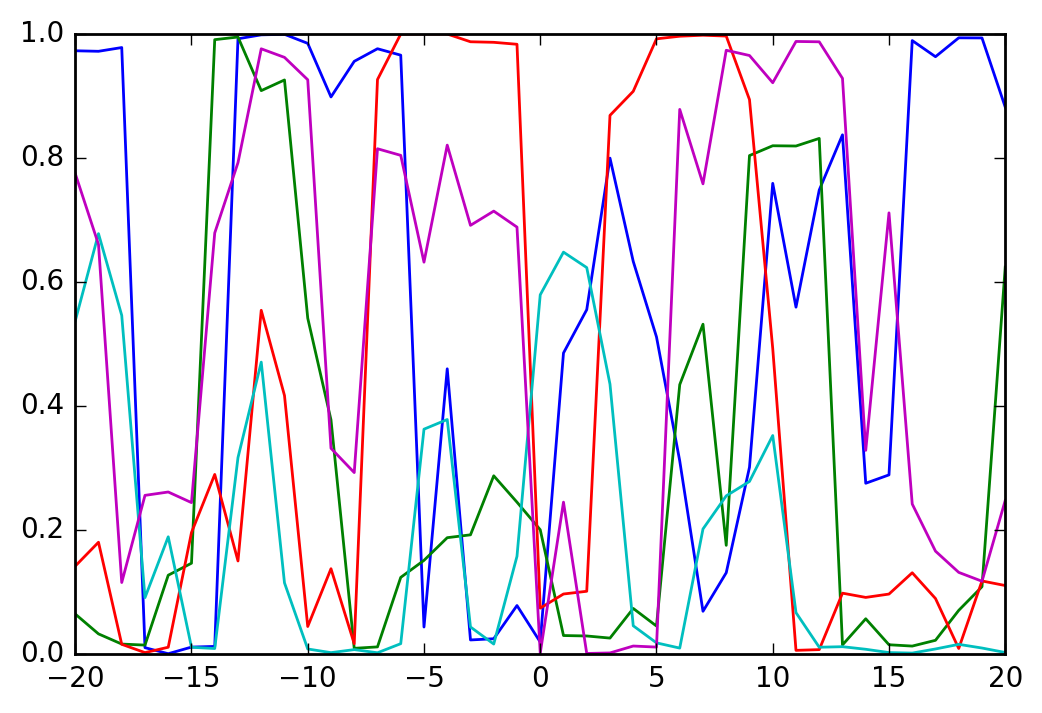

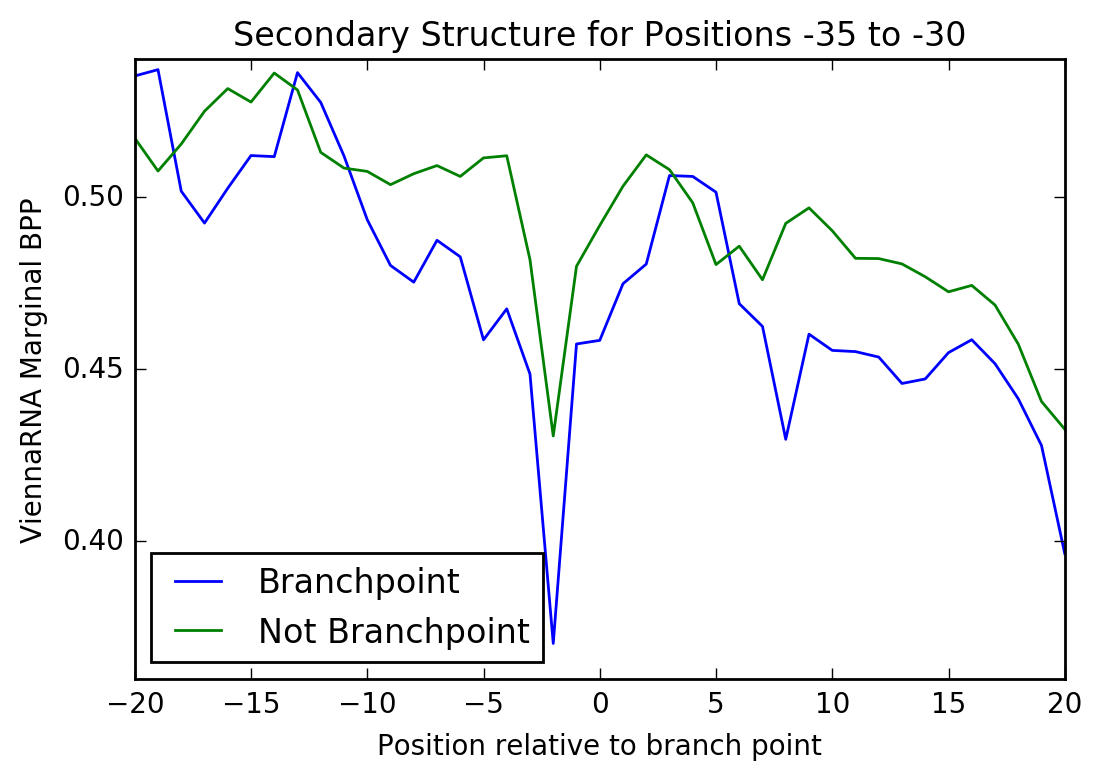

In [26]:
# Compare secondary structure at BP TNA to non-BP TNA in 22-28

def secondary_struct(start, end):
    branch, not_branch = {}, {}
    for target, seq in zip(p_known, X_known):
        bp = np.argmax(target)
        for i in range(L-end, L-start):
            if not seq[i, 0]*seq[i-2, 3]: continue
            if i == bp:
                if i not in branch: branch[i] = []
                branch[i] += [seq[i-K: i+K+1, 6]]

            else:
                if i not in not_branch: not_branch[i] = []
                not_branch[i] += [seq[i-K: i+K+1, 6]]

    for dist in branch.keys():
        num = min(len(branch[dist]), len(not_branch[dist]))
        branch[dist] = branch[dist][:num]
        not_branch[dist] = not_branch[dist][:num]
        print dist, num
        
    plt.plot(range(-K, K+1), np.vstack(branch.values()[0])[:5].T)
    plt.show()
    return (np.vstack(branch.values()).mean(axis = 0),
            np.vstack(not_branch.values()).mean(axis = 0))

b, nb = secondary_struct(K, L-K)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -50 to -20")
plt.show()

b, nb = secondary_struct(20, 35)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -35 to -20")
plt.show()

b, nb = secondary_struct(20, 25)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -25 to -20")
plt.show()


b, nb = secondary_struct(30, 35)
plt.plot(range(-K, K+1), b, label = 'Branchpoint')
plt.plot(range(-K, K+1), nb, label = 'Not Branchpoint')
plt.legend(loc = 'best')
plt.ylabel('ViennaRNA Marginal BPP')
plt.xlabel('Position relative to branch point')
plt.title("Secondary Structure for Positions -35 to -30")
plt.show()

## Variants

In [27]:
from sklearn.utils import shuffle
import pandas
def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'))

pathogenic = read_variants('../../variants/hg19.pathogenicv2.features.tsv')
benign = read_variants('../../hg19.benign.exons.tsv')

/Users/jpaggi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [95]:
# Make dict of chrom --> pos --> score
from sklearn.utils import shuffle

k_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, y_known):
    if chrom not in k_bps: k_bps[chrom] = {}
    for bp in np.nonzero(pred)[0]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        k_bps[chrom][idx] = strand
        
s_bps = {}
total = 0
thresh = 0
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, y_all):
    bp1 = np.argmax(pred)
    bp2 = np.argmax(np.hstack([pred[:bp1], np.zeros((1,)), pred[bp1+1:]]))
    if abs(bp2-bp1) < 5: continue
    if pred[bp2] < thresh: continue
    if chrom not in s_bps: s_bps[chrom] = {}
    idx = pos + (bp2-L+1 if strand == '+' else L-bp2)
    s_bps[chrom][idx] = strand
    total += 1
print total

r_s_bps = {}
total = 0

for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, shuffle(y_all)):
    bp1 = np.argmax(pred)
    bp2 = np.argmax(np.hstack([pred[:bp1], np.zeros((1,)), pred[bp1+1:]]))
    if abs(bp2-bp1) < 5: continue
    if pred[bp2] < thresh: continue
    
    if chrom not in r_s_bps: r_s_bps[chrom] = {}
    idx = pos + (bp2-L+1 if strand == '+' else L-bp2)
    if idx in a_bps[chrom]: continue
    r_s_bps[chrom][idx] = strand
    total += 1
print total

a_bps = {}
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, y_all):
    if chrom not in a_bps: a_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    a_bps[chrom][idx] = strand
    
r_a_bps = {}
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, shuffle(y_all)):
    if chrom not in r_a_bps: r_a_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    r_a_bps[chrom][idx] = strand
    
n_bps = {}
for chrom, pos, strand, pred in zip(n_chroms, n_coords,
                                    n_strands, y_novel):
    if chrom not in n_bps: n_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    n_bps[chrom][idx] = strand
    
p_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, p_known):
    if chrom not in p_bps: p_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    p_bps[chrom][idx] = strand

76734
73474


Mercer et. al. branchpoints
Predictions in Mercer introns
Novel predicted branchpoints
All predicted branchpoints
Shuffled all predicted branchpoints
Second BPs
Shuffled Second BPs


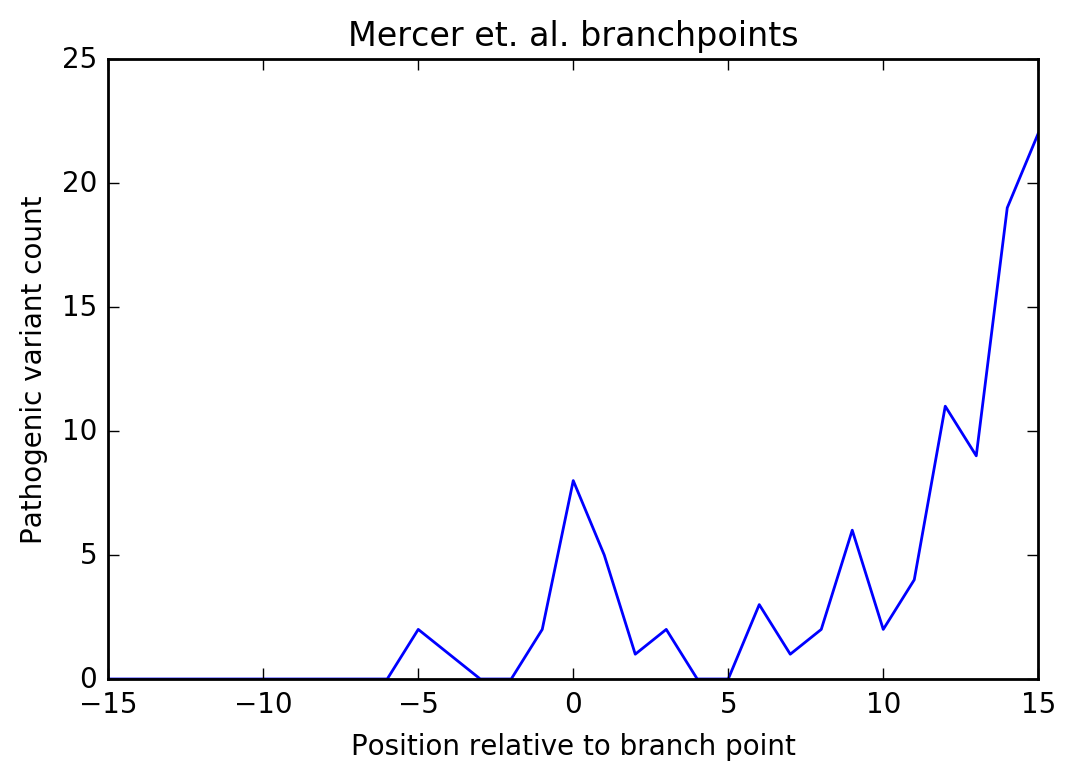

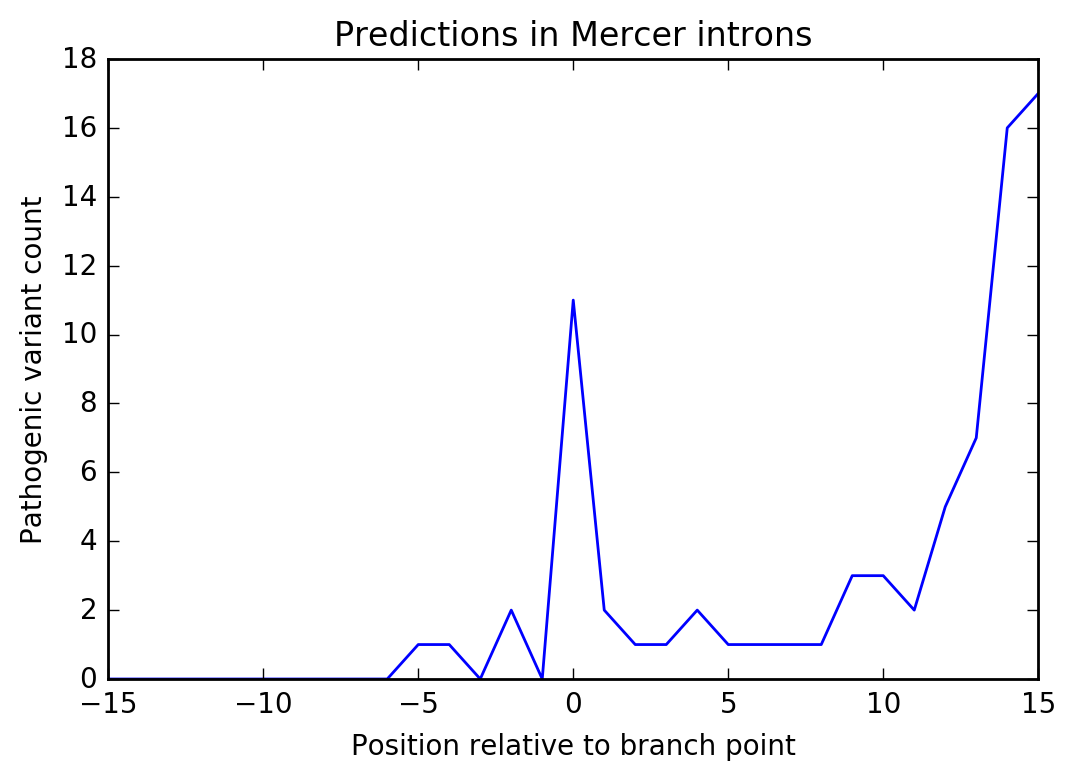

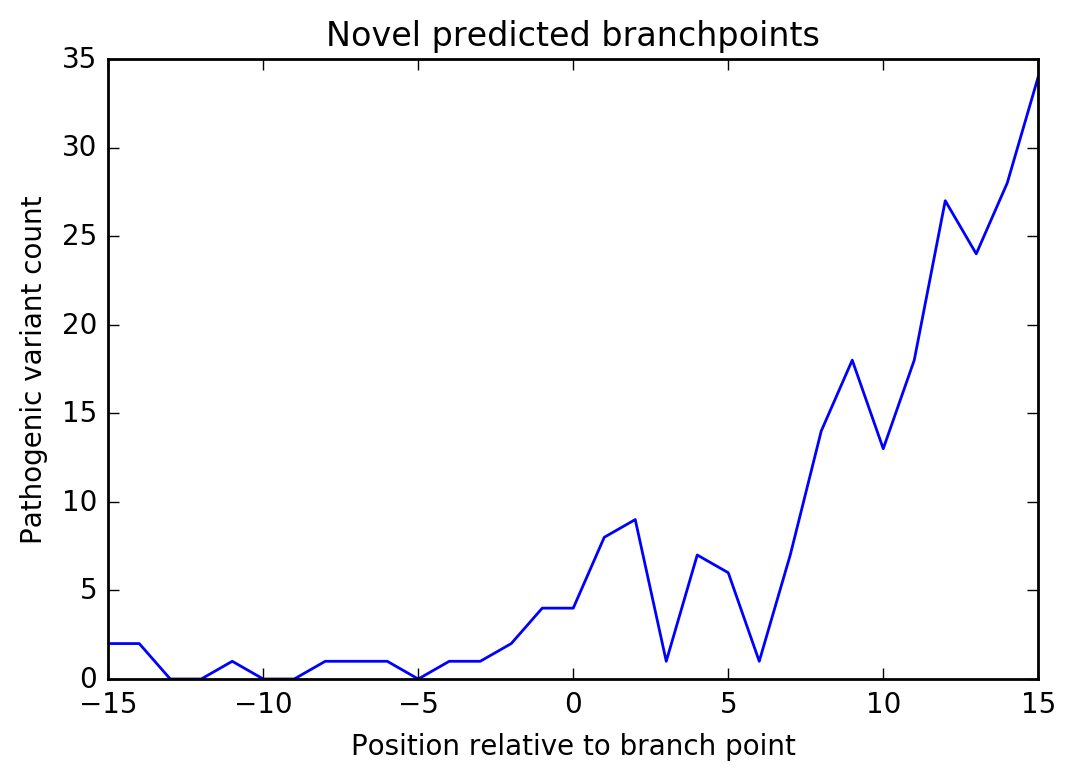

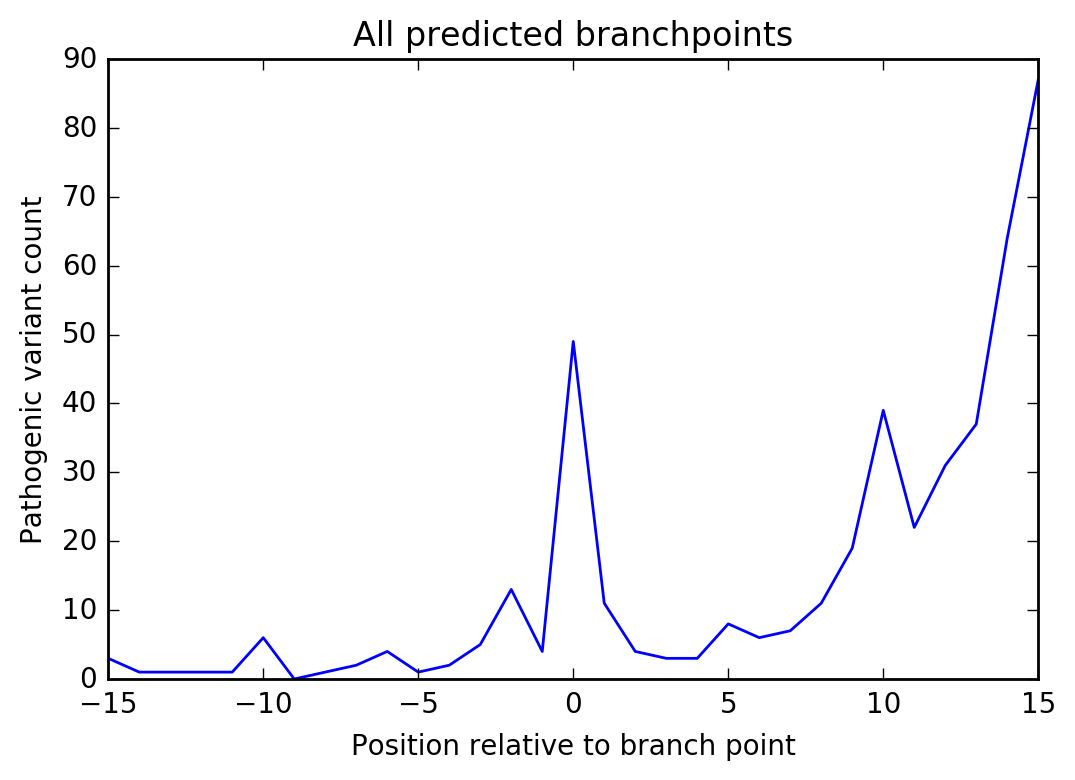

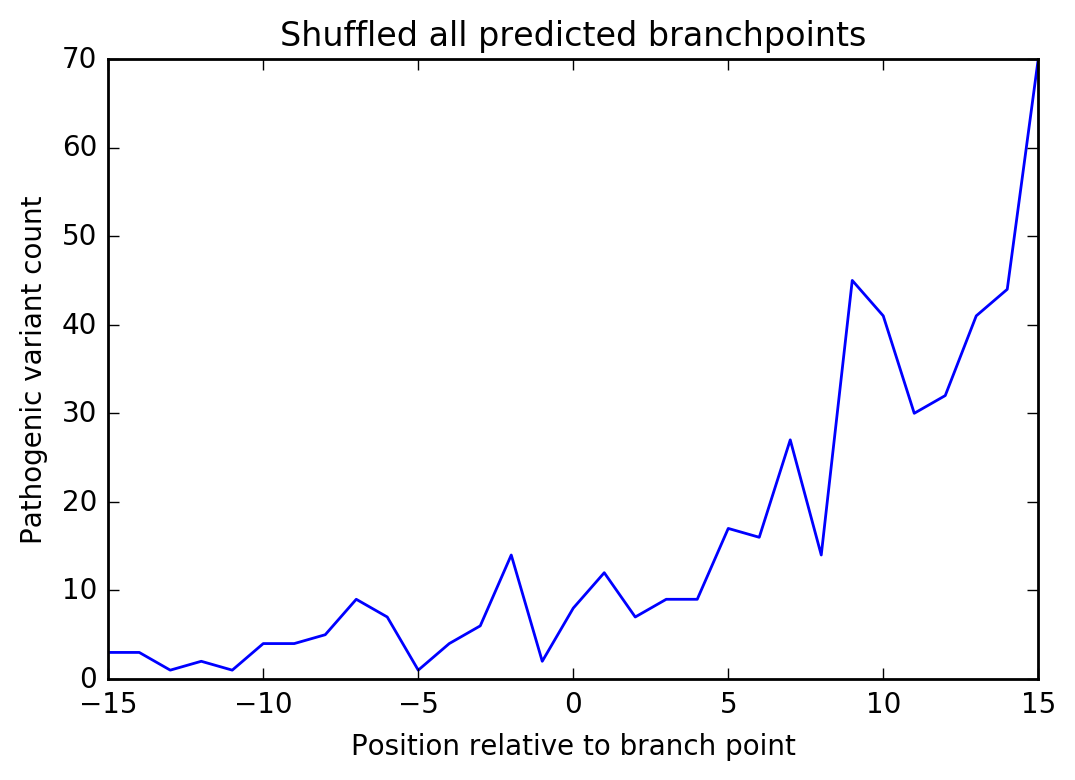

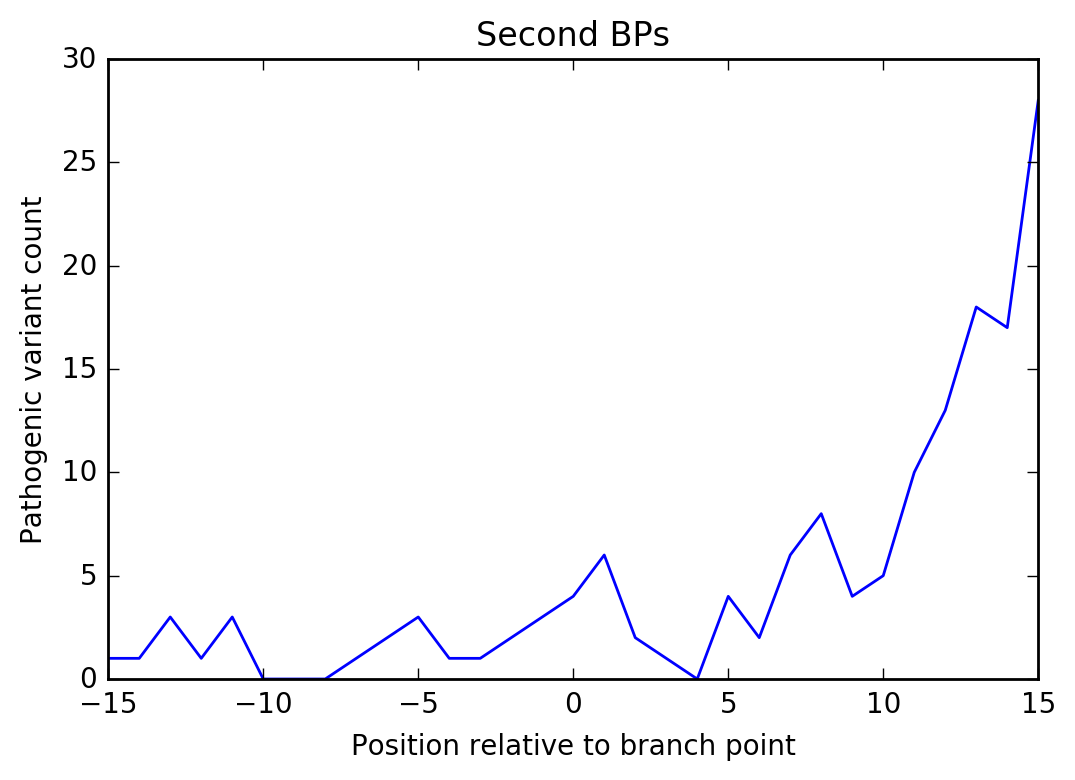

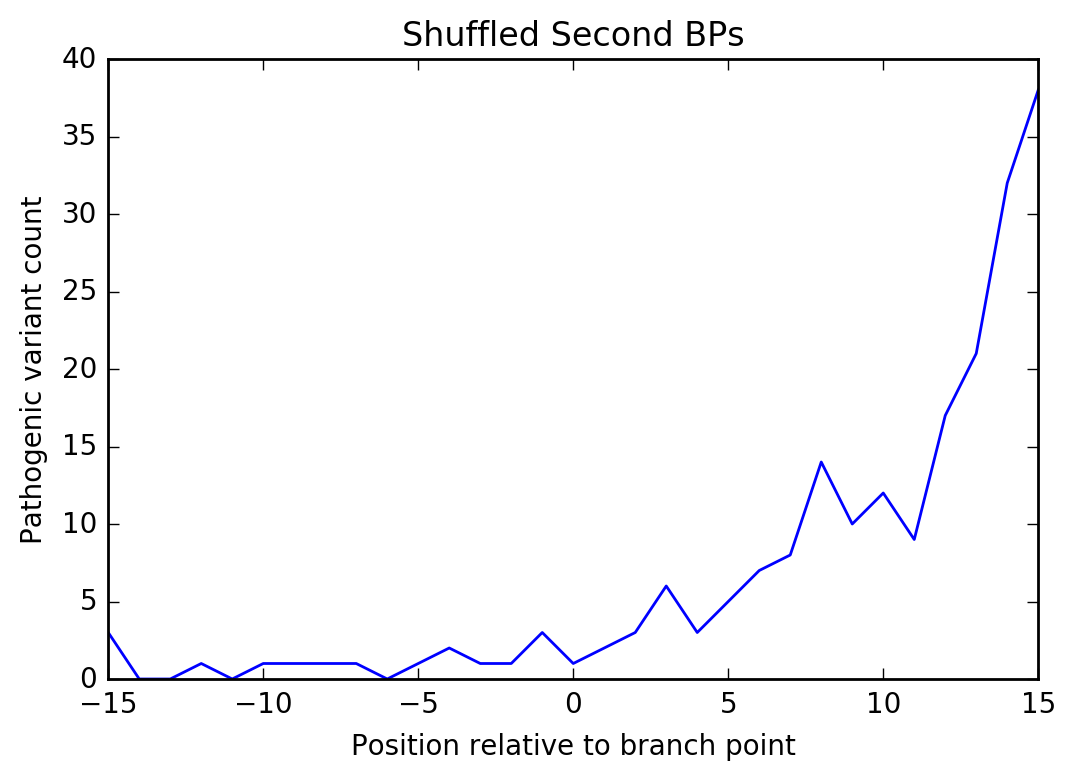

In [108]:
def var_enrichment(v, bps, K = 15):
    hits = []
    variants = {}
    for shift in range(-K, K+1):
        hits += [0]
        for chrom, pos, strand, alt in zip(v['CHROM'], v['POS'], v['strand'], v['ALT']):
            s = -shift if strand == '+' else shift
            key = "{}:{}:{}".format(chrom, pos, alt)
            if pos+s in bps['chr'+str(chrom)]:
                if key in variants:
                    if abs(variants[key]) <= abs(shift):
                        continue
                    else:
                        hits[-1] += 1
                        hits[variants[key]+K] -= 1
                        variants[key] = shift
                else:
                    hits[-1] += 1
                    variants[key] = shift
    return hits

names = ['Mercer et. al. branchpoints',
         'Predictions in Mercer introns',
         'Novel predicted branchpoints',
         'All predicted branchpoints',
         'Shuffled all predicted branchpoints',
         'Second BPs',
         'Shuffled Second BPs']
bps = [k_bps, p_bps, n_bps, a_bps, r_a_bps, s_bps, r_s_bps]

path = []
for bp, name in zip(bps, names):
    print name
    path += [var_enrichment(pathogenic, bp)]

for name, hits in zip(names, path):
    plt.plot(range(-15, 16), hits)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("Pathogenic variant count")
    plt.show()

In [105]:
exac = []
for bp in bps:
    exac += [var_enrichment(benign, bp)]

for name, hits in zip(names, exac):
    plt.plot(range(-15, 16), hits)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("ExAC variant count")
    plt.show()

KeyboardInterrupt: 

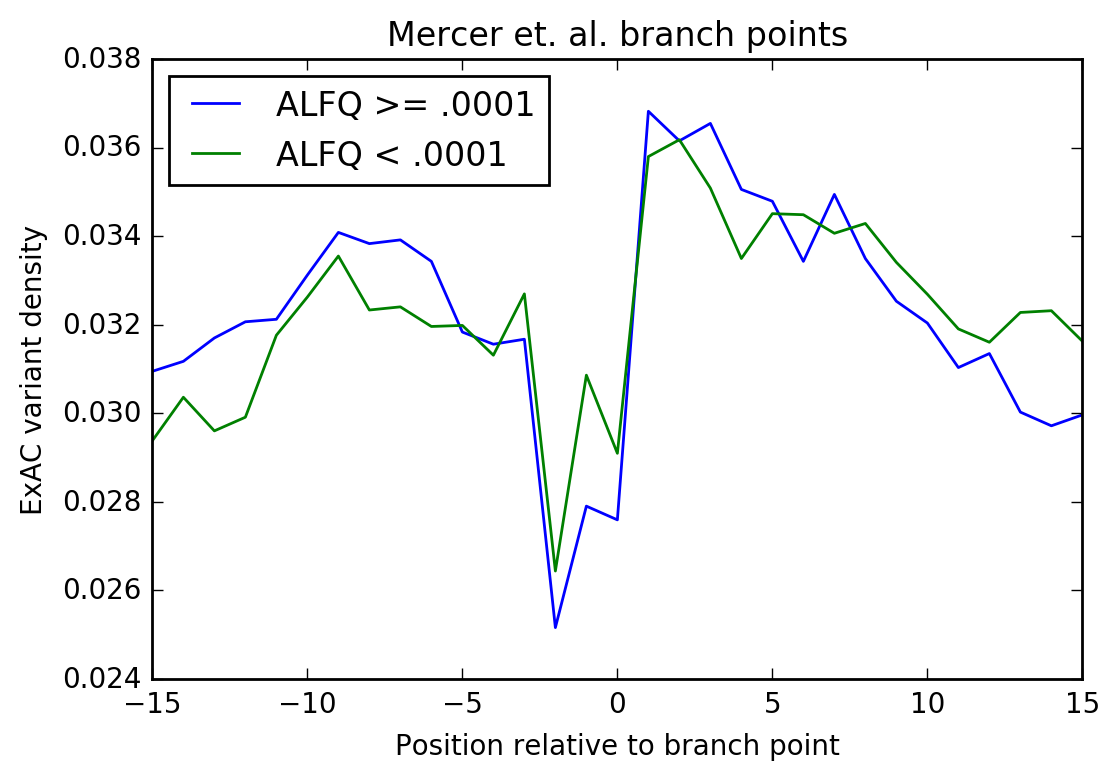

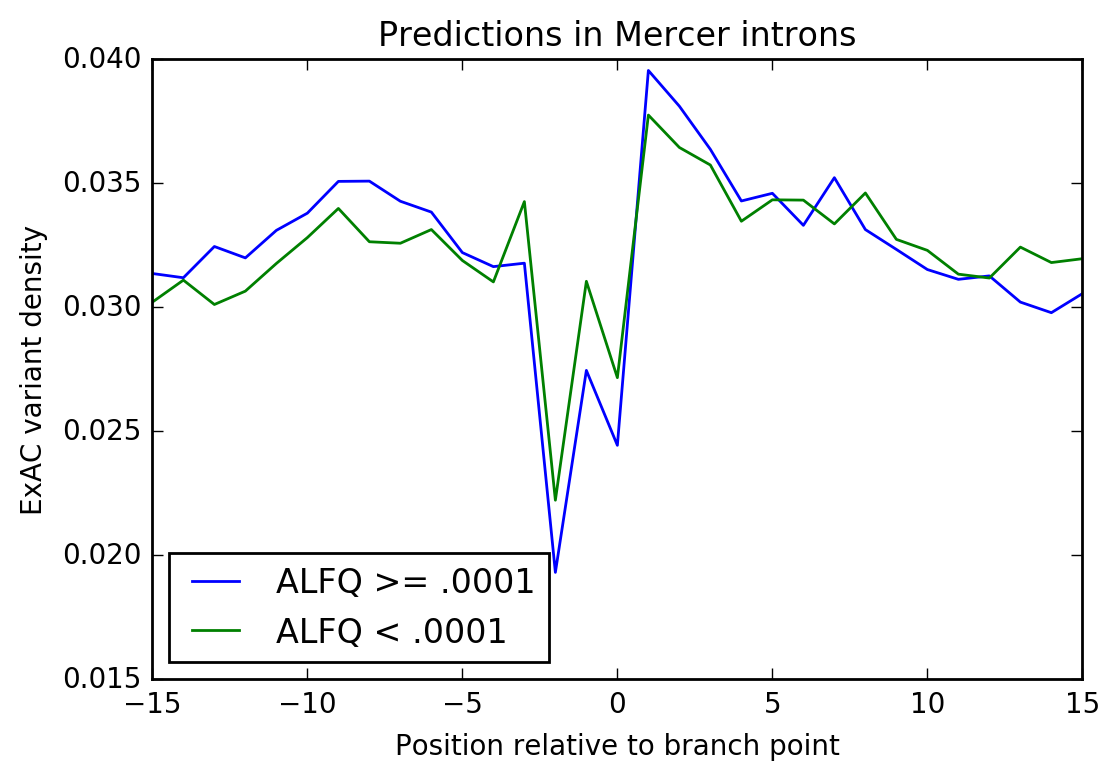

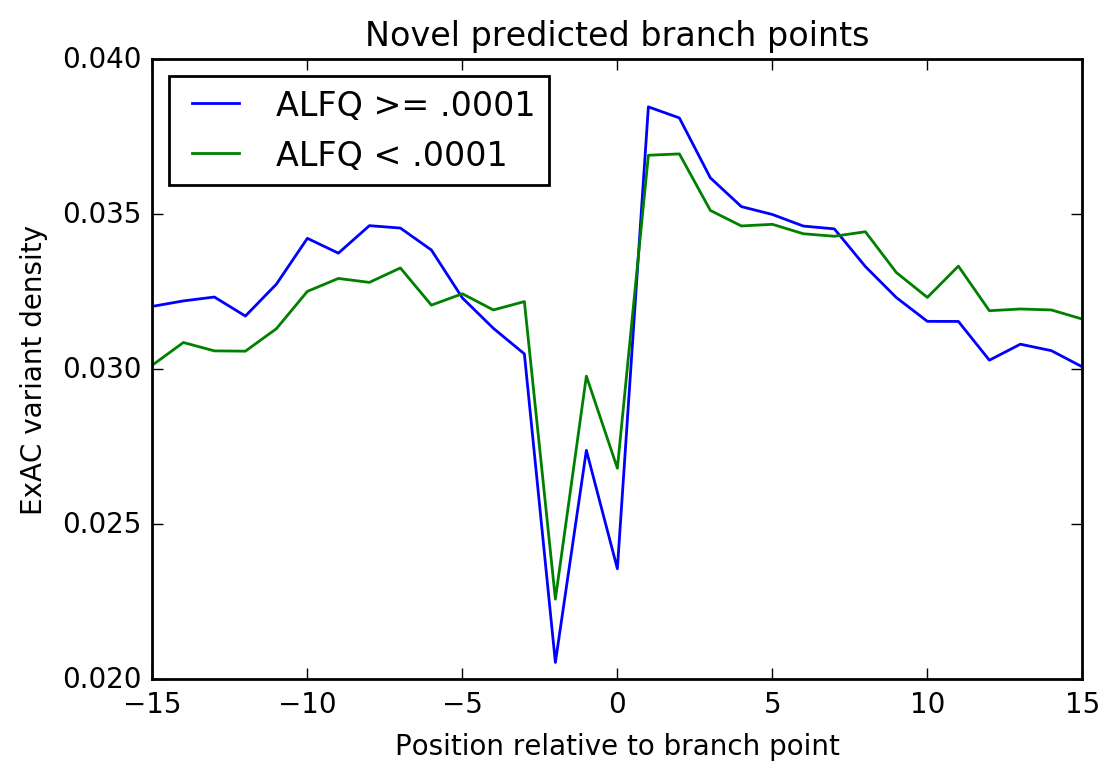

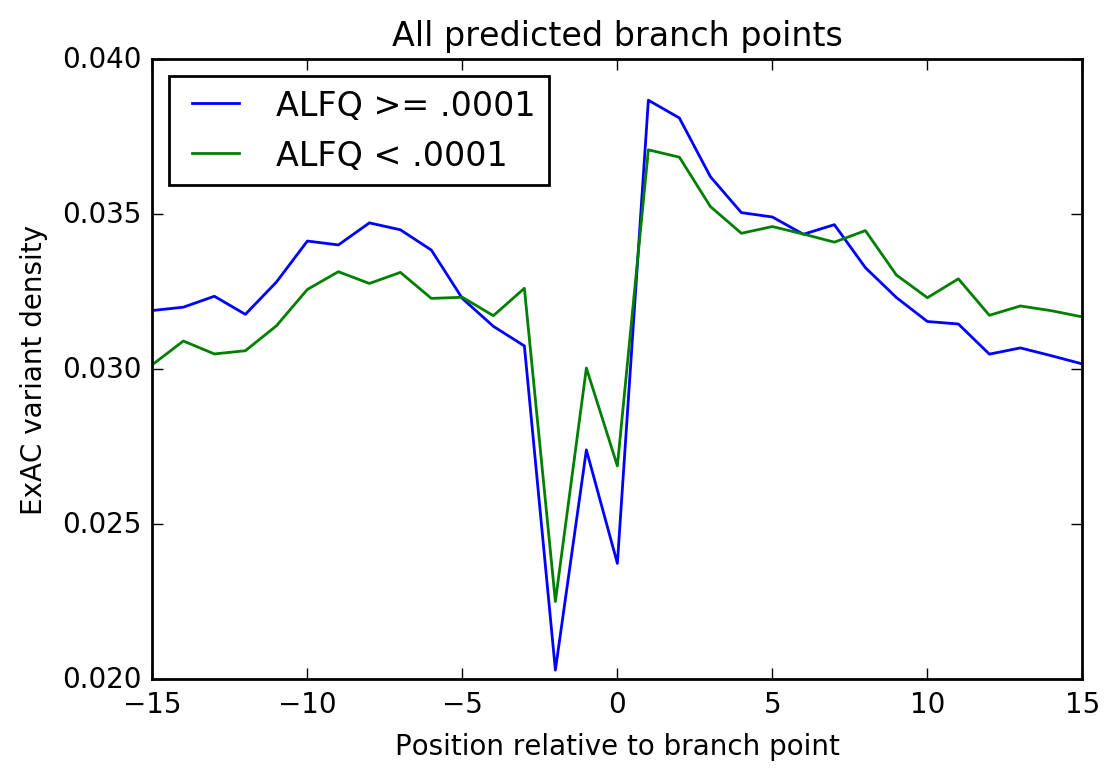

In [31]:
hifq, lofq = [], []
for bp in bps:
    hifq += [var_enrichment(benign[benign['ALFQMAX'] >= .0001], bp, [])]
    lofq += [var_enrichment(benign[benign['ALFQMAX'] <  .0001], bp, [])]

for name, hi, lo in zip(names, hifq, lofq):
    plt.plot(range(-15, 16), np.array(hi)/float(sum(hi)),
             label='ALFQ >= .0001')
    plt.plot(range(-15, 16), np.array(lo)/float(sum(lo)),
             label = 'ALFQ < .0001')
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel("ExAC variant density")
    plt.legend(loc = 'best')
    plt.show()

# Comparison to non-BP TnA motifs

A+T are apparently less mutable than other positions.

Here we make sure the de-enrichments in benign variants hold for
TNA motifs with matched distance to the 3'ss.

In [96]:
def matched(X, y, chroms, coords, strands):
    branch, not_branch = {}, {}
    for chrom, pos, strand, target, seq in zip(chroms, coords, strands, y, X):
        bp = np.argmax(target)
        for i in range(K, L-K):
            if not seq[i, 0]*seq[i-2, 3]: continue
            idx = pos + (i-L+1 if strand == '+' else L-i)
            if i == bp:
                if i not in branch: branch[i] = set()
                branch[i].add((chrom, idx))
            else:
                if i not in not_branch: not_branch[i] = set()
                if (chrom, idx) in not_branch[i]: continue
                not_branch[i].add((chrom, idx))

    for dist in branch.keys():
        num = min(len(branch[dist]), len(not_branch[dist]))
        branch[dist] = list(branch[dist])[:num]
        not_branch[dist] = list(not_branch[dist])[:num]
        print dist, len(branch[dist]), len(not_branch[dist])
    
    bps = {}
    for key, value in branch.items():
        for (chrom, idx) in value:
            if chrom not in bps: bps[chrom] = {}
            #assert idx not in bps[chrom]
            bps[chrom][idx] = 1
    n_bps = {}
    for key, value in not_branch.items():
        for (chrom, idx) in value:
            if chrom not in n_bps: n_bps[chrom] = {}
            #assert idx not in n_bps[chrom]
            n_bps[chrom][idx] = 1
    return bps, n_bps
    
K = 15
bps, n_bps = matched(X_all,  y_all, a_chroms, a_coords, a_strands)

15 117 117
16 141 141
17 150 150
18 183 183
19 216 216
20 227 227
21 226 226
22 292 292
23 324 324
24 377 377
25 467 467
26 528 528
27 633 633
28 769 769
29 854 854
30 1044 1044
31 1255 1255
32 1535 1535
33 1766 1766
34 2360 2360
35 2924 2924
36 3643 3643
37 4431 4431
38 5482 5482
39 6720 6720
40 8089 8089
41 9178 9178
42 9055 9055
43 8661 8661
44 8159 8159
45 8116 8116
46 7887 7887
47 8438 8438
48 8877 8877
49 9059 9059
50 6598 6598
51 4188 4188
52 2246 2246
53 1018 1018
54 351 351


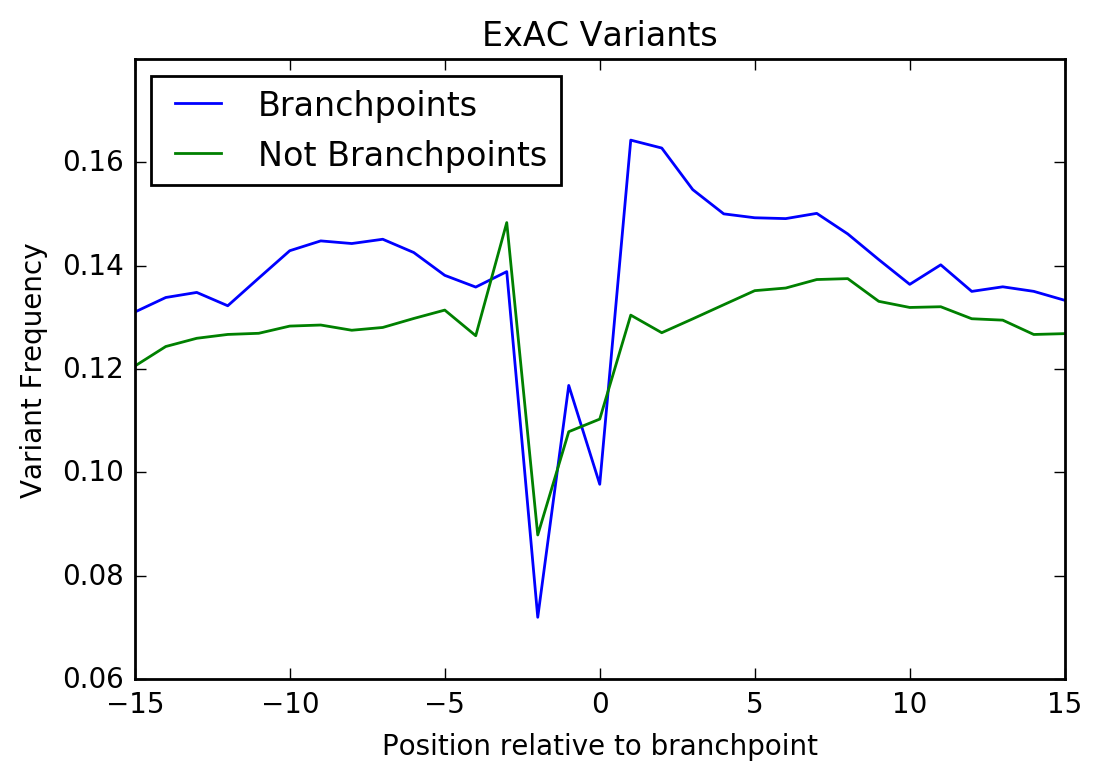

In [33]:
plt.plot(range(-15, 16),
         np.array(var_enrichment(benign, bps, []))
         / float(sum(map(len, bps.values()))),
         label = 'Branchpoints')
plt.plot(range(-15, 16),
         np.array(var_enrichment(benign, n_bps, []))
         / float(sum(map(len, n_bps.values()))),
         label = 'Not Branchpoints')
plt.legend(loc = 'best')
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Variant Frequency')
plt.title('ExAC Variants')
plt.show()

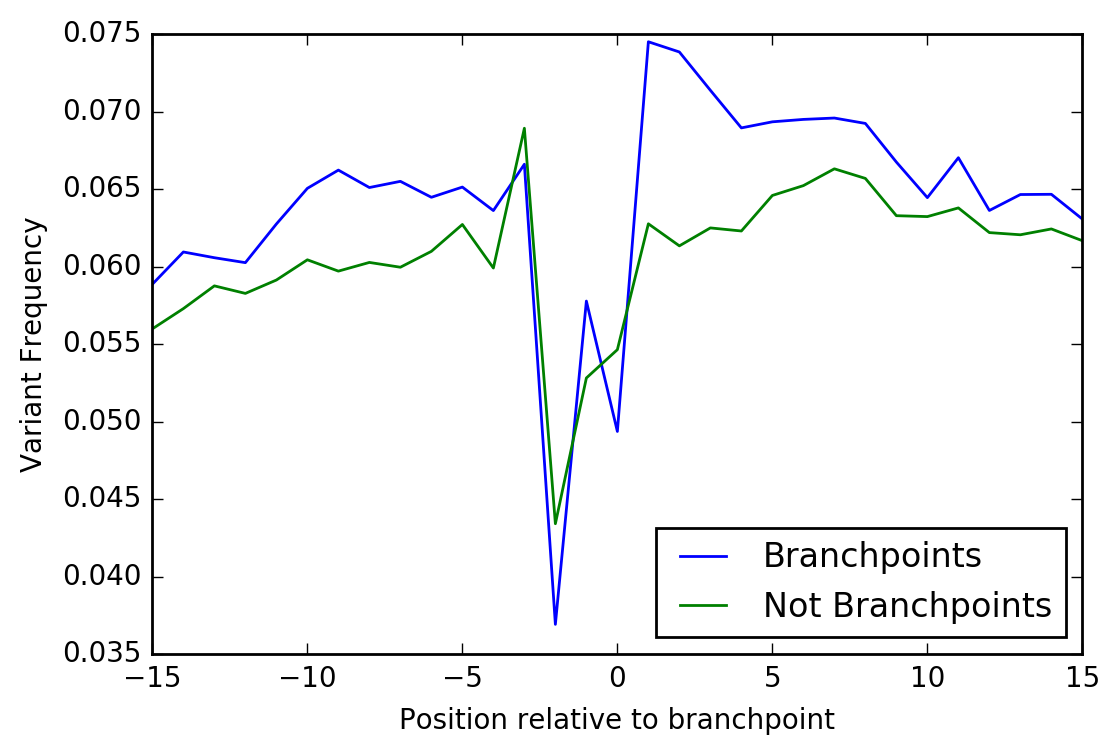

In [34]:
plt.plot(range(-15, 16),
         np.array(var_enrichment(benign[benign['ALFQMAX'] <  .0001], bps, []))
         / float(sum(map(len, bps.values()))),
         label = 'Branchpoints')
plt.plot(range(-15, 16),
         np.array(var_enrichment(benign[benign['ALFQMAX'] <  .0001], n_bps, []))
         / float(sum(map(len, n_bps.values()))),
         label = 'Not Branchpoints')
plt.legend(loc = 'best')
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Variant Frequency')
plt.show()

In [35]:
def one_sided_z_test(hits1, hits2, n1, n2):
    p = (hits1 + hits2) / (n1+n2)
    return (hits1/n1 + hits2/n2) / np.sqrt(p*(1-p)*(1/n1 + 1/n2))

In [36]:
bp_hits = var_enrichment(benign, bps, [])
nbp_hits = var_enrichment(benign, n_bps, [])

135157.0 135607.0
[17708, 18089, 18222, 17873, 18597, 19313, 19570, 19501, 19613, 19266, 18669, 18362, 18766, 9724, 15789, 13203, 22206, 21999, 20911, 20277, 20175, 20153, 20290, 19752, 19081, 18433, 18944, 18249, 18369, 18250, 18016]
[ 0.12577743  0.12908658  0.13037553  0.1294596   0.13224432  0.13558671
  0.13663929  0.13587848  0.13656173  0.13615178  0.13475942  0.13114003
  0.14360107  0.07992569  0.11233399  0.1040057   0.14733495  0.14486416
  0.14219025  0.14121892  0.14220502  0.1423786   0.14370817  0.14180984
  0.13713049  0.13414265  0.13610007  0.13236989  0.13267643  0.13084827
  0.1300653 ]


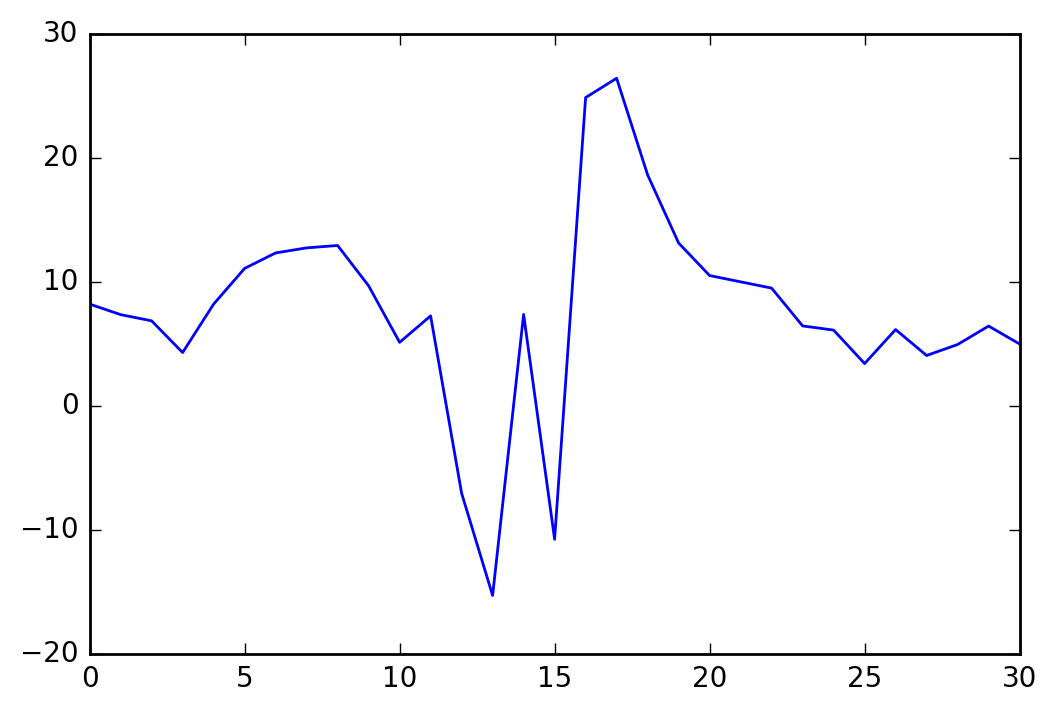

-15 1.10649872859e-16
-14 9.20205986394e-14
-13 3.48054723585e-12
-12 8.51570409224e-06
-11 1.14199358473e-16
-10 7.27016590148e-29
-9 2.94509606018e-35
-8 1.70075854527e-37
-7 1.40419620788e-38
-6 1.75127148867e-22
-5 1.48668147765e-07
-4 1.94971069064e-13
-3 9.33961133483e-13
-2 4.7053613675e-53
-1 7.94670907364e-14
0 2.84343035184e-27
1 9.66183865839e-137
2 3.74333550397e-154
3 8.83696213528e-78
4 1.01109167904e-39
5 3.89984201618e-26
6 7.2997938863e-24
7 1.07262457291e-21
8 5.59879192197e-11
9 4.9701393613e-10
10 0.00032052885639
11 3.7486975672e-10
12 2.41717060857e-05
13 3.7156751874e-07
14 6.02026484057e-11
15 3.0085542966e-07


In [37]:
bp_n = float(sum(map(len, bps.values())))
nbp_n = float(sum(map(len, n_bps.values())))
print bp_n, nbp_n
print bp_hits

p = (np.array(bp_hits) + np.array(nbp_hits)) / (bp_n+nbp_n)
print p
z = (np.array(bp_hits)/bp_n - np.array(nbp_hits)/nbp_n) / np.sqrt(p*(1-p)* (1.0 / bp_n + 1.0 / nbp_n))
plt.plot(z)
plt.show()

from scipy.stats import norm
for i, m in enumerate(z):
    print i-K, norm.cdf(-abs(m))

In [38]:
rare_bp_hits = var_enrichment(benign[benign['ALFQMAX'] <  .0001], bps, [])
rare_nbp_hits = var_enrichment(benign[benign['ALFQMAX'] <  .0001], n_bps, [])

[ 0.12577743  0.12908658  0.13037553  0.1294596   0.13224432  0.13558671
  0.13663929  0.13587848  0.13656173  0.13615178  0.13475942  0.13114003
  0.14360107  0.07992569  0.11233399  0.1040057   0.14733495  0.14486416
  0.14219025  0.14121892  0.14220502  0.1423786   0.14370817  0.14180984
  0.13713049  0.13414265  0.13610007  0.13236989  0.13267643  0.13084827
  0.1300653 ]


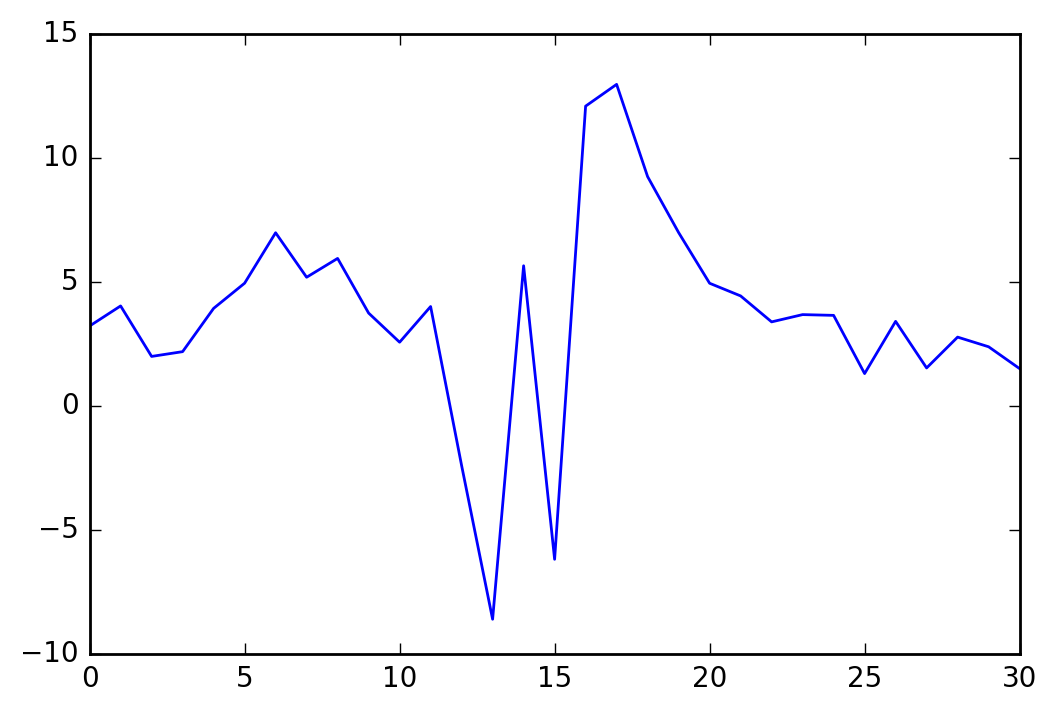

-15 0.000639989761257
-14 2.78185497466e-05
-13 0.0230338157584
-12 0.0143768152298
-11 4.21152365119e-05
-10 3.7625002967e-07
-9 1.46166209778e-12
-8 1.06778369281e-07
-7 1.36963017863e-09
-6 9.09213069587e-05
-5 0.00512473287239
-4 3.08383040137e-05
-3 0.00808981466963
-2 3.8897005808e-18
-1 8.02507976262e-09
0 3.09997877291e-10
1 6.24834950139e-34
2 9.68736773716e-39
3 1.17585403923e-20
4 1.37876618101e-12
5 3.80837792212e-07
6 4.61634073999e-06
7 0.00035253513891
8 0.000116303032694
9 0.000131058991668
10 0.0963109129274
11 0.000327077679776
12 0.0629913794025
13 0.00277457821115
14 0.00856372391366
15 0.0664739680508


In [39]:
rare_p = (np.array(rare_bp_hits) + np.array(rare_nbp_hits)) / (bp_n+nbp_n)
print p
rare_z = ((np.array(rare_bp_hits)/bp_n - np.array(rare_nbp_hits)/nbp_n)
          / np.sqrt(rare_p*(1-rare_p)* (1.0 / bp_n + 1.0 / nbp_n)))
plt.plot(rare_z)
plt.show()

for i, m in enumerate(rare_z):
    print i-K, norm.cdf(-abs(m))

In [40]:
common_bp_hits = var_enrichment(benign[benign['ALFQMAX'] >=  .0001], bps, [])
common_nbp_hits = var_enrichment(benign[benign['ALFQMAX'] >=  .0001], n_bps, [])

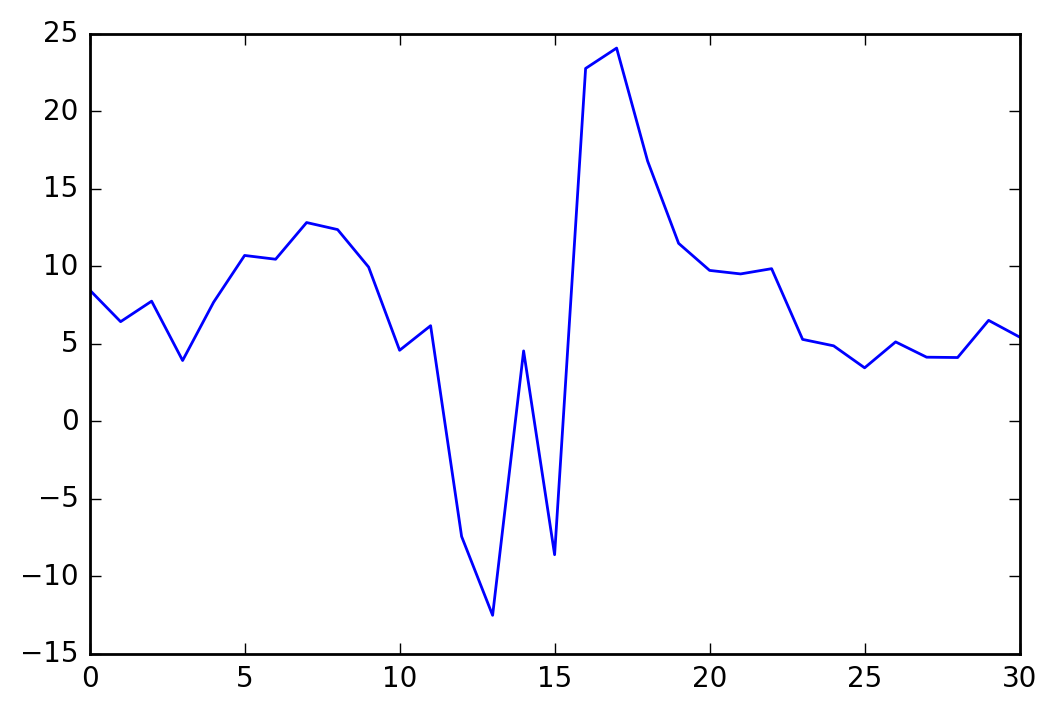

-15 1.10622046194e-17
-14 6.22521708493e-11
-13 4.40061709654e-15
-12 4.28000863145e-05
-11 7.39441907839e-15
-10 4.79246668638e-27
-9 6.49166294963e-26
-8 5.67386026421e-38
-7 1.78908661268e-35
-6 1.1894506999e-23
-5 2.24382624533e-06
-4 3.34036585102e-10
-3 5.69788455828e-14
-2 3.29421673746e-36
-1 2.72583010393e-06
0 3.98062185222e-18
1 4.43761940152e-115
2 1.83023858561e-128
3 1.31940703912e-63
4 7.62954219883e-31
5 1.01040660197e-22
6 9.16935958761e-22
7 3.33994990651e-23
8 6.0952927159e-08
9 5.42504983179e-07
10 0.000273822552053
11 1.45597435121e-07
12 1.72172164127e-05
13 1.89395073321e-05
14 3.56824886171e-11
15 2.66668375543e-08


In [41]:
common_p = (np.array(common_bp_hits) + np.array(common_nbp_hits)) / (bp_n+nbp_n)
common_z = ((np.array(common_bp_hits)/bp_n - np.array(common_nbp_hits)/nbp_n)
          / np.sqrt(rare_p*(1-rare_p)* (1.0 / bp_n + 1.0 / nbp_n)))
plt.plot(common_z)
plt.show()

for i, m in enumerate(common_z):
    print i-K, norm.cdf(-abs(m))

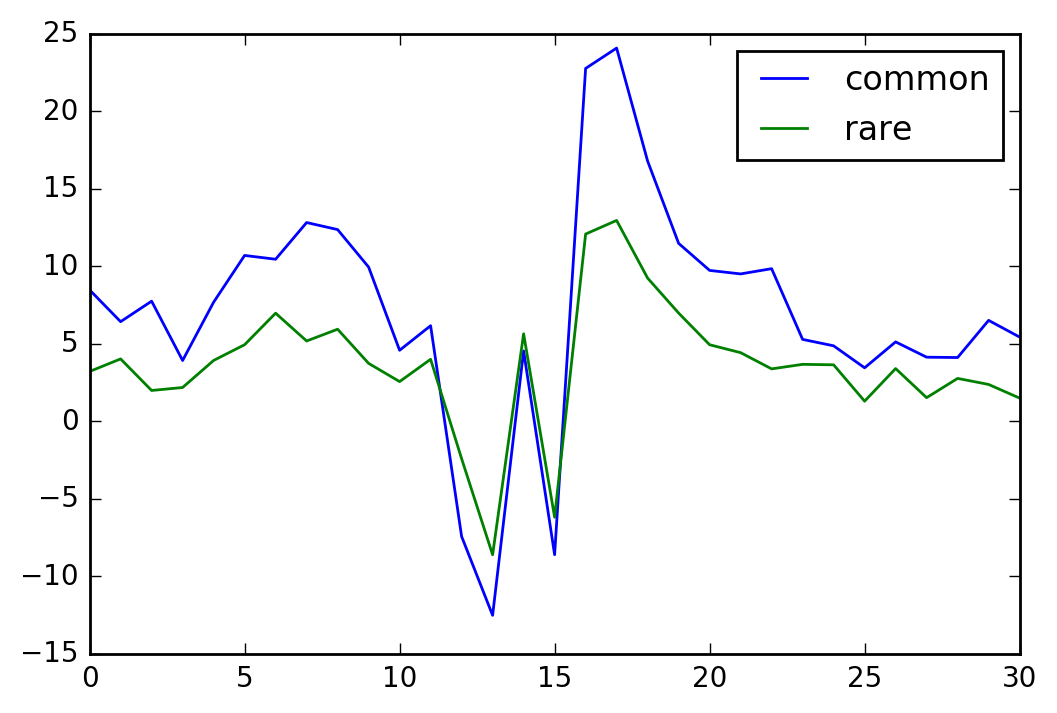

In [42]:
plt.plot(common_z, label = 'common')
plt.plot(rare_z, label = 'rare')
plt.legend()
plt.show()

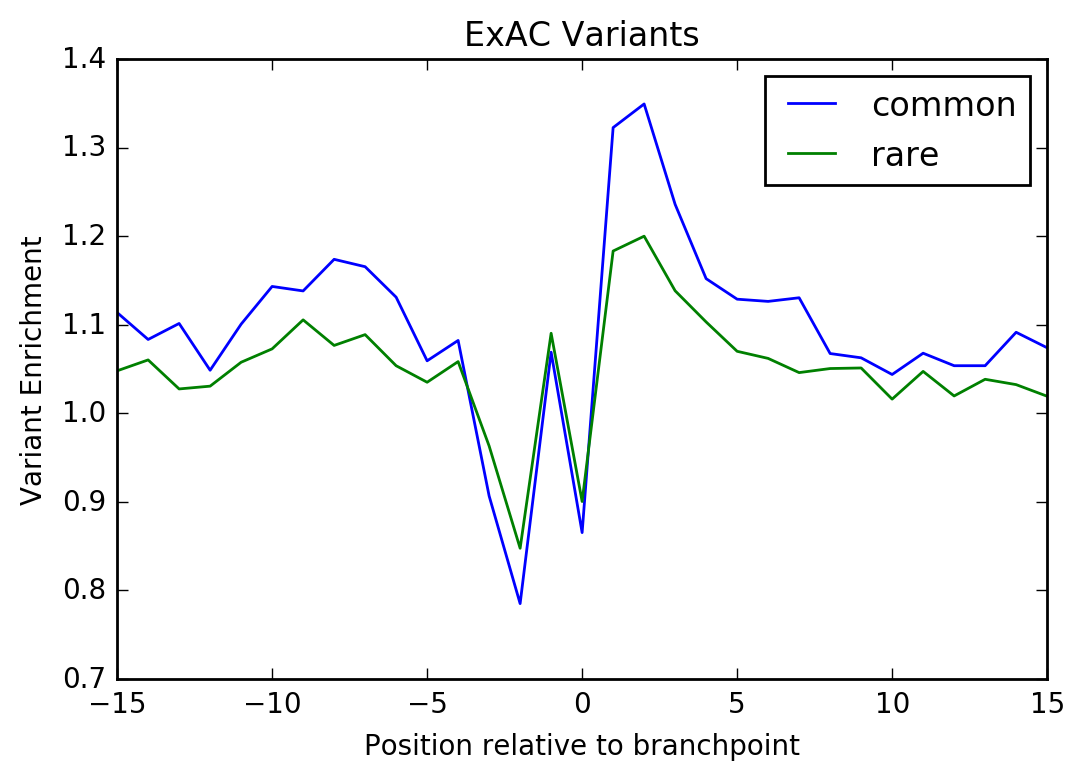

In [43]:
plt.plot(range(-15, 16), np.array(common_bp_hits) / np.array(common_nbp_hits).astype(float), label = 'common')
plt.plot(range(-15, 16), np.array(rare_bp_hits) / np.array(rare_nbp_hits).astype(float), label = 'rare')
plt.legend(loc = 'best')
plt.title('ExAC Variants')
plt.ylabel('Variant Enrichment')
plt.xlabel('Position relative to branchpoint')
plt.show()

In [44]:
rare_bp_hits25 = var_enrichment(benign[benign['ALFQMAX'] <  .0001],
                              bps, [], K = 25)
rare_nbp_hits25 = var_enrichment(benign[benign['ALFQMAX'] <  .0001],
                               n_bps, [], K = 25)
common_bp_hits25 = var_enrichment(benign[benign['ALFQMAX'] >=  .0001],
                                bps, [], K = 25)
common_nbp_hits25 = var_enrichment(benign[benign['ALFQMAX'] >=  .0001],
                                 n_bps, [], K = 25)

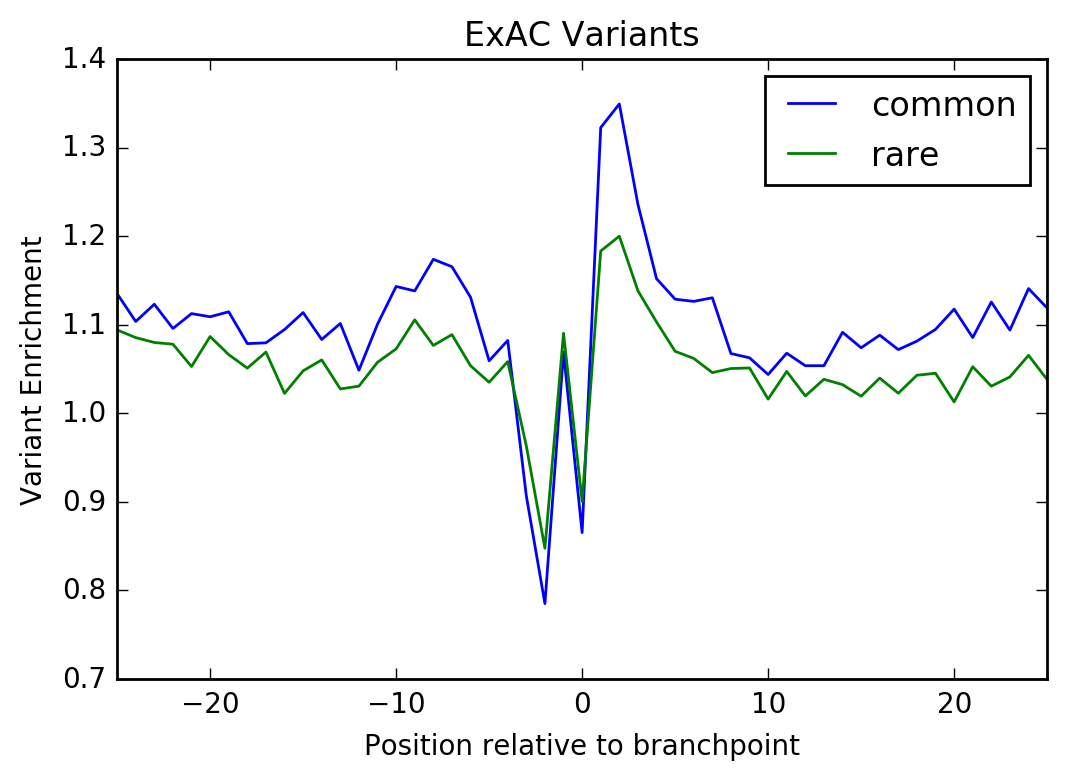

In [45]:
plt.plot(range(-25, 26),
         np.array(common_bp_hits25) / np.array(common_nbp_hits25).astype(float), label = 'common')
plt.plot(range(-25, 26),
         np.array(rare_bp_hits25) / np.array(rare_nbp_hits25).astype(float), label = 'rare')
plt.legend(loc = 'best')
plt.xlim(-25, 25)
plt.title('ExAC Variants')
plt.ylabel('Variant Enrichment')
plt.xlabel('Position relative to branchpoint')
plt.show()

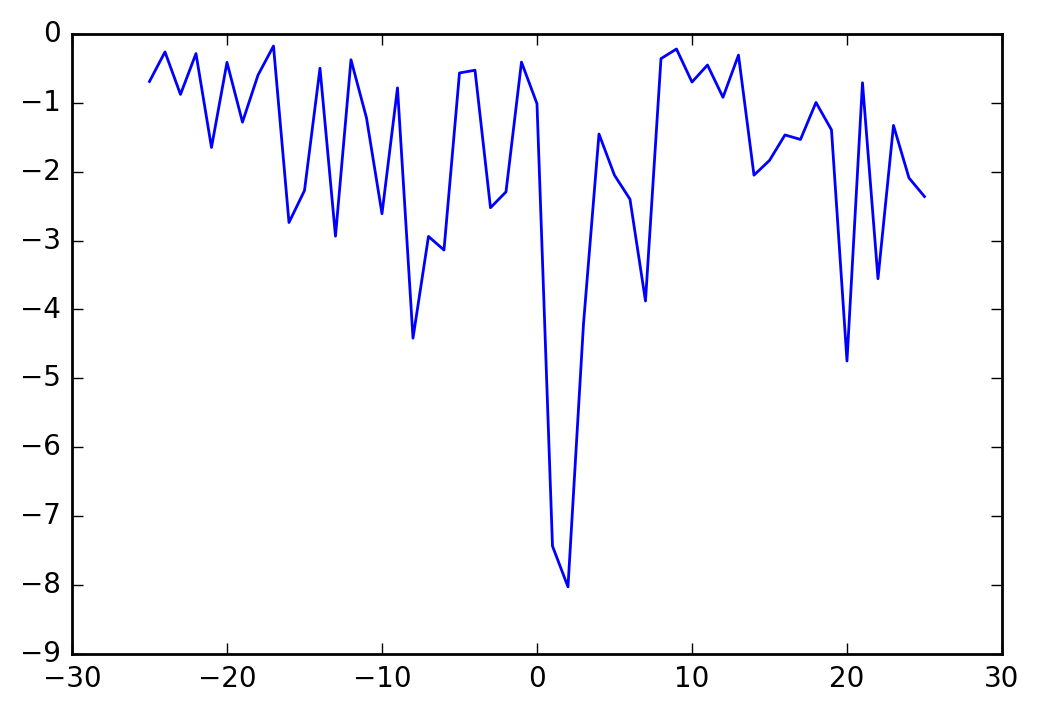

In [93]:
from scipy.stats import fisher_exact
a = []
for i in range(-25, 26):
    i += 25
    _, p =  fisher_exact([[common_bp_hits25[i], common_nbp_hits25[i]],
                           [rare_bp_hits25[i], rare_nbp_hits25[i]]])
    a += [np.log10(p)]
plt.plot(range(-25, 26), a)
plt.show()

In [100]:
rare_bp_hits25 = var_enrichment(benign[benign['ALFQMAX'] <  .0001],
                              bps, [], K = 25)
rare_nbp_hits25 = var_enrichment(benign[benign['ALFQMAX'] <  .0001],
                               n_bps, [], K = 25)
common_bp_hits25 = var_enrichment(benign[benign['ALFQMAX'] >=  .001],
                                bps, [], K = 25)
common_nbp_hits25 = var_enrichment(benign[benign['ALFQMAX'] >=  .001],
                                 n_bps, [], K = 25)

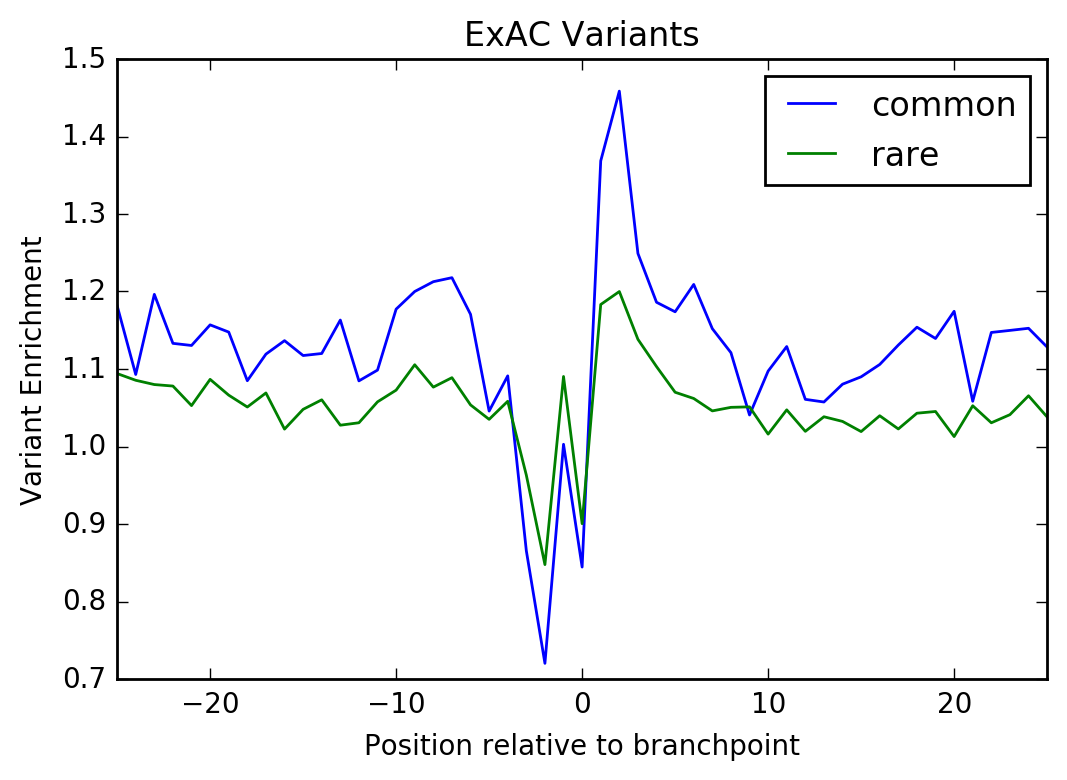

In [101]:
plt.plot(range(-25, 26),
         np.array(common_bp_hits25) / np.array(common_nbp_hits25).astype(float), label = 'common')
plt.plot(range(-25, 26),
         np.array(rare_bp_hits25) / np.array(rare_nbp_hits25).astype(float), label = 'rare')
plt.legend(loc = 'best')
plt.xlim(-25, 25)
plt.title('ExAC Variants')
plt.ylabel('Variant Enrichment')
plt.xlabel('Position relative to branchpoint')
plt.show()

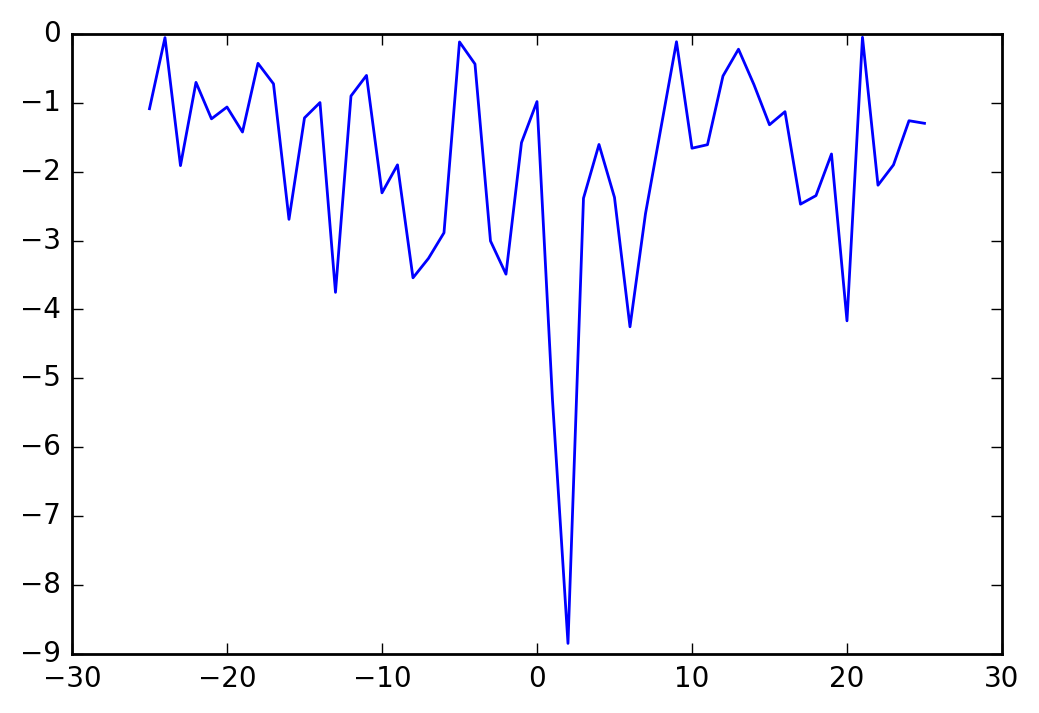

In [102]:
a = []
for i in range(-25, 26):
    i += 25
    _, p =  fisher_exact([[common_bp_hits25[i], common_nbp_hits25[i]],
                           [rare_bp_hits25[i], rare_nbp_hits25[i]]])
    a += [np.log10(p)]
plt.plot(range(-25, 26), a)
plt.show()

# ISM Example

      CHROM REF ALT  3'Dist
13696     9   T   G     -24
(1, 70, 7)
(1, 46, 4)
GGAGACAGCTGCCACCTGAGCAGGGCCGGGCATTTAGAGAGTGACTGACCAGCCCCTTCTCTGATTCTAG
GGAGACAGCTGCCACCTGAGCAGGGCCGGGCATTTAGAGAGTGACGGACCAGCCCCTTCTCTGATTCTAG


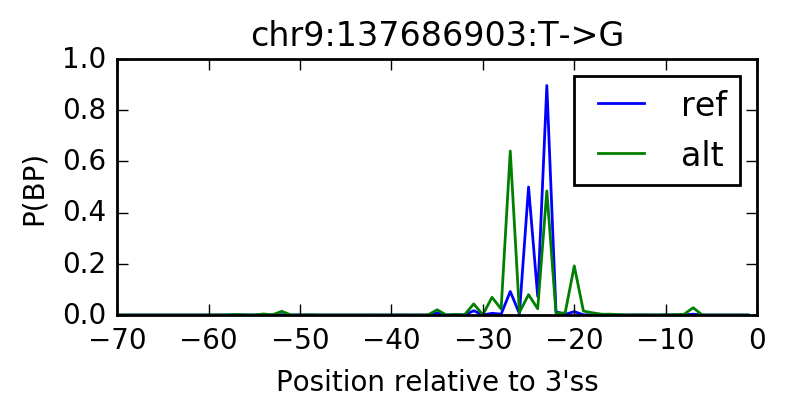

In [49]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

print pathogenic[pathogenic['POS'] == 137686903][['CHROM', 'REF', 'ALT', "3'Dist"]]
seq = X_all[137686927 == a_coords]
ref = model.predict(seq[:, :, :4])
alt = model.predict(np.hstack([seq[:, :-25, :4],
                               np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                               seq[:, -25+1:, :4]]))

print seq.shape
print seq[:, :-24, :4].shape

print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :, :4].reshape(L, 4)))
print ''.join(map(lambda x: bases[np.argmax(x)],
                  np.hstack([seq[:, :-25, :4],
                             np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                             seq[:, -25+1:, :4]]
                           ).reshape(L, 4)))
fig = plt.figure()
adjustFigAspect(fig,aspect=2.5)

ax = fig.add_subplot(111)
plt.plot(range(-L, 0), ref[0], label = 'ref')
plt.plot(range(-L, 0), alt[0], label = 'alt')
plt.legend(loc = 'best')
plt.ylim(0, 1)
plt.ylabel('P(BP)')
plt.xlabel("Position relative to 3'ss")
plt.title('chr9:137686903:T->G')
plt.show()

     CHROM REF ALT  3'Dist
9343    21   A   G     -21
(1, 70, 7)
(1, 46, 4)
GGGGCTGGGTGGGACTGGCCCCTGCCCCTGCTCCTCCGGGGGTGTCTCACCATCTCCTCCTGTGTTCCAG
GGGGCTGGGTGGGACTGGCCCCTGCCCCTGCTCCTCCGGGGGTGTCTCGCCATCTCCTCCTGTGTTCCAG


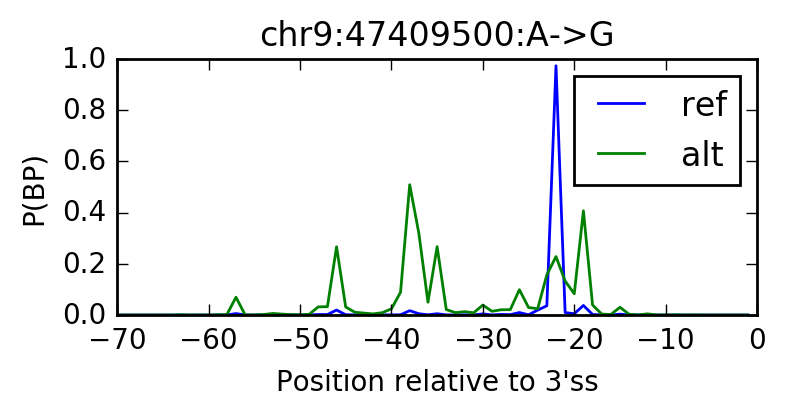

In [50]:
print pathogenic[pathogenic['POS'] == 47409500][['CHROM', 'REF', 'ALT', "3'Dist"]]
seq = X_all[47409521 == a_coords]
ref = model.predict(seq[:, :, :4])
alt = model.predict(np.hstack([seq[:, :-22, :4],
                               np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                               seq[:, -22+1:, :4]]))

print seq.shape
print seq[:, :-24, :4].shape

print ''.join(map(lambda x: bases[np.argmax(x)], seq[:, :, :4].reshape(L, 4)))
print ''.join(map(lambda x: bases[np.argmax(x)],
                  np.hstack([seq[:, :-22, :4],
                             np.array([0, 0, 1, 0]).reshape(1, 1, 4),
                             seq[:, -22+1:, :4]]
                           ).reshape(L, 4)))


fig = plt.figure()
adjustFigAspect(fig,aspect=2.5)

ax = fig.add_subplot(111)
plt.plot(range(-L, 0), ref[0], label = 'ref')
plt.plot(range(-L, 0), alt[0], label = 'alt')
plt.legend(loc = 'best')
plt.ylabel('P(BP)')
plt.xlabel("Position relative to 3'ss")
plt.title('chr9:47409500:A->G')
plt.show()